# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import time
import pickle
import gp_gpy as gp
import plot 
import GPy

version = 2
LIKELIHOOD_MODEL = 'likelihood-' + str(version)
PREDICTION_MODEL = 'predict-' + str(version)
sns.set(style="darkgrid")
np.random.seed(1)
train = pd.read_pickle('train.pkl')
n_trajs = train.traj.unique()
n_trajs_to_use = 50
train = train[train.traj < n_trajs[n_trajs_to_use]]
route_n = 3 # all data used currently is from route 3
n_segs = train.seg.unique()
train.head()

def synch_traj(synch_gp, data):
    X = data[['lat', 'lon']].values
    tau, _var = gp.predict(synch_gp, X)
    return data.assign(tau=tau.reshape(tau.shape[0]))
train.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.565087,58.414577,2.0,2,6.01,71.0,0.000000
1,15.564932,58.414516,2.0,2,4.88,55.0,0.027027
2,15.564720,58.414413,2.0,2,-1.00,41.0,0.054054
3,15.564830,58.414463,2.0,2,3.54,36.0,0.081081
4,15.564659,58.414391,2.0,2,3.85,33.0,0.108108


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [302]:
%%capture
def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_traj(synch_gp, seg)
    n_restarts = 5
    print('training', route_n, traj_n, seg_n)
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg[['tau']],
        synched_seg[['lat', 'lon']],
        LIKELIHOOD_MODEL,
        route_n,
        traj_n,
        seg_n)
    likelihood_model.model.kern.lengthscale = 0.05
    likelihood_model.model.kern.variance = 5
    likelihood_model.model.likelihood.variance = 0.001
    likelihood_model.model.likelihood.variance.fix()
    
    likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.0005))
    likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 0.1))
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg[['tau']], 
        synched_seg[['time_left']], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1, 0.5))
    prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(4, 1))
    
    # the variances are too different to capture with a good prior
    #prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.005))
    #prediction_model.model.likelihood.variance = 0.001
    #prediction_model.model.likelihood.variance.fix() 
    gp.train(prediction_model, n_restarts)
    
    return likelihood_model, prediction_model

t0 = time.time()
traj_to_plot = 2
n_trajs = train.traj.unique()
for traj_n in n_trajs:
    traj = train[train.traj == traj_n]
    n_segs = traj.seg.unique()
    for seg_n in n_segs:
        lik_model, pred_model = train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n)
        gp.save(lik_model)
        gp.save(pred_model)
        
        #print(lik_model.model)
        #print(pred_model.model)
        
dt = time.time() - t0
print("Data processed in", dt, " seconds")

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 2.0 2
Optimization restart 1/5, f = -68.88381058497606
Optimization restart 2/5, f = -68.88381058496545
Optimization restart 3/5, f = -68.88381058499115
Optimization restart 4/5, f = -68.88381058498912
Optimization restart 5/5, f = -68.88381058498878
Optimization restart 1/5, f = 14.65701662042877
Optimization restart 2/5, f = 14.657016620444672
Optimization restart 3/5, f = 14.657016620423764


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 14.657016620422533
Optimization restart 5/5, f = 14.657016620440924
training 3 2.0 3
Optimization restart 1/5, f = -121.41819045474514
Optimization restart 2/5, f = -121.41819045480588
Optimization restart 3/5, f = -121.41819045481421
Optimization restart 4/5, f = -121.41819045481878


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -121.41819045482058
Optimization restart 1/5, f = -23.84884221730913
Optimization restart 2/5, f = -23.84884221730954
Optimization restart 3/5, f = -23.848842217316506
Optimization restart 4/5, f = -23.848842217316125
Optimization restart 5/5, f = -23.84884221731623
training 3 2.0 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -15.154665382586902
Optimization restart 2/5, f = -15.154665382589904
Optimization restart 3/5, f = -15.154665382587531
Optimization restart 4/5, f = -15.154665382591343
Optimization restart 5/5, f = -15.154665382584007
Optimization restart 1/5, f = 12.192572212911077
Optimization restart 2/5, f = 12.192572212902157
Optimization restart 3/5, f = 12.19257221290234
Optimization restart 4/5, f = 12.192572212904011


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 12.192572212904834
training 3 2.0 5
Optimization restart 1/5, f = -135.02123427903135


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -135.021234279029
Optimization restart 3/5, f = -135.02123427886318
Optimization restart 4/5, f = -135.02123427902754
Optimization restart 5/5, f = -135.0212342790287
Optimization restart 1/5, f = -117.62505687368859
Optimization restart 2/5, f = -117.62505687365373
Optimization restart 3/5, f = -117.62505687366489
Optimization restart 4/5, f = -117.62505687276011


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -117.62505687015359
training 3 2.0 6
Optimization restart 1/5, f = -93.26174137832533
Optimization restart 2/5, f = -93.26174137831264


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -93.2617413783401
Optimization restart 4/5, f = -93.26174137831208
Optimization restart 5/5, f = -93.26174137832136
Optimization restart 1/5, f = -17.524094871589547
Optimization restart 2/5, f = -17.524094871507902
Optimization restart 3/5, f = -17.52409487164149
Optimization restart 4/5, f = -17.52409487159892
Optimization restart 5/5, f = -17.52409487164315


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 2.0 7
Optimization restart 1/5, f = 82.63515321091147
Optimization restart 2/5, f = 82.63515321090858
Optimization restart 3/5, f = 173.29224660517812
Optimization restart 4/5, f = 82.63515321090878
Optimization restart 5/5, f = 82.63515321091901
Optimization restart 1/5, f = -2.0345053918794385


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -2.0345053919109537
Optimization restart 3/5, f = -2.0345053919102876
Optimization restart 4/5, f = -2.0345053919098657
Optimization restart 5/5, f = -2.0345053919038385
training 3 2.0 8
Optimization restart 1/5, f = -42.96224456243403
Optimization restart 2/5, f = -42.96224456242982
Optimization restart 3/5, f = -42.962244562422875
Optimization restart 4/5, f = -42.96224456243341


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -42.96224456242945
Optimization restart 1/5, f = 12.27664308710623
Optimization restart 2/5, f = 12.276643087119247
Optimization restart 3/5, f = 12.276643087108525
Optimization restart 4/5, f = 12.27664308710683
Optimization restart 5/5, f = 12.276643087106319


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 2.0 9
Optimization restart 1/5, f = -477.2391408557194
Optimization restart 2/5, f = -477.23914085864527
Optimization restart 3/5, f = -477.2391408581573


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -477.23914085865135
Optimization restart 5/5, f = -477.23914085864766
Optimization restart 1/5, f = -236.8791585899471
Optimization restart 2/5, f = -238.01388317899094
Optimization restart 3/5, f = -236.8791585901695
Optimization restart 4/5, f = -236.87915859011412
Optimization restart 5/5, f = -238.0138831785608


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 2.0 10
Optimization restart 1/5, f = -101.22184028580445
Optimization restart 2/5, f = -101.2218402861017
Optimization restart 3/5, f = -101.22184028610414
Optimization restart 4/5, f = -101.22184028610255
Optimization restart 5/5, f = -101.22184028610161
Optimization restart 1/5, f = -15.684431587099697
Optimization restart 2/5, f = -15.684431587095036


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -15.684431587089055
Optimization restart 4/5, f = -15.684431587096569
Optimization restart 5/5, f = -15.68443158707049
training 3 2.0 11
Optimization restart 1/5, f = -76.9496687890267


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -76.94966878992474
Optimization restart 3/5, f = -76.94966878992633
Optimization restart 4/5, f = -76.94966878992864
Optimization restart 5/5, f = -76.94966878992506
Optimization restart 1/5, f = -26.712953524052853
Optimization restart 2/5, f = -26.712953524050885
Optimization restart 3/5, f = -26.712953524018637
Optimization restart 4/5, f = -26.712953524046068
Optimization restart 5/5, f = -26.712953524042447


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 6.0 2
Optimization restart 1/5, f = -65.09468986469844
Optimization restart 2/5, f = -65.09468986469076
Optimization restart 3/5, f = -65.09468986469614
Optimization restart 4/5, f = -65.0946898646997
Optimization restart 5/5, f = -65.09468986469847
Optimization restart 1/5, f = 7.92290846948677
Optimization restart 2/5, f = 7.922908469519519
Optimization restart 3/5, f = 7.922908469487361


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 7.922908469490442
Optimization restart 5/5, f = 7.922908469502018
training 3 6.0 3
Optimization restart 1/5, f = -112.08757582549521
Optimization restart 2/5, f = -112.08757582581993
Optimization restart 3/5, f = -112.0875758258615
Optimization restart 4/5, f = -112.08757582585034


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -112.08757582585946
Optimization restart 1/5, f = -23.72045451587167
Optimization restart 2/5, f = -23.720454515829246
Optimization restart 3/5, f = -23.72045451587246
Optimization restart 4/5, f = -23.72045451587136
Optimization restart 5/5, f = -23.7204545158477
training 3 6.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -7.918507188617793
Optimization restart 2/5, f = -7.91850718861768
Optimization restart 3/5, f = -7.918507188594784
Optimization restart 4/5, f = -7.918507188611006
Optimization restart 5/5, f = -7.918507188618291
Optimization restart 1/5, f = 9.502266695835917
Optimization restart 2/5, f = 9.502266695843325
Optimization restart 3/5, f = 9.669910264813723
Optimization restart 4/5, f = 9.669910264795423


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 9.669910264804138
training 3 6.0 5
Optimization restart 1/5, f = -144.6318712455224


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -144.631871245528
Optimization restart 3/5, f = -144.63187124552752
Optimization restart 4/5, f = -144.63187124543455
Optimization restart 5/5, f = -144.63187124552454
Optimization restart 1/5, f = -62.255401663717244
Optimization restart 2/5, f = -62.255401662565134
Optimization restart 3/5, f = -62.25540166372027
Optimization restart 4/5, f = -61.30483202016064
Optimization restart 5/5, f = -62.255401663724726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 6.0 6
Optimization restart 1/5, f = -98.23279649552785
Optimization restart 2/5, f = -98.23279649549593
Optimization restart 3/5, f = -98.23279649538878
Optimization restart 4/5, f = -98.23279649545701
Optimization restart 5/5, f = -98.23279649550418
Optimization restart 1/5, f = -27.821891189114588
Optimization restart 2/5, f = -27.759266392050492
Optimization restart 3/5, f = -27.821891189108396
Optimization restart 4/5, f = -27.759266392049582
Optimization restart 5/5, f = -27.75926639205042
training 3 6.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 179.33782984264522
Optimization restart 2/5, f = 179.63825640194406
Optimization restart 3/5, f = 179.63825639643284
Optimization restart 4/5, f = 179.63825639640012
Optimization restart 5/5, f = 179.6382563963927
Optimization restart 1/5, f = 8.748351242232529
Optimization restart 2/5, f = 8.74835124220825
Optimization restart 3/5, f = 8.748351242208813
Optimization restart 4/5, f = 8.748351242208065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = 8.748351242214923
training 3 6.0 8
Optimization restart 1/5, f = -47.26198612428682
Optimization restart 2/5, f = -47.26198612428835
Optimization restart 3/5, f = -47.26198612428739
Optimization restart 4/5, f = -47.26198612428812
Optimization restart 5/5, f = -47.26198612428932


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -7.438805734845861
Optimization restart 2/5, f = -5.876741748462992
Optimization restart 3/5, f = -7.438805734845796
Optimization restart 4/5, f = -5.876741748464139
Optimization restart 5/5, f = -7.4388057348460705


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 6.0 9
Optimization restart 1/5, f = -470.1479530611841
Optimization restart 2/5, f = -470.14795306064565
Optimization restart 3/5, f = -470.1479530611882
Optimization restart 4/5, f = -470.1479530609401


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -470.1479530611648
Optimization restart 1/5, f = -216.82034903332377
Optimization restart 2/5, f = -216.8203490519267
Optimization restart 3/5, f = -216.82034905228937
Optimization restart 4/5, f = -216.82034904865293
Optimization restart 5/5, f = -216.8203490513176


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 6.0 10
Optimization restart 1/5, f = -97.96797507416565
Optimization restart 2/5, f = -97.9679750744521
Optimization restart 3/5, f = -97.96797507474678
Optimization restart 4/5, f = -97.96797507474452
Optimization restart 5/5, f = -97.96797507474724
Optimization restart 1/5, f = -47.86772946276341
Optimization restart 2/5, f = -47.86772946277023


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -47.867729462762505
Optimization restart 4/5, f = -47.86772946277195
Optimization restart 5/5, f = -47.86772946276866
training 3 6.0 11


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -94.74184940220196
Optimization restart 2/5, f = -94.74184940220441
Optimization restart 3/5, f = -94.74184940219928
Optimization restart 4/5, f = -94.74184940220269
Optimization restart 5/5, f = -94.74184940220356
Optimization restart 1/5, f = -65.82351873788636
Optimization restart 2/5, f = -65.82351873789203
Optimization restart 3/5, f = -65.82351873757604
Optimization restart 4/5, f = -65.82351873789486


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -65.82351873790208
training 3 8.0 2
Optimization restart 1/5, f = -71.34588307966033
Optimization restart 2/5, f = -71.34588307965181
Optimization restart 3/5, f = -71.34588307965953
Optimization restart 4/5, f = -71.34588307965959
Optimization restart 5/5, f = -71.34588307966216


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -2.7463283472704356
Optimization restart 2/5, f = -2.916619283209557
Optimization restart 3/5, f = -2.916619283209105
Optimization restart 4/5, f = -2.916619283196294
Optimization restart 5/5, f = -2.916619283208825
training 3 8.0 3
Optimization restart 1/5, f = -88.82096179159035


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -88.82096179157523
Optimization restart 3/5, f = -88.82096179158879
Optimization restart 4/5, f = -88.82096179158901
Optimization restart 5/5, f = -88.82096179158864
Optimization restart 1/5, f = 6.704825665862313
Optimization restart 2/5, f = 6.704825665857503
Optimization restart 3/5, f = 6.704825665973349
Optimization restart 4/5, f = 6.704825665952751
Optimization restart 5/5, f = 6.7048256658585075


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 8.0 4
Optimization restart 1/5, f = 14.688148929086701
Optimization restart 2/5, f = 14.688148929106639
Optimization restart 3/5, f = 14.688148929098997
Optimization restart 4/5, f = 14.688148929082551
Optimization restart 5/5, f = 14.688148929193897
Optimization restart 1/5, f = -37.875473652117826
Optimization restart 2/5, f = -37.875473652154774
Optimization restart 3/5, f = -37.8754736522342
Optimization restart 4/5, f = -37.87547365222816


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -37.875473651485535
training 3 8.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -104.1488623375995
Optimization restart 2/5, f = -104.14886233761169
Optimization restart 3/5, f = -104.14886233761169
Optimization restart 4/5, f = -104.14886233761466
Optimization restart 5/5, f = -104.14886233750536
Optimization restart 1/5, f = -130.38652672823483
Optimization restart 2/5, f = -130.38652672868832
Optimization restart 3/5, f = -130.3865267268774


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -130.3865267280215
Optimization restart 5/5, f = -130.38652672835588
training 3 8.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 147.05585210687036
Optimization restart 2/5, f = -9.99926973423651
Optimization restart 3/5, f = -9.999269734310229
Optimization restart 4/5, f = -9.999269734274762
Optimization restart 5/5, f = -9.999269734325996
Optimization restart 1/5, f = -3.547501981094615
Optimization restart 2/5, f = -2.679230122465336
Optimization restart 3/5, f = -3.547501981102999
Optimization restart 4/5, f = -2.6792301224645367
Optimization restart 5/5, f = -2.6792301224124957


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 8.0 7
Optimization restart 1/5, f = -60.66828193324297
Optimization restart 2/5, f = -60.668281933222985
Optimization restart 3/5, f = -60.66828193323799
Optimization restart 4/5, f = -60.66828193323832
Optimization restart 5/5, f = -60.668281933224804
Optimization restart 1/5, f = -29.24667988153809
Optimization restart 2/5, f = -29.246679881536235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -29.246679881441594
Optimization restart 4/5, f = -29.246679881477903
Optimization restart 5/5, f = -29.24667988153599
training 3 8.0 8
Optimization restart 1/5, f = -17.671610301902355
Optimization restart 2/5, f = -17.67161030190136
Optimization restart 3/5, f = -17.671610301900664


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -17.67161030190053
Optimization restart 5/5, f = -17.6716103018995
Optimization restart 1/5, f = -28.241165041161942
Optimization restart 2/5, f = -28.241165041132884
Optimization restart 3/5, f = -28.241165041153632
Optimization restart 4/5, f = -27.809024185448852
Optimization restart 5/5, f = -28.24116504116114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 8.0 9
Optimization restart 1/5, f = -480.73512481373825
Optimization restart 2/5, f = -480.7351248142873
Optimization restart 3/5, f = -480.73512481388
Optimization restart 4/5, f = -480.73512481429685


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -480.7351248141469
Optimization restart 1/5, f = -290.329009211947
Optimization restart 2/5, f = -290.3290092118889
Optimization restart 3/5, f = -284.28383568613543
Optimization restart 4/5, f = -290.32900921153407
Optimization restart 5/5, f = -290.3290092121242
training 3 8.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -89.69658806928922
Optimization restart 2/5, f = -89.69658806986683
Optimization restart 3/5, f = -89.69658806985359
Optimization restart 4/5, f = -89.69658806986439
Optimization restart 5/5, f = -89.6965880697833
Optimization restart 1/5, f = -36.20298710665717
Optimization restart 2/5, f = -33.83205381219175
Optimization restart 3/5, f = -33.832053812213815
Optimization restart 4/5, f = -36.202987106497396


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -36.202987106669916
training 3 8.0 11
Optimization restart 1/5, f = -81.35778485956385
Optimization restart 2/5, f = -81.35778485956041
Optimization restart 3/5, f = -81.35778485956493
Optimization restart 4/5, f = -81.35778485955748


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -81.35778485790132
Optimization restart 1/5, f = -9.943864843451697
Optimization restart 2/5, f = -9.943864843062372
Optimization restart 3/5, f = -9.943864843450264
Optimization restart 4/5, f = -9.943864843451534
Optimization restart 5/5, f = -9.943864843412898
training 3 9.0 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -60.9925929076006
Optimization restart 2/5, f = -60.992592907603374
Optimization restart 3/5, f = -60.99259290760099
Optimization restart 4/5, f = -60.9925929076011
Optimization restart 5/5, f = -60.99259290760203
Optimization restart 1/5, f = -4.701127454289142
Optimization restart 2/5, f = -4.701127454277294
Optimization restart 3/5, f = -4.701127454166839
Optimization restart 4/5, f = -4.701127454275619
Optimization restart 5/5, f = -4.701127454289279


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 9.0 3
Optimization restart 1/5, f = -106.98177076387313
Optimization restart 2/5, f = -106.98177076371252
Optimization restart 3/5, f = -106.98177076389351
Optimization restart 4/5, f = -106.98177076389189
Optimization restart 5/5, f = -106.98177076389192
Optimization restart 1/5, f = -12.48431707797263
Optimization restart 2/5, f = -12.48431707800444


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -12.484317077913516
Optimization restart 4/5, f = -12.484317077998147
Optimization restart 5/5, f = -12.484317077881945
training 3 9.0 4
Optimization restart 1/5, f = -15.314556048139938
Optimization restart 2/5, f = -15.31455604814267
Optimization restart 3/5, f = -15.31455604813318
Optimization restart 4/5, f = -15.31455604812663
Optimization restart 5/5, f = -15.314556048063828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 9.470638413957948
Optimization restart 2/5, f = 9.470638413904673
Optimization restart 3/5, f = 9.470638413868
Optimization restart 4/5, f = 9.470638413932427
Optimization restart 5/5, f = 9.470638413867963


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 9.0 5
Optimization restart 1/5, f = -119.79493352041979
Optimization restart 2/5, f = -119.79493352252584
Optimization restart 3/5, f = -119.79493352260657
Optimization restart 4/5, f = -119.7949335226081
Optimization restart 5/5, f = -119.79493352260728
Optimization restart 1/5, f = -101.48938771064329
Optimization restart 2/5, f = -101.4893877070175
Optimization restart 3/5, f = -101.48938771062038
Optimization restart 4/5, f = -101.48938771057675
Optimization restart 5/5, f = -101.48938771060917
training 3 9.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 26.095673765364538
Optimization restart 2/5, f = 26.09567376542053
Optimization restart 3/5, f = 26.095673765398686
Optimization restart 4/5, f = 26.09567376536461
Optimization restart 5/5, f = 26.0956737653335
Optimization restart 1/5, f = -2.2655060518144348
Optimization restart 2/5, f = -2.2655060518151258
Optimization restart 3/5, f = -2.265506051815723
Optimization restart 4/5, f = -2.265506051759859
Optimization restart 5/5, f = -2.265506051769104


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 9.0 7
Optimization restart 1/5, f = -95.74299728832824
Optimization restart 2/5, f = -95.74299728856722
Optimization restart 3/5, f = -95.7429972886134
Optimization restart 4/5, f = -95.74299728861511
Optimization restart 5/5, f = -95.74299728858841
Optimization restart 1/5, f = -12.231881834893045
Optimization restart 2/5, f = -12.231881834941657
Optimization restart 3/5, f = -14.61828242025182


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 4/5, f = -14.618282419283862
Optimization restart 5/5, f = -12.231881834936953
training 3 9.0 8
Optimization restart 1/5, f = -46.26262904008654
Optimization restart 2/5, f = -46.26262904008559
Optimization restart 3/5, f = -46.26262904008825
Optimization restart 4/5, f = -46.26262904008622
Optimization restart 5/5, f = -46.26262904008203


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -0.9139456285394241
Optimization restart 2/5, f = -0.9139456285394072
Optimization restart 3/5, f = -0.9139456285391256
Optimization restart 4/5, f = -0.9139456285394192
Optimization restart 5/5, f = -0.9139456285389613


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 9.0 9
Optimization restart 1/5, f = -451.28231379580114
Optimization restart 2/5, f = -451.2823137958083
Optimization restart 3/5, f = -451.2823137958087
Optimization restart 4/5, f = -451.2823137957209


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -451.2823137958011
Optimization restart 1/5, f = -219.45394031856117
Optimization restart 2/5, f = -217.9122401051795
Optimization restart 3/5, f = -219.45394031855758
Optimization restart 4/5, f = -217.91224010621045
Optimization restart 5/5, f = -217.91224010626917


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 9.0 10
Optimization restart 1/5, f = -78.16655962771523
Optimization restart 2/5, f = -78.16655962771831
Optimization restart 3/5, f = -78.16655962771722
Optimization restart 4/5, f = -78.16655962771155
Optimization restart 5/5, f = -78.16655962771578
Optimization restart 1/5, f = -21.844763594449446
Optimization restart 2/5, f = -21.844763594450168


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -21.844763594434625
Optimization restart 4/5, f = -21.84476359415913
Optimization restart 5/5, f = -21.84476359443834
training 3 9.0 11
Optimization restart 1/5, f = -91.68720576085951
Optimization restart 2/5, f = -91.68720576085683


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -91.68720576085242
Optimization restart 4/5, f = -91.68720576086103
Optimization restart 5/5, f = -91.6872057608603
Optimization restart 1/5, f = -6.794826088813176
Optimization restart 2/5, f = -6.794826088810405
Optimization restart 3/5, f = -6.794826088794228
Optimization restart 4/5, f = -6.794826088741209
Optimization restart 5/5, f = -6.794826088818332


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 11.0 2
Optimization restart 1/5, f = -70.20561356229462
Optimization restart 2/5, f = -70.20561356229601
Optimization restart 3/5, f = -70.20561356229152
Optimization restart 4/5, f = -70.20561356229095
Optimization restart 5/5, f = -70.20561356227961
Optimization restart 1/5, f = 19.459173375913732
Optimization restart 2/5, f = 19.459173375929726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 19.45917337591253
Optimization restart 4/5, f = 19.459173375914443
Optimization restart 5/5, f = 19.459173376134725
training 3 11.0 3
Optimization restart 1/5, f = -117.78747969961032
Optimization restart 2/5, f = -117.787479699606
Optimization restart 3/5, f = -117.78747969960915


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -117.78747969960776
Optimization restart 5/5, f = -117.78747969959744
Optimization restart 1/5, f = -14.779501203655833
Optimization restart 2/5, f = -14.77950120365163
Optimization restart 3/5, f = -14.779501203655029
Optimization restart 4/5, f = -14.77950120365432
Optimization restart 5/5, f = -14.77950120365336
training 3 11.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -4.452960425842434
Optimization restart 2/5, f = -4.45296042584161
Optimization restart 3/5, f = -4.45296042584048
Optimization restart 4/5, f = -4.452960425842996
Optimization restart 5/5, f = -4.452960425841248
Optimization restart 1/5, f = 6.819911392299238
Optimization restart 2/5, f = 6.819911392288233
Optimization restart 3/5, f = 6.819911392280165
Optimization restart 4/5, f = 6.81991139228959


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 6.819911392280129
training 3 11.0 5
Optimization restart 1/5, f = -101.23098230886504


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -101.23098230886342
Optimization restart 3/5, f = -101.23098230886285
Optimization restart 4/5, f = -101.23098230861324
Optimization restart 5/5, f = -101.23098230885591
Optimization restart 1/5, f = -117.79736368225882
Optimization restart 2/5, f = -117.71628489083498
Optimization restart 3/5, f = -117.79736368301302
Optimization restart 4/5, f = -117.79736368307566


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -117.79736368309258
training 3 11.0 6
Optimization restart 1/5, f = 132.94270186917421
Optimization restart 2/5, f = 24.43031704942979


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 24.430317049444376
Optimization restart 4/5, f = 24.430317049508478
Optimization restart 5/5, f = 24.43031704939042
Optimization restart 1/5, f = 14.67995708169111
Optimization restart 2/5, f = 14.6799570816785
Optimization restart 3/5, f = 14.67995708208607
Optimization restart 4/5, f = 14.679957081678651
Optimization restart 5/5, f = 14.679957081678964


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 11.0 7
Optimization restart 1/5, f = -38.499352523919214
Optimization restart 2/5, f = -38.49935252389792
Optimization restart 3/5, f = -38.499352523935656
Optimization restart 4/5, f = -38.49935252391721
Optimization restart 5/5, f = -38.49935252389367
Optimization restart 1/5, f = -33.3242504752562
Optimization restart 2/5, f = -33.32425047538866


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -33.32425047540618
Optimization restart 4/5, f = -32.65416473144447
Optimization restart 5/5, f = -33.324250475101984
training 3 11.0 8
Optimization restart 1/5, f = -61.67652669986118
Optimization restart 2/5, f = -61.676526699861654
Optimization restart 3/5, f = -61.676526699860744
Optimization restart 4/5, f = -61.676526699856865
Optimization restart 5/5, f = -61.67652669986026


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 9.49038684470614
Optimization restart 2/5, f = 9.490386844690416
Optimization restart 3/5, f = 9.490386844689644
Optimization restart 4/5, f = 9.490386844701415
Optimization restart 5/5, f = 9.49038684469193


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 11.0 9
Optimization restart 1/5, f = -433.82208281922243
Optimization restart 2/5, f = -433.8220828191982
Optimization restart 3/5, f = -433.82208281922533


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -433.8220828192318
Optimization restart 5/5, f = -433.82208281906077
Optimization restart 1/5, f = -153.6766075235877
Optimization restart 2/5, f = -153.67660752358015
Optimization restart 3/5, f = -153.6766075235843
Optimization restart 4/5, f = -155.0320706199736
Optimization restart 5/5, f = -155.03207061994442


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 11.0 10
Optimization restart 1/5, f = -84.89547704809009
Optimization restart 2/5, f = -84.89547704809287
Optimization restart 3/5, f = -84.89547704606856
Optimization restart 4/5, f = -84.89547704806307
Optimization restart 5/5, f = -84.89547704808663
Optimization restart 1/5, f = -70.07905167516323
Optimization restart 2/5, f = -70.07905167514552
Optimization restart 3/5, f = -70.07905167515001


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -70.07905167505727
Optimization restart 5/5, f = -70.07905167513424
training 3 11.0 11
Optimization restart 1/5, f = -52.88198403992034


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -52.8819840399139
Optimization restart 3/5, f = -52.88198403992203
Optimization restart 4/5, f = -52.881984039924944
Optimization restart 5/5, f = -52.881984039911586
Optimization restart 1/5, f = 18.59633960030952
Optimization restart 2/5, f = 18.596339600303104
Optimization restart 3/5, f = 18.596339600391648
Optimization restart 4/5, f = 18.59633960035725
Optimization restart 5/5, f = 18.596339600302557


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 12.0 2
Optimization restart 1/5, f = -66.65295693590406
Optimization restart 2/5, f = -66.6529569358973
Optimization restart 3/5, f = -66.65295693590356
Optimization restart 4/5, f = -66.65295693590386
Optimization restart 5/5, f = -66.65295693590056
Optimization restart 1/5, f = 2.451173701287775
Optimization restart 2/5, f = 2.6608176356580495
Optimization restart 3/5, f = 2.451173701327457


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 2.660817635660513
Optimization restart 5/5, f = 2.6608176356581774
training 3 12.0 3
Optimization restart 1/5, f = -111.09391313741034
Optimization restart 2/5, f = -111.09391313740869
Optimization restart 3/5, f = -111.09391313741158


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -111.09391313741367
Optimization restart 5/5, f = -111.09391313741015
Optimization restart 1/5, f = -16.148332070643175
Optimization restart 2/5, f = -16.14833207151272
Optimization restart 3/5, f = -16.148332071496213
Optimization restart 4/5, f = -16.148332071415638
Optimization restart 5/5, f = -16.148332071455805
training 3 12.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 3.4879570229138217
Optimization restart 2/5, f = 3.487957022911832
Optimization restart 3/5, f = 3.4879570229775396
Optimization restart 4/5, f = 3.4879570229123864
Optimization restart 5/5, f = 3.4879570229121057
Optimization restart 1/5, f = -55.798434337536015
Optimization restart 2/5, f = -55.79843433668048
Optimization restart 3/5, f = -55.798434336941455


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 4/5, f = -55.79843433705084
Optimization restart 5/5, f = -55.7984343372661
training 3 12.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -107.06617187322627
Optimization restart 2/5, f = -107.06617187321872
Optimization restart 3/5, f = -107.06617187322342
Optimization restart 4/5, f = -107.06617187322306
Optimization restart 5/5, f = -107.06617187322297
Optimization restart 1/5, f = -105.47688555095098
Optimization restart 2/5, f = -86.62659851705494
Optimization restart 3/5, f = -105.47688555058447
Optimization restart 4/5, f = -105.47688555100511


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -86.62659851676621
training 3 12.0 6
Optimization restart 1/5, f = 149.75317036065832
Optimization restart 2/5, f = 1.9299116995026857
Optimization restart 3/5, f = 1.9299116994636236


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 1.9299116994901766
Optimization restart 5/5, f = 1.92991169950864
Optimization restart 1/5, f = 12.524690637546358
Optimization restart 2/5, f = 12.524690637501248
Optimization restart 3/5, f = 12.524690637494441
Optimization restart 4/5, f = 12.524690637495304
Optimization restart 5/5, f = 12.524690637622085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 12.0 7
Optimization restart 1/5, f = 2.35269413815983
Optimization restart 2/5, f = 2.3526941381820077
Optimization restart 3/5, f = 2.3526941381630113
Optimization restart 4/5, f = 2.3526941381691895
Optimization restart 5/5, f = 2.352694138220123
Optimization restart 1/5, f = -23.827272856179476
Optimization restart 2/5, f = -23.82727285620535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -23.827272856279386
Optimization restart 4/5, f = -23.82727285627734
Optimization restart 5/5, f = -23.827272856283162
training 3 12.0 8
Optimization restart 1/5, f = -44.905120186461545
Optimization restart 2/5, f = -44.90512018646409
Optimization restart 3/5, f = -44.90512018646308
Optimization restart 4/5, f = -44.90512018646379
Optimization restart 5/5, f = -44.90512018646304


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -7.5224069349811895
Optimization restart 2/5, f = -7.522406934981267
Optimization restart 3/5, f = -7.5224069349291565
Optimization restart 4/5, f = -7.522406934958699
Optimization restart 5/5, f = -7.5224069349794


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 12.0 9
Optimization restart 1/5, f = -447.9849215469502
Optimization restart 2/5, f = -447.98492154692786
Optimization restart 3/5, f = -447.98492154694264
Optimization restart 4/5, f = -447.98492154693736
Optimization restart 5/5, f = -447.98492154675694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -201.2336491485776
Optimization restart 2/5, f = -201.23364905664425
Optimization restart 3/5, f = -201.23364914898062
Optimization restart 4/5, f = -201.23364915158413
Optimization restart 5/5, f = -201.23364915153581


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 12.0 10
Optimization restart 1/5, f = -98.44045758469282
Optimization restart 2/5, f = -98.44045758474081
Optimization restart 3/5, f = -98.44045758472723
Optimization restart 4/5, f = -98.4404575847443
Optimization restart 5/5, f = -98.4404575847446
Optimization restart 1/5, f = -27.08728479639255
Optimization restart 2/5, f = -27.087284795806642
Optimization restart 3/5, f = -27.087284796333584


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -27.08728479639639
Optimization restart 5/5, f = -27.0872847963889
training 3 12.0 11
Optimization restart 1/5, f = -68.70810249927891
Optimization restart 2/5, f = -68.70810249928698
Optimization restart 3/5, f = -68.70810249929168


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -68.70810249927989
Optimization restart 5/5, f = -68.70810249926716
Optimization restart 1/5, f = 9.89219475225882
Optimization restart 2/5, f = 9.89219475225872
Optimization restart 3/5, f = 9.892194752284198
Optimization restart 4/5, f = 9.892194752262983
Optimization restart 5/5, f = 9.892194752265382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 14.0 2
Optimization restart 1/5, f = -65.1769949923717
Optimization restart 2/5, f = -65.17699499237233
Optimization restart 3/5, f = -65.17699499185643
Optimization restart 4/5, f = -65.17699499237028
Optimization restart 5/5, f = -65.17699499224726
Optimization restart 1/5, f = 18.098316456378473
Optimization restart 2/5, f = 18.09831645637809
Optimization restart 3/5, f = 18.09831645642846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 18.098316456378125
Optimization restart 5/5, f = 18.098316456382896
training 3 14.0 3
Optimization restart 1/5, f = -87.0057331625285
Optimization restart 2/5, f = -87.00573316252533
Optimization restart 3/5, f = -87.00573316252921
Optimization restart 4/5, f = -87.00573316252557


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -87.00573316252405
Optimization restart 1/5, f = -29.7274624117393
Optimization restart 2/5, f = -29.727462411906828
Optimization restart 3/5, f = -29.727462411933494
Optimization restart 4/5, f = -29.72746241161563
Optimization restart 5/5, f = -29.727462411880495
training 3 14.0 4
Optimization restart 1/5, f = -12.117145789783937


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -12.117145789779713
Optimization restart 3/5, f = -12.117145789779496
Optimization restart 4/5, f = -12.117145789783843
Optimization restart 5/5, f = -12.117145789784635
Optimization restart 1/5, f = 6.245253064368744
Optimization restart 2/5, f = 6.245253064366823
Optimization restart 3/5, f = 6.483864732038079
Optimization restart 4/5, f = 6.245253064366202
Optimization restart 5/5, f = 6.245253064366274


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 14.0 5
Optimization restart 1/5, f = -106.85022206821168
Optimization restart 2/5, f = -106.85022206821887
Optimization restart 3/5, f = -106.8502220682156
Optimization restart 4/5, f = -106.85022206821915
Optimization restart 5/5, f = -106.85022206821662
Optimization restart 1/5, f = -42.434937722509396
Optimization restart 2/5, f = -42.43493772246531


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -42.434937722594974
Optimization restart 4/5, f = -42.43493772261168
Optimization restart 5/5, f = -42.43493772257317
training 3 14.0 6


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 111.66277339394345
Optimization restart 2/5, f = 80.44411961444064
Optimization restart 3/5, f = 111.66277339393935
Optimization restart 4/5, f = 111.6627733939821
Optimization restart 5/5, f = 111.66277339393916
Optimization restart 1/5, f = 16.337872009270544
Optimization restart 2/5, f = 16.337872009084794
Optimization restart 3/5, f = 16.33787200913494
Optimization restart 4/5, f = 16.33787200908276
Optimization restart 5/5, f = 16.33787200915755


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 14.0 7
Optimization restart 1/5, f = -31.60784032813576
Optimization restart 2/5, f = -31.607840328130493
Optimization restart 3/5, f = -31.607840328085004
Optimization restart 4/5, f = 49.54229133608583
Optimization restart 5/5, f = 49.54229133615229
Optimization restart 1/5, f = -27.936749241332173
Optimization restart 2/5, f = -27.936749241014535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -27.93674924133171
Optimization restart 4/5, f = -27.936749241331682
Optimization restart 5/5, f = -27.93674924133314
training 3 14.0 8
Optimization restart 1/5, f = -30.5957305660326
Optimization restart 2/5, f = -30.595730566031726
Optimization restart 3/5, f = -30.595730566032987
Optimization restart 4/5, f = -30.595730566033573
Optimization restart 5/5, f = -30.59573056603411


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 5.120263879193463
Optimization restart 2/5, f = 5.120263879193658
Optimization restart 3/5, f = 5.120263879193362
Optimization restart 4/5, f = 5.1202638791934225
Optimization restart 5/5, f = 5.120263879195402


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 14.0 9
Optimization restart 1/5, f = -425.0510890322442
Optimization restart 2/5, f = -425.0510890321665
Optimization restart 3/5, f = -425.0510890329933
Optimization restart 4/5, f = -425.05108903302556
Optimization restart 5/5, f = -425.0510890329294


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -165.13701434395452
Optimization restart 2/5, f = -174.9297571038526
Optimization restart 3/5, f = -165.1370143441683
Optimization restart 4/5, f = -179.16810669460781
Optimization restart 5/5, f = -165.13701433535812
training 3 14.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -97.2692877918299
Optimization restart 2/5, f = -97.26928779183262
Optimization restart 3/5, f = -97.26928779183137
Optimization restart 4/5, f = -97.26928779183409
Optimization restart 5/5, f = -97.26928779183558
Optimization restart 1/5, f = -43.523170631454214
Optimization restart 2/5, f = -43.52317063145178
Optimization restart 3/5, f = -43.52317063145115
Optimization restart 4/5, f = -43.52317063145426
Optimization restart 5/5, f = -43.52317063144589


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 14.0 11
Optimization restart 1/5, f = -88.0663809272585
Optimization restart 2/5, f = -88.0663809271947
Optimization restart 3/5, f = -88.0663809271762
Optimization restart 4/5, f = -88.06638092725758
Optimization restart 5/5, f = -88.06638092725709
Optimization restart 1/5, f = 3.8236862536451914
Optimization restart 2/5, f = 3.823686253685091
Optimization restart 3/5, f = 3.8236862536455822
Optimization restart 4/5, f = 3.8236862536487735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 3.823686253646633
training 3 16.0 2
Optimization restart 1/5, f = -74.59515653859498
Optimization restart 2/5, f = -74.59515653860382
Optimization restart 3/5, f = -74.59515653857315
Optimization restart 4/5, f = -74.59515653858429
Optimization restart 5/5, f = -74.59515653858975


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 16.386749997720315
Optimization restart 2/5, f = 16.386749997718773
Optimization restart 3/5, f = 16.38674999772051
Optimization restart 4/5, f = 16.38674999772959
Optimization restart 5/5, f = 16.38674999771874
training 3 16.0 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -111.87123245532752
Optimization restart 2/5, f = -111.87123245509676
Optimization restart 3/5, f = -111.87123245532692
Optimization restart 4/5, f = -111.87123245520229
Optimization restart 5/5, f = -111.8712324553299
Optimization restart 1/5, f = 3.205036557653658
Optimization restart 2/5, f = 3.205036557676537
Optimization restart 3/5, f = 3.205036557652975
Optimization restart 4/5, f = 3.205036557652938


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 3.205036557652692
training 3 16.0 4
Optimization restart 1/5, f = -14.220131968360512
Optimization restart 2/5, f = -14.220131968362011
Optimization restart 3/5, f = -14.220131968320295
Optimization restart 4/5, f = -14.220131968360924
Optimization restart 5/5, f = -14.220131968274217
Optimization restart 1/5, f = -3.055107710904701
Optimization restart 2/5, f = -3.0551077109212286
Optimization restart 3/5, f = -3.0551077109156637
Optimization restart 4/5, f = -3.0551077109206277
Optimization restart 5/5, f = -3.05510771087744


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 16.0 5
Optimization restart 1/5, f = -136.70315648701268
Optimization restart 2/5, f = -136.70315648701575
Optimization restart 3/5, f = -136.7031564870142
Optimization restart 4/5, f = -136.7031564870164
Optimization restart 5/5, f = -136.70315648701506
Optimization restart 1/5, f = -63.51727795921132
Optimization restart 2/5, f = -63.51727795921828
Optimization restart 3/5, f = -63.51727795845049
Optimization restart 4/5, f = -63.51727795920696
Optimization restart 5/5, f = -63.5172779579092
training 3 16.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 7.06965660227867
Optimization restart 2/5, f = 7.069656602246088
Optimization restart 3/5, f = 7.06965660224828
Optimization restart 4/5, f = 7.069656602206393
Optimization restart 5/5, f = 7.069656602218185
Optimization restart 1/5, f = 13.397224497324043
Optimization restart 2/5, f = 13.397224497322789
Optimization restart 3/5, f = 13.397224497322954
Optimization restart 4/5, f = 13.397224497393593
Optimization restart 5/5, f = 13.39722449732244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 16.0 7
Optimization restart 1/5, f = -97.68185155713675
Optimization restart 2/5, f = -97.68185155722475
Optimization restart 3/5, f = -97.68185155721842
Optimization restart 4/5, f = -97.68185155722861
Optimization restart 5/5, f = -97.68185155723023
Optimization restart 1/5, f = -36.16222251458926
Optimization restart 2/5, f = -36.16222251460252


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -36.162222514647986
Optimization restart 4/5, f = -36.16222251464839
Optimization restart 5/5, f = -36.16222251464845
training 3 16.0 8
Optimization restart 1/5, f = -52.46453420747646
Optimization restart 2/5, f = -52.4645342074899
Optimization restart 3/5, f = -52.46453420748931
Optimization restart 4/5, f = -52.46453420748786
Optimization restart 5/5, f = -52.46453420748864


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 20.765642156744146
Optimization restart 2/5, f = 20.765642156853545
Optimization restart 3/5, f = 20.784248341261666
Optimization restart 4/5, f = 20.765642156788182
Optimization restart 5/5, f = 20.765642156744917


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 16.0 9
Optimization restart 1/5, f = -450.8538591905186
Optimization restart 2/5, f = -450.85385919051356
Optimization restart 3/5, f = -450.85385919056574
Optimization restart 4/5, f = -450.8538591905676
Optimization restart 5/5, f = -450.8538591905661


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -266.09745561982385
Optimization restart 2/5, f = -266.097455639023
Optimization restart 3/5, f = -266.09745564604276
Optimization restart 4/5, f = -266.0974556458082


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -266.09745564459575
training 3 16.0 10
Optimization restart 1/5, f = -66.11459131859777


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -66.11459131862134
Optimization restart 3/5, f = -66.11459131862364
Optimization restart 4/5, f = -66.11459131862131
Optimization restart 5/5, f = -66.11459131862559
Optimization restart 1/5, f = -57.84611999549634
Optimization restart 2/5, f = -64.93659272027108
Optimization restart 3/5, f = -57.84611999574392


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -67.47301950671843
Optimization restart 5/5, f = -57.84611999302519
training 3 16.0 11
Optimization restart 1/5, f = -61.66210546562888
Optimization restart 2/5, f = -61.66210546563619


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -61.66210546563664
Optimization restart 4/5, f = -61.662105465637964
Optimization restart 5/5, f = -61.662105465622375
Optimization restart 1/5, f = 18.428783960445305
Optimization restart 2/5, f = 18.428783960409994
Optimization restart 3/5, f = 18.428783960424013
Optimization restart 4/5, f = 18.428783960411657
Optimization restart 5/5, f = 18.4287839604143


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 2
Optimization restart 1/5, f = -51.94043255176634
Optimization restart 2/5, f = -51.94043255177623
Optimization restart 3/5, f = -51.94043255177884
Optimization restart 4/5, f = -51.94043255177828
Optimization restart 5/5, f = -51.940432551777754
Optimization restart 1/5, f = -0.5140473284233789
Optimization restart 2/5, f = -0.5140473284291196


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -0.5140473284122562
Optimization restart 4/5, f = -0.5140473284093128
Optimization restart 5/5, f = -0.5140473284163534
training 3 23.0 3
Optimization restart 1/5, f = -47.05743244128192
Optimization restart 2/5, f = -47.05743244130712
Optimization restart 3/5, f = -47.05743244002253


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -47.0574324413081
Optimization restart 5/5, f = -47.05743244130857
Optimization restart 1/5, f = -76.54295563219206
Optimization restart 2/5, f = -76.54295563216178
Optimization restart 3/5, f = -76.54295563191472
Optimization restart 4/5, f = -76.54295563224518
Optimization restart 5/5, f = -76.54295563218773


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 4
Optimization restart 1/5, f = -32.91906396779396
Optimization restart 2/5, f = -32.91906396779484
Optimization restart 3/5, f = -32.919063967796475
Optimization restart 4/5, f = -32.919063967795424
Optimization restart 5/5, f = -32.91906396779632
Optimization restart 1/5, f = 0.04212437343541531
Optimization restart 2/5, f = 0.04212437342970343
Optimization restart 3/5, f = 0.042124373430959317
Optimization restart 4/5, f = 0.042124373449268226
Optimization restart 5/5, f = 0.04212437345382192
training 3 23.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -123.80794388019478
Optimization restart 2/5, f = -123.80794388045568
Optimization restart 3/5, f = -123.8079438804596
Optimization restart 4/5, f = -123.80794388035552
Optimization restart 5/5, f = -123.80794388045916
Optimization restart 1/5, f = -106.4558507615541
Optimization restart 2/5, f = -106.45585075975126
Optimization restart 3/5, f = -106.45585076152484
Optimization restart 4/5, f = -106.45585076150508
Optimization restart 5/5, f = -106.45585076149992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 6
Optimization restart 1/5, f = -73.01516541357577
Optimization restart 2/5, f = -73.01516541358195
Optimization restart 3/5, f = -73.01516541359946
Optimization restart 4/5, f = -73.01516541359703
Optimization restart 5/5, f = -73.01516541359621
Optimization restart 1/5, f = 19.111175048809198
Optimization restart 2/5, f = 19.94719796579453
Optimization restart 3/5, f = 19.01545646790964
Optimization restart 4/5, f = 19.947197965797088
Optimization restart 5/5, f = 19.015456467908262


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 7
Optimization restart 1/5, f = -132.6173762393545
Optimization restart 2/5, f = -132.6173762475066
Optimization restart 3/5, f = -132.6173762475027
Optimization restart 4/5, f = -132.6173762475031
Optimization restart 5/5, f = -132.6173762474915
Optimization restart 1/5, f = -27.07188006559753
Optimization restart 2/5, f = -27.071880065597227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -27.07188006559957
Optimization restart 4/5, f = -27.07188006541222
Optimization restart 5/5, f = -27.071880065576583
training 3 23.0 8
Optimization restart 1/5, f = -28.899429332266934
Optimization restart 2/5, f = -28.899429332271588
Optimization restart 3/5, f = -28.899429332271488
Optimization restart 4/5, f = -28.899429332271566
Optimization restart 5/5, f = -28.89942933227212


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -54.427628786960504
Optimization restart 2/5, f = -54.42762878702062
Optimization restart 3/5, f = -54.42762878683244
Optimization restart 4/5, f = -54.427628787007265
Optimization restart 5/5, f = -54.42762878682823


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 9
Optimization restart 1/5, f = -457.98028742298334
Optimization restart 2/5, f = -457.98028742301125
Optimization restart 3/5, f = -457.9802874230038
Optimization restart 4/5, f = -457.98028742300227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -457.980287422992
Optimization restart 1/5, f = -208.92612005681406
Optimization restart 2/5, f = -195.46610655296973
Optimization restart 3/5, f = -208.92612005728822
Optimization restart 4/5, f = -208.92612005706707
Optimization restart 5/5, f = -208.92612005739937


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 23.0 10
Optimization restart 1/5, f = -108.2154229284198
Optimization restart 2/5, f = -108.21542292840941
Optimization restart 3/5, f = -108.21542292842175
Optimization restart 4/5, f = -108.21542292842344
Optimization restart 5/5, f = -108.21542292842236
Optimization restart 1/5, f = -37.52824384584345
Optimization restart 2/5, f = -37.91281490422401
Optimization restart 3/5, f = -37.91281490417057
Optimization restart 4/5, f = -37.91281490394091
Optimization restart 5/5, f = -37.52824384583512
training 3 23.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -74.61337664228736
Optimization restart 2/5, f = -74.61337664229464
Optimization restart 3/5, f = -74.61337664229413
Optimization restart 4/5, f = -74.61337664216245
Optimization restart 5/5, f = -74.6133766422615
Optimization restart 1/5, f = 2.609508783340372
Optimization restart 2/5, f = 2.6095087833408197
Optimization restart 3/5, f = 2.6095087833413175
Optimization restart 4/5, f = 2.6095087833411807
Optimization restart 5/5, f = 2.6095087833433923


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 33.0 2
Optimization restart 1/5, f = -65.3203221742977
Optimization restart 2/5, f = -65.32032217429645
Optimization restart 3/5, f = -65.32032217429486
Optimization restart 4/5, f = -65.32032217429645
Optimization restart 5/5, f = -65.32032217429438
Optimization restart 1/5, f = 16.628177085322985
Optimization restart 2/5, f = 16.628177085356032
Optimization restart 3/5, f = 16.62817708534333


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 16.628177085382003
Optimization restart 5/5, f = 16.628177085326946
training 3 33.0 3
Optimization restart 1/5, f = -88.71464220851855
Optimization restart 2/5, f = -88.71464220858789
Optimization restart 3/5, f = -88.71464220842589
Optimization restart 4/5, f = -88.71464220858874
Optimization restart 5/5, f = -88.71464220858735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -25.580279428837994
Optimization restart 2/5, f = -25.580279429025392
Optimization restart 3/5, f = -25.58027942903623
Optimization restart 4/5, f = -25.580279429015512
Optimization restart 5/5, f = -25.580279428981815
training 3 33.0 4
Optimization restart 1/5, f = 14.146841124960961
Optimization restart 2/5, f = 14.146841124961163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 14.14684112496153
Optimization restart 4/5, f = 14.146841124961893
Optimization restart 5/5, f = 14.146841124960446
Optimization restart 1/5, f = -29.897525296677248
Optimization restart 2/5, f = -30.313449992372746
Optimization restart 3/5, f = -32.94267472178641
Optimization restart 4/5, f = -29.89752529665526
Optimization restart 5/5, f = -29.897525296542817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 33.0 5
Optimization restart 1/5, f = -128.32088488288457
Optimization restart 2/5, f = -128.32088488289048
Optimization restart 3/5, f = -128.32088488288176
Optimization restart 4/5, f = -128.32088488288719
Optimization restart 5/5, f = -128.32088488288727
Optimization restart 1/5, f = -48.28917577151612
Optimization restart 2/5, f = -48.28917577151676
Optimization restart 3/5, f = -48.289175771517556
Optimization restart 4/5, f = -48.289175771491294
Optimization restart 5/5, f = -48.2891757715178
training 3 33.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 142.92592775164175
Optimization restart 2/5, f = 20.810952561481294
Optimization restart 3/5, f = 20.810952561430476
Optimization restart 4/5, f = 20.81095256141502
Optimization restart 5/5, f = 20.81095256143969
Optimization restart 1/5, f = -40.10320361326707
Optimization restart 2/5, f = -40.10320361364558
Optimization restart 3/5, f = -40.10320361350866
Optimization restart 4/5, f = -40.10320361364863
Optimization restart 5/5, f = -40.10320361339331
training 3 33.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 54.555487217649286
Optimization restart 2/5, f = 54.555487217652804
Optimization restart 3/5, f = 54.55548721769125
Optimization restart 4/5, f = 54.555487217677566
Optimization restart 5/5, f = 54.55548721768917
Optimization restart 1/5, f = 5.9147409998126985
Optimization restart 2/5, f = 5.914740999813585
Optimization restart 3/5, f = 5.914740999813421
Optimization restart 4/5, f = 5.914740999813482
Optimization restart 5/5, f = 5.914740999814709


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 33.0 8
Optimization restart 1/5, f = -16.995028827066207
Optimization restart 2/5, f = -16.995028827066832
Optimization restart 3/5, f = -16.99502882706699
Optimization restart 4/5, f = -16.99502882706644
Optimization restart 5/5, f = -16.995028827066676
Optimization restart 1/5, f = -26.193322597315003
Optimization restart 2/5, f = -26.193322597318502
Optimization restart 3/5, f = -26.19332259729972
Optimization restart 4/5, f = -26.193322597297417
Optimization restart 5/5, f = -26.193322597318804


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 33.0 9
Optimization restart 1/5, f = -439.11276659334055
Optimization restart 2/5, f = -439.11276659312557
Optimization restart 3/5, f = -439.11276659333987
Optimization restart 4/5, f = -439.11276659333134


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -439.112766590814
Optimization restart 1/5, f = -240.76883591931517
Optimization restart 2/5, f = -240.76883591619995
Optimization restart 3/5, f = -240.7688359195133
Optimization restart 4/5, f = -240.76883589876925
Optimization restart 5/5, f = -240.7688359195765
training 3 33.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -96.8547043233666
Optimization restart 2/5, f = -96.85470432346223
Optimization restart 3/5, f = -96.85470432346298
Optimization restart 4/5, f = -96.85470432332504
Optimization restart 5/5, f = -96.85470432346028
Optimization restart 1/5, f = -5.968329222418626
Optimization restart 2/5, f = -5.968329222419358
Optimization restart 3/5, f = -5.968329222418655
Optimization restart 4/5, f = -5.968329222416592


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -5.968329222416676
training 3 33.0 11
Optimization restart 1/5, f = -84.37404221566669
Optimization restart 2/5, f = -84.37404221566553
Optimization restart 3/5, f = -84.37404221566379
Optimization restart 4/5, f = -84.37404221566564
Optimization restart 5/5, f = -84.37404221566578


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -36.7019000019598
Optimization restart 2/5, f = -36.70190000195132
Optimization restart 3/5, f = -36.70190000196561
Optimization restart 4/5, f = -36.70190000196232
Optimization restart 5/5, f = -36.701900001890536
training 3 39.0 2
Optimization restart 1/5, f = -19.164487697746424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -19.16448769774511
Optimization restart 3/5, f = -19.164487697745834
Optimization restart 4/5, f = -19.164487697745088
Optimization restart 5/5, f = -19.164487697744157
Optimization restart 1/5, f = -66.6637618266102
Optimization restart 2/5, f = -52.23967346745276
Optimization restart 3/5, f = -52.239673467466204
Optimization restart 4/5, f = -66.66376182634355


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -66.66376182646279
training 3 39.0 3
Optimization restart 1/5, f = -70.4656819198876
Optimization restart 2/5, f = -70.4656819198853
Optimization restart 3/5, f = -70.46568191987352
Optimization restart 4/5, f = -70.46568191985574
Optimization restart 5/5, f = -70.46568191988997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -105.06898673360877
Optimization restart 2/5, f = -105.06898673329268
Optimization restart 3/5, f = -104.05480983197269
Optimization restart 4/5, f = -104.05480983399885
Optimization restart 5/5, f = -105.0689867336885
training 3 39.0 4
Optimization restart 1/5, f = -18.714109749631294
Optimization restart 2/5, f = -18.714109749632257


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -18.714109749631408
Optimization restart 4/5, f = -18.71410974964037
Optimization restart 5/5, f = -18.71410974963742
Optimization restart 1/5, f = 2.937660332187316
Optimization restart 2/5, f = 2.9376603321866606
Optimization restart 3/5, f = 2.937660332187345
Optimization restart 4/5, f = 2.9376603321865806
Optimization restart 5/5, f = 2.937660332186952


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 39.0 5
Optimization restart 1/5, f = -129.12182685817714
Optimization restart 2/5, f = -129.1218268581813
Optimization restart 3/5, f = -129.12182685817663
Optimization restart 4/5, f = -129.1218268581144
Optimization restart 5/5, f = -129.12182685817982
Optimization restart 1/5, f = -49.28309913916754
Optimization restart 2/5, f = -49.28309913926777


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -49.28309913929802
Optimization restart 4/5, f = -49.28309913925374
Optimization restart 5/5, f = -49.28309913929783
training 3 39.0 6


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 31.084372735909483
Optimization restart 2/5, f = 31.084372735901546
Optimization restart 3/5, f = 31.084372735942818
Optimization restart 4/5, f = 31.084372736005538
Optimization restart 5/5, f = 31.08437273595774
Optimization restart 1/5, f = 14.714310190038134
Optimization restart 2/5, f = 14.714310189813798
Optimization restart 3/5, f = 14.714310189942024
Optimization restart 4/5, f = 14.714310189817047
Optimization restart 5/5, f = 14.714310189813698


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 39.0 7
Optimization restart 1/5, f = -22.00616638387662
Optimization restart 2/5, f = -22.00616638388452
Optimization restart 3/5, f = -22.00616638388586
Optimization restart 4/5, f = -22.006166383885038
Optimization restart 5/5, f = -22.006166383884473
Optimization restart 1/5, f = -5.903764934100098
Optimization restart 2/5, f = -5.903764934032729


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -5.903764934108248
Optimization restart 4/5, f = -5.903764934111744
Optimization restart 5/5, f = -5.90376493410988
training 3 39.0 8
Optimization restart 1/5, f = -39.43975823557021
Optimization restart 2/5, f = -39.439758235787835
Optimization restart 3/5, f = -39.43975823576902
Optimization restart 4/5, f = -39.43975823579175


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -39.43975823579304
Optimization restart 1/5, f = 2.6095749686789436
Optimization restart 2/5, f = 2.6095749686762
Optimization restart 3/5, f = 2.609574968673879
Optimization restart 4/5, f = 2.609574968674294
Optimization restart 5/5, f = 2.6095749686745116


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 39.0 9
Optimization restart 1/5, f = -452.2615848073233
Optimization restart 2/5, f = -452.2615848075199
Optimization restart 3/5, f = -452.26158480751144
Optimization restart 4/5, f = -452.2615848075106
Optimization restart 5/5, f = -452.2615848074609


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -116.47050654930592
Optimization restart 2/5, f = -101.8261258481057
Optimization restart 3/5, f = -101.82612584811409
Optimization restart 4/5, f = -101.82612584799836
Optimization restart 5/5, f = -101.82612584798767


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 39.0 10
Optimization restart 1/5, f = -94.2973576667277
Optimization restart 2/5, f = -94.29735766847253
Optimization restart 3/5, f = -94.29735766847469
Optimization restart 4/5, f = -94.29735766846986
Optimization restart 5/5, f = -94.29735766847494
Optimization restart 1/5, f = 5.53746148994374
Optimization restart 2/5, f = 5.5374614899435235
Optimization restart 3/5, f = 5.537461489944084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 5.537461489977419
Optimization restart 5/5, f = 5.537461489944787
training 3 39.0 11
Optimization restart 1/5, f = -69.73990573551751
Optimization restart 2/5, f = -69.73990573559011


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -69.73990573560079
Optimization restart 4/5, f = -69.73990573559811
Optimization restart 5/5, f = -69.73990573559908
Optimization restart 1/5, f = 19.980486034370195
Optimization restart 2/5, f = 19.980486034602258
Optimization restart 3/5, f = 19.980486034369946
Optimization restart 4/5, f = 19.98048603437084
Optimization restart 5/5, f = 19.9804860343751


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 41.0 2
Optimization restart 1/5, f = -59.419939816141266
Optimization restart 2/5, f = -59.41993981614135
Optimization restart 3/5, f = -59.419939816133024
Optimization restart 4/5, f = -59.419939816142374
Optimization restart 5/5, f = -59.4199398161427
Optimization restart 1/5, f = 8.26495694520129
Optimization restart 2/5, f = 8.26495694524337


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 8.264956945201895
Optimization restart 4/5, f = 8.264956945210349
Optimization restart 5/5, f = 8.264956945201916
training 3 41.0 3
Optimization restart 1/5, f = -78.78684809529422
Optimization restart 2/5, f = -78.78684809526729


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -78.786848095296
Optimization restart 4/5, f = -78.78684809529274
Optimization restart 5/5, f = -78.78684809529739
Optimization restart 1/5, f = -79.51447628664425
Optimization restart 2/5, f = -79.51447628767818
Optimization restart 3/5, f = -78.22839707118638
Optimization restart 4/5, f = -79.51447628728178
Optimization restart 5/5, f = -78.22839707119547


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 41.0 4
Optimization restart 1/5, f = -44.57574928521432
Optimization restart 2/5, f = -44.57574928521851
Optimization restart 3/5, f = -44.575749285218514
Optimization restart 4/5, f = -44.57574928517629
Optimization restart 5/5, f = -44.57574928521972
Optimization restart 1/5, f = 1.648559396007196
Optimization restart 2/5, f = 1.64855939601504
Optimization restart 3/5, f = 1.648559396007434


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 4/5, f = 1.6485593960040794
Optimization restart 5/5, f = 1.6485593960060072
training 3 41.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -91.2212454265428
Optimization restart 2/5, f = -91.22124542638254
Optimization restart 3/5, f = -91.22124542654385
Optimization restart 4/5, f = -91.22124542654453
Optimization restart 5/5, f = -91.22124542641876
Optimization restart 1/5, f = -104.37808405671069
Optimization restart 2/5, f = -104.37808405684154
Optimization restart 3/5, f = -106.40831761235906


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -104.3780840568064
Optimization restart 5/5, f = -104.37808405689758
training 3 41.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -32.82600922269262
Optimization restart 2/5, f = -32.82600922269651
Optimization restart 3/5, f = -32.82600922268748
Optimization restart 4/5, f = -32.82600922270385
Optimization restart 5/5, f = -32.826009222733774
Optimization restart 1/5, f = -14.144402493483938
Optimization restart 2/5, f = -14.1444024934845
Optimization restart 3/5, f = -13.65382609480703
Optimization restart 4/5, f = -14.144402493475903
Optimization restart 5/5, f = -13.653826094769903


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 41.0 7
Optimization restart 1/5, f = 155.01791346422922
Optimization restart 2/5, f = 155.01791346422468
Optimization restart 3/5, f = 155.01791346422084
Optimization restart 4/5, f = 155.0179134642924
Optimization restart 5/5, f = 155.0179134642275
Optimization restart 1/5, f = 49.06164121586127


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = 49.06164121588647
Optimization restart 3/5, f = 49.06164121586391
Optimization restart 4/5, f = 49.06164121586285
Optimization restart 5/5, f = 49.06164121591296
training 3 41.0 8
Optimization restart 1/5, f = -41.63067915753516
Optimization restart 2/5, f = -41.63067915753458
Optimization restart 3/5, f = -41.63067915747301
Optimization restart 4/5, f = -41.630679157532725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -41.63067915752131
Optimization restart 1/5, f = 17.408575368717766
Optimization restart 2/5, f = 17.4085753686416
Optimization restart 3/5, f = 17.408575368733896
Optimization restart 4/5, f = 17.408575368763046
Optimization restart 5/5, f = 17.408575368637692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 41.0 9
Optimization restart 1/5, f = -446.7245567744174
Optimization restart 2/5, f = -446.7245567709099
Optimization restart 3/5, f = -446.7245567743693
Optimization restart 4/5, f = -446.7245567744224


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -446.7245567735703
Optimization restart 1/5, f = -155.2427175906757
Optimization restart 2/5, f = -155.24271759043597
Optimization restart 3/5, f = -155.24271758810534
Optimization restart 4/5, f = -155.2427175905625
Optimization restart 5/5, f = -155.24271759062069


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 41.0 10
Optimization restart 1/5, f = -66.0016883635538
Optimization restart 2/5, f = -66.0016883635515
Optimization restart 3/5, f = -66.00168836355274
Optimization restart 4/5, f = -66.00168836355002
Optimization restart 5/5, f = -66.00168836333837
Optimization restart 1/5, f = -1.559488793120405
Optimization restart 2/5, f = -1.5594887931273123
Optimization restart 3/5, f = -1.5594887931274677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -1.559488793127158
Optimization restart 5/5, f = -1.5594887931106935
training 3 41.0 11
Optimization restart 1/5, f = -89.24436541726342
Optimization restart 2/5, f = -89.24436541719089


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -89.2443654172657
Optimization restart 4/5, f = -89.24436541726175
Optimization restart 5/5, f = -89.2443654172576
Optimization restart 1/5, f = -12.032363698479015
Optimization restart 2/5, f = -12.032363698471395
Optimization restart 3/5, f = -12.032363698447144
Optimization restart 4/5, f = -12.032363698484598
Optimization restart 5/5, f = -12.032363698483245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 42.0 2
Optimization restart 1/5, f = -49.303459091982134
Optimization restart 2/5, f = -49.303459091981196
Optimization restart 3/5, f = -49.303459091980905
Optimization restart 4/5, f = -49.303459091981985
Optimization restart 5/5, f = -49.303459091980706
Optimization restart 1/5, f = 3.3140202584514356
Optimization restart 2/5, f = 3.314020258451352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 3.314020258457133
Optimization restart 4/5, f = 3.3140202584532004
Optimization restart 5/5, f = 3.314020258455537
training 3 42.0 3
Optimization restart 1/5, f = -42.688128145874636
Optimization restart 2/5, f = -42.688128145913105
Optimization restart 3/5, f = -42.68812814591251


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -42.6881281459145
Optimization restart 5/5, f = -42.68812814590183
Optimization restart 1/5, f = -85.56908767995841
Optimization restart 2/5, f = -85.56908768054875
Optimization restart 3/5, f = -85.56908768081065
Optimization restart 4/5, f = -85.569087680888
Optimization restart 5/5, f = -85.56908768059051


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 42.0 4
Optimization restart 1/5, f = 14.851882817254268
Optimization restart 2/5, f = 14.851882817253678
Optimization restart 3/5, f = 14.851882817255515
Optimization restart 4/5, f = 14.85188281725865
Optimization restart 5/5, f = 14.85188281725446
Optimization restart 1/5, f = -25.0747047086022
Optimization restart 2/5, f = -25.074704708601583


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -25.074704708597302
Optimization restart 4/5, f = -25.074704708594567
Optimization restart 5/5, f = -25.07470470832992
training 3 42.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -91.88296880874645
Optimization restart 2/5, f = -91.88296880873968
Optimization restart 3/5, f = -91.88296880875643
Optimization restart 4/5, f = -91.88296880874458
Optimization restart 5/5, f = -91.8829688086227
Optimization restart 1/5, f = -110.4108686834603
Optimization restart 2/5, f = -110.41086868312371
Optimization restart 3/5, f = -110.4108686833809
Optimization restart 4/5, f = -110.41086868294528
Optimization restart 5/5, f = -110.41086868326988
training 3 42.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -47.68293816427715
Optimization restart 2/5, f = -47.68293816641592
Optimization restart 3/5, f = -47.682938166460204
Optimization restart 4/5, f = -47.68293816649631
Optimization restart 5/5, f = -47.68293816646686
Optimization restart 1/5, f = -59.2844347508811
Optimization restart 2/5, f = -59.28443475075356
Optimization restart 3/5, f = -59.28443475084768
Optimization restart 4/5, f = -59.28443475032483
Optimization restart 5/5, f = -59.28443475090599


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 42.0 7
Optimization restart 1/5, f = 25.375623856971867
Optimization restart 2/5, f = 25.37562385694214
Optimization restart 3/5, f = 25.375623856962815
Optimization restart 4/5, f = 54.523439839066405
Optimization restart 5/5, f = 54.5234398390635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 4.588126077448723
Optimization restart 2/5, f = 4.588126077414435
Optimization restart 3/5, f = 4.588126077414428
Optimization restart 4/5, f = 4.588126077420283
Optimization restart 5/5, f = 4.58812607741554
training 3 42.0 8
Optimization restart 1/5, f = -52.250403753212126
Optimization restart 2/5, f = -52.250403753214044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -52.25040375320843
Optimization restart 4/5, f = -52.2504037532112
Optimization restart 5/5, f = -52.25040375321132
Optimization restart 1/5, f = -6.008904577546261
Optimization restart 2/5, f = -6.00890457750784
Optimization restart 3/5, f = -6.00890457753687
Optimization restart 4/5, f = -6.008904577546051
Optimization restart 5/5, f = -6.008904577534587


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 42.0 9
Optimization restart 1/5, f = -472.24157459328677
Optimization restart 2/5, f = -472.24157459144095
Optimization restart 3/5, f = -472.2415745932834
Optimization restart 4/5, f = -472.2415745932883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -472.2415745932447
Optimization restart 1/5, f = -183.2708977646315
Optimization restart 2/5, f = -183.27089776595992
Optimization restart 3/5, f = -183.2708977644364
Optimization restart 4/5, f = -183.27089776553308
Optimization restart 5/5, f = -183.27089776597916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 42.0 10
Optimization restart 1/5, f = -67.90575463480849
Optimization restart 2/5, f = -67.90575463481319
Optimization restart 3/5, f = -67.90575463480809
Optimization restart 4/5, f = -67.90575463481044
Optimization restart 5/5, f = -67.90575463452187
Optimization restart 1/5, f = -73.36949207681474
Optimization restart 2/5, f = -73.36949207605223
Optimization restart 3/5, f = -73.36949207735064
Optimization restart 4/5, f = -73.36949207748994
Optimization restart 5/5, f = -73.36949207621134
training 3 42.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -86.97196045872784
Optimization restart 2/5, f = -86.97196045871164
Optimization restart 3/5, f = -86.97196045872593
Optimization restart 4/5, f = -86.97196045869009
Optimization restart 5/5, f = -86.97196045872785
Optimization restart 1/5, f = -9.693801374793741
Optimization restart 2/5, f = -9.693801374798852
Optimization restart 3/5, f = -9.467807053359385
Optimization restart 4/5, f = -9.693801347239011
Optimization restart 5/5, f = -9.693801374653667


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 48.0 2
Optimization restart 1/5, f = -72.66234606330124
Optimization restart 2/5, f = -72.66234606330006
Optimization restart 3/5, f = -72.66234606328787
Optimization restart 4/5, f = -72.66234606330046
Optimization restart 5/5, f = -72.66234606327255
Optimization restart 1/5, f = 0.3885147443010286
Optimization restart 2/5, f = 0.38851474430096467
Optimization restart 3/5, f = 0.3885147443021495


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 0.38851474430111566
Optimization restart 5/5, f = 0.3885147443091408
training 3 48.0 3
Optimization restart 1/5, f = -87.71467064516756
Optimization restart 2/5, f = -87.71467064516997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -87.71467064516813
Optimization restart 4/5, f = -87.71467064516884
Optimization restart 5/5, f = -87.71467064516727
Optimization restart 1/5, f = -6.109673648879664
Optimization restart 2/5, f = -6.109673648889905
Optimization restart 3/5, f = -6.109673648848835
Optimization restart 4/5, f = -6.109673648817854
Optimization restart 5/5, f = -6.1096736488659475


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 48.0 4
Optimization restart 1/5, f = 3.8196519393583905
Optimization restart 2/5, f = 3.8196519393535624
Optimization restart 3/5, f = 3.8196519393568558
Optimization restart 4/5, f = 3.8196519393556834
Optimization restart 5/5, f = 3.819651939357442
Optimization restart 1/5, f = -55.01395255085341
Optimization restart 2/5, f = -55.0139525507775
Optimization restart 3/5, f = -55.013952550821124
Optimization restart 4/5, f = -55.0139525507187
Optimization restart 5/5, f = -55.01395255087795
training 3 48.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -105.60096551164733
Optimization restart 2/5, f = -105.60096551164796
Optimization restart 3/5, f = -105.60096551164835
Optimization restart 4/5, f = -105.60096551153966
Optimization restart 5/5, f = -105.6009655116451
Optimization restart 1/5, f = -115.1573042175043
Optimization restart 2/5, f = -115.15730421757637
Optimization restart 3/5, f = -115.15730421753459
Optimization restart 4/5, f = -115.1573042174445


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -115.15730421747007
training 3 48.0 6
Optimization restart 1/5, f = 99.75254651866754
Optimization restart 2/5, f = 99.75254651880918


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 99.75254651868883
Optimization restart 4/5, f = 99.75254651869473
Optimization restart 5/5, f = 99.75254651873051
Optimization restart 1/5, f = 13.168815429831422
Optimization restart 2/5, f = 13.168815429833085
Optimization restart 3/5, f = 13.168815429840445
Optimization restart 4/5, f = 13.168815429836098
Optimization restart 5/5, f = 13.168815429833085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 48.0 7
Optimization restart 1/5, f = -49.15506569955645
Optimization restart 2/5, f = -49.15506570136286
Optimization restart 3/5, f = -49.15506570137045
Optimization restart 4/5, f = -49.15506570137791
Optimization restart 5/5, f = -49.15506570137207
Optimization restart 1/5, f = -16.789592044862307


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -16.789592044840322
Optimization restart 3/5, f = -16.7895920448546
Optimization restart 4/5, f = -16.789592044857933
Optimization restart 5/5, f = -16.78959204485629
training 3 48.0 8
Optimization restart 1/5, f = -37.84420556481841
Optimization restart 2/5, f = -37.84420556482155
Optimization restart 3/5, f = -37.84420556482206
Optimization restart 4/5, f = -37.844205564822246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -37.84420556482025
Optimization restart 1/5, f = -15.17379934098707
Optimization restart 2/5, f = -15.173799340988875
Optimization restart 3/5, f = -15.17379934098705
Optimization restart 4/5, f = -15.173799340991259
Optimization restart 5/5, f = -15.173799340990508


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 48.0 9
Optimization restart 1/5, f = -462.07951746181686
Optimization restart 2/5, f = -462.07951746179464
Optimization restart 3/5, f = -462.07951746174285
Optimization restart 4/5, f = -462.07951746043824


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -462.07951746182925
Optimization restart 1/5, f = -197.25891597452593
Optimization restart 2/5, f = -197.25891597488663
Optimization restart 3/5, f = -197.25891597484556
Optimization restart 4/5, f = -197.2589159746488
Optimization restart 5/5, f = -197.25891597470988


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 48.0 10
Optimization restart 1/5, f = -47.97534821575374
Optimization restart 2/5, f = -47.97534821575565
Optimization restart 3/5, f = -47.97534821575225
Optimization restart 4/5, f = -47.97534821574361
Optimization restart 5/5, f = -47.97534821575503
Optimization restart 1/5, f = -68.35621056619632
Optimization restart 2/5, f = -68.35621056319378


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -68.35621056746655
Optimization restart 4/5, f = -68.35621056742502
Optimization restart 5/5, f = -68.3562105562351
training 3 48.0 11
Optimization restart 1/5, f = -57.81982798888674


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -57.819827988458506
Optimization restart 3/5, f = -57.81982798888646
Optimization restart 4/5, f = -57.8198279888874
Optimization restart 5/5, f = -57.81982798887501
Optimization restart 1/5, f = -93.21742358365583
Optimization restart 2/5, f = -93.2174235836122
Optimization restart 3/5, f = -93.21742357878705
Optimization restart 4/5, f = -93.21742358014052


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -95.7245153902129
training 3 50.0 2
Optimization restart 1/5, f = -97.50920371052948
Optimization restart 2/5, f = -97.5092037105573
Optimization restart 3/5, f = -97.50920371040178
Optimization restart 4/5, f = -97.50920371039064
Optimization restart 5/5, f = -97.50920371055483


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -20.798536315056474
Optimization restart 2/5, f = -20.79853631511319
Optimization restart 3/5, f = -20.798536315108585
Optimization restart 4/5, f = -20.798536315105146
Optimization restart 5/5, f = -20.798536314405702
training 3 50.0 3


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -140.52041618416732
Optimization restart 2/5, f = -140.52041618420665
Optimization restart 3/5, f = -140.5204161841967
Optimization restart 4/5, f = -140.52041618420728
Optimization restart 5/5, f = -140.52041618420628
Optimization restart 1/5, f = -92.8669305706685
Optimization restart 2/5, f = -92.86693057059246
Optimization restart 3/5, f = -92.86693057042874


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -92.8669305706025
Optimization restart 5/5, f = -92.86693057067923
training 3 50.0 4
Optimization restart 1/5, f = -0.9381807401746194
Optimization restart 2/5, f = -0.9381807401708606
Optimization restart 3/5, f = -0.9381807401779483
Optimization restart 4/5, f = -0.938180740183963


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -0.938180740181835
Optimization restart 1/5, f = -57.63221638213723
Optimization restart 2/5, f = -57.63221638213714
Optimization restart 3/5, f = -57.6322163821111
Optimization restart 4/5, f = -57.63221638212202
Optimization restart 5/5, f = -57.63221638216017


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 50.0 5
Optimization restart 1/5, f = -124.50776053582481
Optimization restart 2/5, f = -124.5077605356805
Optimization restart 3/5, f = -124.50776053584754
Optimization restart 4/5, f = -124.5077605358488
Optimization restart 5/5, f = -124.50776053582481
Optimization restart 1/5, f = -128.0111985742124
Optimization restart 2/5, f = -106.46121569990024
Optimization restart 3/5, f = -128.0111985869414
Optimization restart 4/5, f = -128.01119858700991
Optimization restart 5/5, f = -128.01119858603147
training 3 50.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 139.8365479661327
Optimization restart 2/5, f = 1.5130440564659935
Optimization restart 3/5, f = 1.5130440563876277
Optimization restart 4/5, f = 1.513044056490159
Optimization restart 5/5, f = 139.83654796610122
Optimization restart 1/5, f = 33.994262667677624
Optimization restart 2/5, f = 33.99426266761768
Optimization restart 3/5, f = 33.99426266763284
Optimization restart 4/5, f = 33.99426266771533
Optimization restart 5/5, f = 33.99426266761946


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 50.0 7
Optimization restart 1/5, f = -2.223603346122509
Optimization restart 2/5, f = 99.38353576356549
Optimization restart 3/5, f = -2.2236033461236016
Optimization restart 4/5, f = -2.223603346135418
Optimization restart 5/5, f = -2.223603346129842


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -11.017651655803117
Optimization restart 2/5, f = -11.017651655804949
Optimization restart 3/5, f = -11.017651655805967
Optimization restart 4/5, f = -11.017651655804203
Optimization restart 5/5, f = -11.017651655802295
training 3 50.0 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -14.394677755481489
Optimization restart 2/5, f = -14.394677755485006
Optimization restart 3/5, f = -14.394677755483592
Optimization restart 4/5, f = -14.394677755484395
Optimization restart 5/5, f = -14.39467775548215
Optimization restart 1/5, f = -56.59531039337885
Optimization restart 2/5, f = -56.286541695943534
Optimization restart 3/5, f = -56.59531039343866
Optimization restart 4/5, f = -56.595310393404304
Optimization restart 5/5, f = -56.595310393412724


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 50.0 9
Optimization restart 1/5, f = -479.1790425891762
Optimization restart 2/5, f = -479.17904258329236
Optimization restart 3/5, f = -479.1790425893871
Optimization restart 4/5, f = -479.17904258935425


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -479.17904258934107
Optimization restart 1/5, f = -199.75322236810888
Optimization restart 2/5, f = -199.7532224089079
Optimization restart 3/5, f = -199.75322240855817
Optimization restart 4/5, f = -165.29121380851754
Optimization restart 5/5, f = -199.75322240873635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 50.0 10
Optimization restart 1/5, f = -84.29969205560141
Optimization restart 2/5, f = -84.2996920556007
Optimization restart 3/5, f = -84.29969205560153
Optimization restart 4/5, f = -84.29969205560039
Optimization restart 5/5, f = -84.29969205560292
Optimization restart 1/5, f = -43.63013979493543
Optimization restart 2/5, f = -43.63013979497271
Optimization restart 3/5, f = -43.63013979494292
Optimization restart 4/5, f = -43.63013979499171
Optimization restart 5/5, f = -43.63013979495782
training 3 50.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -90.92307120530613
Optimization restart 2/5, f = -90.9230712049789
Optimization restart 3/5, f = -90.923071205307
Optimization restart 4/5, f = -90.92307120495656
Optimization restart 5/5, f = -90.92307120530532
Optimization restart 1/5, f = -45.7765951187221
Optimization restart 2/5, f = -45.7765951186551
Optimization restart 3/5, f = -45.111545890404614
Optimization restart 4/5, f = -45.11154589033198
Optimization restart 5/5, f = -45.776595118717864


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 58.0 2
Optimization restart 1/5, f = -67.96922699459435
Optimization restart 2/5, f = -67.9692269945946
Optimization restart 3/5, f = -67.9692269945937
Optimization restart 4/5, f = -67.96922699459282
Optimization restart 5/5, f = -67.96922699459292
Optimization restart 1/5, f = 6.856651451738811
Optimization restart 2/5, f = 7.4788766142828065
Optimization restart 3/5, f = 6.856651451739107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 7.478876614272682
Optimization restart 5/5, f = 7.478876614274314
training 3 58.0 3
Optimization restart 1/5, f = -129.52044660115982
Optimization restart 2/5, f = -129.520446601158
Optimization restart 3/5, f = -129.52044660115632
Optimization restart 4/5, f = -129.5204466011527


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -129.52044660116016
Optimization restart 1/5, f = -36.41647968417384
Optimization restart 2/5, f = -36.41647968414874
Optimization restart 3/5, f = -36.416479684139304
Optimization restart 4/5, f = -36.41647968407345
Optimization restart 5/5, f = -36.4164796834437
training 3 58.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -11.374873608505908
Optimization restart 2/5, f = -11.374873608507638
Optimization restart 3/5, f = -11.374873608504487
Optimization restart 4/5, f = -11.374873608506824
Optimization restart 5/5, f = -11.374873608496433
Optimization restart 1/5, f = 8.873316077897679
Optimization restart 2/5, f = 8.873316077887889
Optimization restart 3/5, f = 8.873316077888152
Optimization restart 4/5, f = 8.873316078006717
Optimization restart 5/5, f = 8.8733160778883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 58.0 5
Optimization restart 1/5, f = -89.40137898882861
Optimization restart 2/5, f = -89.40137898881996
Optimization restart 3/5, f = -89.40137898882652
Optimization restart 4/5, f = -89.40137898882674
Optimization restart 5/5, f = -89.40137898753677
Optimization restart 1/5, f = -90.2572998819201
Optimization restart 2/5, f = -90.25729988193555
Optimization restart 3/5, f = -90.25729988210168
Optimization restart 4/5, f = -90.25729988196079
Optimization restart 5/5, f = -90.25729988203811


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 58.0 6
Optimization restart 1/5, f = 149.77770294307183
Optimization restart 2/5, f = 17.92264048291588
Optimization restart 3/5, f = 17.92264048290632
Optimization restart 4/5, f = 17.92264048290103
Optimization restart 5/5, f = 149.77770294304432
Optimization restart 1/5, f = 25.7091038546558
Optimization restart 2/5, f = 25.709103854682144
Optimization restart 3/5, f = 25.7091038546088
Optimization restart 4/5, f = 25.70910385460892
Optimization restart 5/5, f = 25.709103854608287


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 58.0 7
Optimization restart 1/5, f = -57.21368842267243
Optimization restart 2/5, f = -57.213688422900745
Optimization restart 3/5, f = -57.21368842288116
Optimization restart 4/5, f = -57.21368842289584
Optimization restart 5/5, f = -57.21368842290236
Optimization restart 1/5, f = -27.52804174883732
Optimization restart 2/5, f = -27.52804174885432


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -27.528041748851866
Optimization restart 4/5, f = -27.528041748805176
Optimization restart 5/5, f = -27.52804174885833
training 3 58.0 8
Optimization restart 1/5, f = -25.477282590155763
Optimization restart 2/5, f = -25.477282590348963
Optimization restart 3/5, f = -25.477282590344313
Optimization restart 4/5, f = -25.477282590346785
Optimization restart 5/5, f = -25.477282590345634


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -22.772322339146434
Optimization restart 2/5, f = -22.772322339145013
Optimization restart 3/5, f = -22.77232233911891
Optimization restart 4/5, f = -22.77232233910882
Optimization restart 5/5, f = -22.77232233915374


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 58.0 9
Optimization restart 1/5, f = -421.21243929528157
Optimization restart 2/5, f = -421.2124392952749
Optimization restart 3/5, f = -421.2124392952772
Optimization restart 4/5, f = -421.21243929527776
Optimization restart 5/5, f = -421.2124392952699


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -240.68998928082468
Optimization restart 2/5, f = -240.68998930976738
Optimization restart 3/5, f = -240.689989311105
Optimization restart 4/5, f = -240.8823919488299


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -240.88239195018895
training 3 58.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -76.19957203654407
Optimization restart 2/5, f = -76.19957203654675
Optimization restart 3/5, f = -76.19957203654388
Optimization restart 4/5, f = -76.19957203563513
Optimization restart 5/5, f = -76.19957203596712
Optimization restart 1/5, f = -6.901709779820567
Optimization restart 2/5, f = -6.9017097798169305
Optimization restart 3/5, f = -6.477225489054591
Optimization restart 4/5, f = -6.901709779808044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -6.901709779821646
training 3 58.0 11
Optimization restart 1/5, f = -65.83704458793085
Optimization restart 2/5, f = -65.83704458793228
Optimization restart 3/5, f = -65.83704458793167


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -65.83704458793163
Optimization restart 5/5, f = -65.83704458793213
Optimization restart 1/5, f = 12.631233144049954
Optimization restart 2/5, f = 12.631233144102639
Optimization restart 3/5, f = 12.631233144045016
Optimization restart 4/5, f = 12.631233144049723
Optimization restart 5/5, f = 12.631233144034837


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 63.0 2
Optimization restart 1/5, f = -72.79030546232846
Optimization restart 2/5, f = -72.79030546232092
Optimization restart 3/5, f = -72.79030546232718
Optimization restart 4/5, f = -72.79030546224958
Optimization restart 5/5, f = -72.79030546228836
Optimization restart 1/5, f = -6.346010089753262
Optimization restart 2/5, f = -6.346010089696682
Optimization restart 3/5, f = -6.346010089752054


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -6.346010089753191
Optimization restart 5/5, f = -6.34601008975294
training 3 63.0 3
Optimization restart 1/5, f = -94.95428057681511
Optimization restart 2/5, f = -94.95428057681644


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -94.95428057680145
Optimization restart 4/5, f = -94.95428057681696
Optimization restart 5/5, f = -94.954280576814
Optimization restart 1/5, f = 28.058255421199437
Optimization restart 2/5, f = 28.0582554212265
Optimization restart 3/5, f = 28.05825542120286
Optimization restart 4/5, f = 28.058255421191518
Optimization restart 5/5, f = 28.05825542120631
training 3 63.0

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


 4
Optimization restart 1/5, f = -14.972959508165683
Optimization restart 2/5, f = -14.972959508163527
Optimization restart 3/5, f = -14.972959508164902
Optimization restart 4/5, f = -14.97295950816656
Optimization restart 5/5, f = -14.97295950816531
Optimization restart 1/5, f = 23.316669935242622
Optimization restart 2/5, f = 23.1018726525242
Optimization restart 3/5, f = 23.316669935231964
Optimization restart 4/5, f = 23.10187265252332
Optimization restart 5/5, f = 23.3166699352318
training 3 63.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -119.11345413622695
Optimization restart 2/5, f = -119.11345413624505
Optimization restart 3/5, f = -119.11345413624588
Optimization restart 4/5, f = -119.11345413624704
Optimization restart 5/5, f = -119.11345413624366


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -49.58117942538514
Optimization restart 2/5, f = -44.88101637806053
Optimization restart 3/5, f = -49.58117942540483
Optimization restart 4/5, f = -49.5811794253998
Optimization restart 5/5, f = -44.88101637807479


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 63.0 6
Optimization restart 1/5, f = 129.4421101808883
Optimization restart 2/5, f = 12.288670828852553
Optimization restart 3/5, f = 12.28867082863674
Optimization restart 4/5, f = 12.28867082874411
Optimization restart 5/5, f = 12.288670828770279
Optimization restart 1/5, f = 30.713203802552183
Optimization restart 2/5, f = 30.713203802276695
Optimization restart 3/5, f = 30.71320380227644
Optimization restart 4/5, f = 30.71320380229368
Optimization restart 5/5, f = 30.71320380231656


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 63.0 7
Optimization restart 1/5, f = 87.90896587349326
Optimization restart 2/5, f = 87.90896587352205
Optimization restart 3/5, f = 87.90896587349397
Optimization restart 4/5, f = 87.90896587349489
Optimization restart 5/5, f = 262.81965019221406


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -21.892497824307796
Optimization restart 2/5, f = -21.89249782432543
Optimization restart 3/5, f = -21.892497824321296
Optimization restart 4/5, f = -21.892497824302847
Optimization restart 5/5, f = -21.892497817401818
training 3 63.0 8
Optimization restart 1/5, f = -10.806280731688162
Optimization restart 2/5, f = -10.806280731689526
Optimization restart 3/5, f = -10.806280731690975
Optimization restart 4/5, f = -10.80628073169138


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -10.806280731691231
Optimization restart 1/5, f = -64.54491674807086
Optimization restart 2/5, f = -64.54491674779693
Optimization restart 3/5, f = -64.54491674783573
Optimization restart 4/5, f = -64.54491674806692
Optimization restart 5/5, f = -66.61030364856525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 63.0 9
Optimization restart 1/5, f = -425.51424843022664
Optimization restart 2/5, f = -425.5142484301287
Optimization restart 3/5, f = -425.5142484302518
Optimization restart 4/5, f = -425.51424843021186


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -425.5142484302581
Optimization restart 1/5, f = -135.10962412219777
Optimization restart 2/5, f = -135.10962412213135
Optimization restart 3/5, f = -135.1483378403084
Optimization restart 4/5, f = -135.10962411965886


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -135.14833783864472
training 3 63.0 10
Optimization restart 1/5, f = -92.20669995693753


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -92.2066999569827
Optimization restart 3/5, f = -92.20669995698165
Optimization restart 4/5, f = -92.20669995698063
Optimization restart 5/5, f = -92.20669995697884
Optimization restart 1/5, f = -28.94023771717235
Optimization restart 2/5, f = -28.94023771721955
Optimization restart 3/5, f = -28.940237717214227
Optimization restart 4/5, f = -28.940237717210834
Optimization restart 5/5, f = -28.94023771688154


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 63.0 11
Optimization restart 1/5, f = -80.22624417110292
Optimization restart 2/5, f = -80.22624417110521
Optimization restart 3/5, f = -80.22624417108538
Optimization restart 4/5, f = -80.2262441711013
Optimization restart 5/5, f = -80.22624417110174
Optimization restart 1/5, f = 7.050719969348009
Optimization restart 2/5, f = 7.0507199693398945
Optimization restart 3/5, f = 7.050719969340039


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 7.050719969340405
Optimization restart 5/5, f = 7.0507199693413645
training 3 64.0 2
Optimization restart 1/5, f = -41.677204352987275
Optimization restart 2/5, f = -41.677204352972545
Optimization restart 3/5, f = -41.677204352988
Optimization restart 4/5, f = -41.677204352966235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -41.677204352988596
Optimization restart 1/5, f = -13.960301932662205
Optimization restart 2/5, f = -13.960301932660006
Optimization restart 3/5, f = -13.960301932570799
Optimization restart 4/5, f = -13.960301932658863
Optimization restart 5/5, f = -13.960301932474177


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 3
Optimization restart 1/5, f = -125.45045672036954
Optimization restart 2/5, f = -125.45045672042386
Optimization restart 3/5, f = -125.45045672042325
Optimization restart 4/5, f = -125.45045672042484
Optimization restart 5/5, f = -125.45045672042147
Optimization restart 1/5, f = -33.684415412588535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -33.68441541271812
Optimization restart 3/5, f = -33.68441541271883
Optimization restart 4/5, f = -33.6844154126601
Optimization restart 5/5, f = -33.68441541228411
training 3 64.0 4
Optimization restart 1/5, f = -15.87458826598252
Optimization restart 2/5, f = -15.874588265983821


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -15.87458826598412
Optimization restart 4/5, f = -15.874588265984638
Optimization restart 5/5, f = -15.874588265982702
Optimization restart 1/5, f = 18.372247085429237
Optimization restart 2/5, f = 18.37224708542344
Optimization restart 3/5, f = 18.372247085426046
Optimization restart 4/5, f = 18.37224708544345
Optimization restart 5/5, f = 18.37224708542523


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 5
Optimization restart 1/5, f = -102.94725531804536
Optimization restart 2/5, f = -102.94725531804214
Optimization restart 3/5, f = -102.947255318044
Optimization restart 4/5, f = -102.94725531782467
Optimization restart 5/5, f = -102.94725531802052
Optimization restart 1/5, f = -114.60017280747365
Optimization restart 2/5, f = -114.60017280755865
Optimization restart 3/5, f = -114.60017280756384
Optimization restart 4/5, f = -114.6001728075033
Optimization restart 5/5, f = -114.60017280752857


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 6
Optimization restart 1/5, f = 145.22257924299714
Optimization restart 2/5, f = 67.83601473438739
Optimization restart 3/5, f = 67.83601473432896
Optimization restart 4/5, f = 67.83601473428203
Optimization restart 5/5, f = 67.8360147343118
Optimization restart 1/5, f = 5.342757870203977
Optimization restart 2/5, f = 5.342757869713706
Optimization restart 3/5, f = 5.3427578697190405
Optimization restart 4/5, f = 5.342757869712265
Optimization restart 5/5, f = 5.342757869727517


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 7
Optimization restart 1/5, f = -50.5357284059949
Optimization restart 2/5, f = -50.53572840602565
Optimization restart 3/5, f = -50.53572840601498
Optimization restart 4/5, f = -50.535728406025456
Optimization restart 5/5, f = -50.53572840598926
Optimization restart 1/5, f = -19.535859187827835
Optimization restart 2/5, f = -19.53585918797757
Optimization restart 3/5, f = -19.53585918794625


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -19.535859187978456
Optimization restart 5/5, f = -19.535859187978303
training 3 64.0 8
Optimization restart 1/5, f = -44.05435813414094
Optimization restart 2/5, f = -44.05435813413443
Optimization restart 3/5, f = -44.05435813414101
Optimization restart 4/5, f = -44.05435813413467
Optimization restart 5/5, f = -44.054358134139385
Optimization restart 1/5, f = -8.032704091213072
Optimization restart 2/5, f = -8.032704091379765
Optimization restart 3/5, f = -8.032704091351096
Optimization restart 4/5, f = -8.032704091380836
Optimization restart 5/5, f = -8.032704091367151


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 9
Optimization restart 1/5, f = -472.30691551716546
Optimization restart 2/5, f = -472.30691551631395
Optimization restart 3/5, f = -472.30691551722475
Optimization restart 4/5, f = -472.30691551720156


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -472.30691551725135
Optimization restart 1/5, f = -156.9834490389747
Optimization restart 2/5, f = -156.98344903878396
Optimization restart 3/5, f = -156.9834490389642
Optimization restart 4/5, f = -156.9834490295464
Optimization restart 5/5, f = -156.5957759059536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 64.0 10
Optimization restart 1/5, f = -81.29089917053766
Optimization restart 2/5, f = -81.29089917054982
Optimization restart 3/5, f = -81.29089917054901
Optimization restart 4/5, f = -81.29089917055066
Optimization restart 5/5, f = -81.29089917053345
Optimization restart 1/5, f = -17.45536866533398
Optimization restart 2/5, f = -17.052768120559293
Optimization restart 3/5, f = -17.455368665332397


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -17.455368665304743
Optimization restart 5/5, f = -17.052768120794713
training 3 64.0 11
Optimization restart 1/5, f = -83.02489273822884
Optimization restart 2/5, f = -83.02489273822857
Optimization restart 3/5, f = -83.02489273822289


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -83.02489273811472
Optimization restart 5/5, f = -83.02489273823046
Optimization restart 1/5, f = -21.452181665513038
Optimization restart 2/5, f = -21.452181665563206
Optimization restart 3/5, f = -21.452181665565206
Optimization restart 4/5, f = -21.452181665563824
Optimization restart 5/5, f = -21.452181665558935


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 66.0 2
Optimization restart 1/5, f = -99.90995197844106
Optimization restart 2/5, f = -99.90995197843623
Optimization restart 3/5, f = -99.90995197844003
Optimization restart 4/5, f = -99.90995197844163
Optimization restart 5/5, f = -99.90995197843563
Optimization restart 1/5, f = -76.75844860614174
Optimization restart 2/5, f = -73.95817602242398
Optimization restart 3/5, f = -76.7584486059536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -76.75844860605426
Optimization restart 5/5, f = -73.95817602241158
training 3 66.0 3
Optimization restart 1/5, f = -167.96740488954958
Optimization restart 2/5, f = -167.9674048909166
Optimization restart 3/5, f = -167.96740489042807
Optimization restart 4/5, f = -167.9674048909199


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -167.9674048909166
Optimization restart 1/5, f = -25.194186863121804
Optimization restart 2/5, f = -25.194186863120596
Optimization restart 3/5, f = -25.19418686311498
Optimization restart 4/5, f = -25.19418686312158
Optimization restart 5/5, f = -25.194186862976654
training 3 66.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -32.87404736185667
Optimization restart 2/5, f = -32.87404736186936
Optimization restart 3/5, f = -32.87404736186787
Optimization restart 4/5, f = -32.874047361868875
Optimization restart 5/5, f = -32.874047361861386
Optimization restart 1/5, f = -13.831395902247205
Optimization restart 2/5, f = -13.831395902270646
Optimization restart 3/5, f = -13.831395902268158
Optimization restart 4/5, f = -13.831395902263889


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -13.83139590224191
training 3 66.0 5
Optimization restart 1/5, f = -130.84073934204804


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -130.84073934194694
Optimization restart 3/5, f = -130.8407393420821
Optimization restart 4/5, f = -130.84073934208385
Optimization restart 5/5, f = -130.8407393420772
Optimization restart 1/5, f = -135.3662768686454
Optimization restart 2/5, f = -135.36627687562
Optimization restart 3/5, f = -135.36627687592122
Optimization restart 4/5, f = -135.36627687600432
Optimization restart 5/5, f = -135.36627687592096


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 66.0 6
Optimization restart 1/5, f = 6.481228799781004
Optimization restart 2/5, f = 75.92874726638077
Optimization restart 3/5, f = 6.481228799730065
Optimization restart 4/5, f = 6.481228799753577
Optimization restart 5/5, f = 6.481228799727113
Optimization restart 1/5, f = -1.9111236294787775
Optimization restart 2/5, f = -1.9111236294794463
Optimization restart 3/5, f = -1.9111236294788032
Optimization restart 4/5, f = -1.9111236294742984
Optimization restart 5/5, f = -1.9111236294784355


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 66.0 7
Optimization restart 1/5, f = -161.69933829169352
Optimization restart 2/5, f = -161.69933829131153
Optimization restart 3/5, f = -161.69933829172948
Optimization restart 4/5, f = -161.69933829172012
Optimization restart 5/5, f = -161.69933829170967
Optimization restart 1/5, f = -62.75047577087896
Optimization restart 2/5, f = -62.75047577141507


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -62.750475771421904
Optimization restart 4/5, f = -62.75047577141641
Optimization restart 5/5, f = -62.75047577132574
training 3 66.0 8
Optimization restart 1/5, f = -33.00293719928918
Optimization restart 2/5, f = -33.00293719930585
Optimization restart 3/5, f = -33.00293719931047
Optimization restart 4/5, f = -33.00293719930583
Optimization restart 5/5, f = -33.00293719930497


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 2.8188931447138783
Optimization restart 2/5, f = 2.8188931447134196
Optimization restart 3/5, f = -18.135641828077198
Optimization restart 4/5, f = 2.818893144726725
Optimization restart 5/5, f = 2.818893144721763


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 66.0 9
Optimization restart 1/5, f = -539.3905082295499
Optimization restart 2/5, f = -539.3905082295414
Optimization restart 3/5, f = -539.3905082295563
Optimization restart 4/5, f = -539.3905082295483


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -539.3905082294285
Optimization restart 1/5, f = -311.33438826269986
Optimization restart 2/5, f = -318.8985445286833
Optimization restart 3/5, f = -322.9081917697731
Optimization restart 4/5, f = -311.33438826265154
Optimization restart 5/5, f = -322.9081917693947


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 66.0 10
Optimization restart 1/5, f = -95.03319386356138
Optimization restart 2/5, f = -95.03319386356938
Optimization restart 3/5, f = -95.03319386356071
Optimization restart 4/5, f = -95.03319386356142
Optimization restart 5/5, f = -95.0331938635818
Optimization restart 1/5, f = -23.976762705873846
Optimization restart 2/5, f = -23.976762705792446


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -23.976762705875625
Optimization restart 4/5, f = -23.976762705880663
Optimization restart 5/5, f = -23.976762705525047
training 3 66.0 11
Optimization restart 1/5, f = -119.18131441700623


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -119.18131441700675
Optimization restart 3/5, f = -119.181314417008
Optimization restart 4/5, f = -119.18131441685242
Optimization restart 5/5, f = -119.18131441700737
Optimization restart 1/5, f = -10.697382152654146
Optimization restart 2/5, f = -10.697382152679108
Optimization restart 3/5, f = -10.697382152670926
Optimization restart 4/5, f = -10.586989864794607
Optimization restart 5/5, f = -10.697382152678967


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 67.0 2
Optimization restart 1/5, f = -89.36350261586287
Optimization restart 2/5, f = -89.36350261548483
Optimization restart 3/5, f = -89.36350261579364
Optimization restart 4/5, f = -89.36350261586001
Optimization restart 5/5, f = -89.36350261585548
Optimization restart 1/5, f = -2.534734657600634
Optimization restart 2/5, f = -1.934682187220976


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 1.2962711121595945
Optimization restart 4/5, f = 1.2962711121656616
Optimization restart 5/5, f = 1.296271112161011
training 3 67.0 3
Optimization restart 1/5, f = -102.24123027820423
Optimization restart 2/5, f = -102.24123027817538
Optimization restart 3/5, f = -102.24123027820971


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -102.241230278212
Optimization restart 5/5, f = -102.24123027821324
Optimization restart 1/5, f = -35.56759607503216
Optimization restart 2/5, f = -35.56759607515018
Optimization restart 3/5, f = -35.567596075155116
Optimization restart 4/5, f = -35.567596075156764
Optimization restart 5/5, f = -35.56759607516145
training 3 67.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 4.701157742459358
Optimization restart 2/5, f = 4.701157742460243
Optimization restart 3/5, f = 4.701157742459436
Optimization restart 4/5, f = 4.701157742458069
Optimization restart 5/5, f = 4.701157742458335
Optimization restart 1/5, f = -57.280154426589604
Optimization restart 2/5, f = -57.28015442873224
Optimization restart 3/5, f = -57.28015442844476
Optimization restart 4/5, f = -57.28015442860002
Optimization restart 5/5, f = -45.934146621769045
training 3 67.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -103.08775232943216
Optimization restart 2/5, f = -103.08775232942884
Optimization restart 3/5, f = -103.08775232941777
Optimization restart 4/5, f = -103.08775232942939
Optimization restart 5/5, f = -103.08775232943117
Optimization restart 1/5, f = -122.50842604840821
Optimization restart 2/5, f = -122.50842604645402
Optimization restart 3/5, f = -122.50842604781728
Optimization restart 4/5, f = -122.50842604807367
Optimization restart 5/5, f = -122.50842604829023
training 3 67.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -37.46315416942227
Optimization restart 2/5, f = -37.46315416936115
Optimization restart 3/5, f = -37.46315416932759
Optimization restart 4/5, f = -37.46315416935803
Optimization restart 5/5, f = -37.46315416930059
Optimization restart 1/5, f = -39.844159454197175
Optimization restart 2/5, f = -39.72736304325494
Optimization restart 3/5, f = -39.72736304328547
Optimization restart 4/5, f = -39.8441594542909
Optimization restart 5/5, f = -39.72736304320417


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 67.0 7
Optimization restart 1/5, f = 118.13769057050129
Optimization restart 2/5, f = 115.38703280994525
Optimization restart 3/5, f = 118.13769057050297
Optimization restart 4/5, f = 118.13769057049953
Optimization restart 5/5, f = 115.38703280987005
Optimization restart 1/5, f = 2.648941348653564


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = 2.6489413486455238
Optimization restart 3/5, f = 2.648941348668415
Optimization restart 4/5, f = 2.648941348645315
Optimization restart 5/5, f = 2.648941348656897
training 3 67.0 8
Optimization restart 1/5, f = -15.415736989193157
Optimization restart 2/5, f = -15.415736989194968
Optimization restart 3/5, f = -15.41573698919558
Optimization restart 4/5, f = -15.415736989194535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -15.41573698919425
Optimization restart 1/5, f = -49.8160222723561
Optimization restart 2/5, f = -49.81602227116956
Optimization restart 3/5, f = -49.81602225385227
Optimization restart 4/5, f = -49.81602226872283
Optimization restart 5/5, f = -49.816022270037266


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 67.0 9
Optimization restart 1/5, f = -490.04388460180945
Optimization restart 2/5, f = -490.04388460180866
Optimization restart 3/5, f = -490.04388459827476
Optimization restart 4/5, f = -490.04388460179007


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -490.0438846017963
Optimization restart 1/5, f = -329.2824426656516
Optimization restart 2/5, f = -329.2824426665009
Optimization restart 3/5, f = -329.2824426654252
Optimization restart 4/5, f = -329.282442666044
Optimization restart 5/5, f = -329.2824426664413


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 67.0 10
Optimization restart 1/5, f = -50.121842092625755
Optimization restart 2/5, f = -50.12184209256526
Optimization restart 3/5, f = -50.121842092620376
Optimization restart 4/5, f = -50.1218420926241
Optimization restart 5/5, f = -50.121842092627844
Optimization restart 1/5, f = -66.94765984132754
Optimization restart 2/5, f = -66.94765984071344


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -66.94765984128371
Optimization restart 4/5, f = -66.94765984131611
Optimization restart 5/5, f = -66.94765984130785
training 3 67.0 11
Optimization restart 1/5, f = -69.20568031053298
Optimization restart 2/5, f = -69.20568031053507


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -69.20568031053365
Optimization restart 4/5, f = -69.20568031053665
Optimization restart 5/5, f = -69.20568031053656
Optimization restart 1/5, f = -63.2302375496282
Optimization restart 2/5, f = -63.23023754964965
Optimization restart 3/5, f = -63.23023754964772
Optimization restart 4/5, f = -63.230237549473195
Optimization restart 5/5, f = -63.230237549605356


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 2
Optimization restart 1/5, f = -58.58995399803743
Optimization restart 2/5, f = -58.589953998037124
Optimization restart 3/5, f = -58.5899539980229
Optimization restart 4/5, f = -58.58995399803683
Optimization restart 5/5, f = -58.58995399803773
Optimization restart 1/5, f = -3.394146145705644
Optimization restart 2/5, f = -3.3941461457069235
Optimization restart 3/5, f = -3.3941461457065816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -3.394146145707248
Optimization restart 5/5, f = -3.3941461457070443
training 3 78.0 3
Optimization restart 1/5, f = -94.26462731593178
Optimization restart 2/5, f = -94.26462731593375
Optimization restart 3/5, f = -94.26462731592616
Optimization restart 4/5, f = -94.2646273156803


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -94.264627315931
Optimization restart 1/5, f = -11.554824458896158
Optimization restart 2/5, f = -11.554824458918098
Optimization restart 3/5, f = -11.554824458910934
Optimization restart 4/5, f = -11.554824458918429
Optimization restart 5/5, f = -11.554824458918166
training 3 78.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -20.124741005475858
Optimization restart 2/5, f = -20.12474100551588
Optimization restart 3/5, f = -20.124741005522292
Optimization restart 4/5, f = -20.124741005507385
Optimization restart 5/5, f = -20.124741005521813
Optimization restart 1/5, f = 21.95045582713868
Optimization restart 2/5, f = 21.950455828462186
Optimization restart 3/5, f = 21.95045582714562
Optimization restart 4/5, f = 21.950455827285836
Optimization restart 5/5, f = 21.950455827199878


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 5
Optimization restart 1/5, f = -86.46073844909199
Optimization restart 2/5, f = -86.46073844909414
Optimization restart 3/5, f = -86.46073844901778
Optimization restart 4/5, f = -86.46073844906967
Optimization restart 5/5, f = -86.46073844909546
Optimization restart 1/5, f = -87.13270523352699
Optimization restart 2/5, f = -87.1327052334979
Optimization restart 3/5, f = -87.13270523348504
Optimization restart 4/5, f = -87.1327052335164
Optimization restart 5/5, f = -87.13270523260421


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 6
Optimization restart 1/5, f = 115.23251481237753
Optimization restart 2/5, f = 89.25293745279411
Optimization restart 3/5, f = 89.25293745241129
Optimization restart 4/5, f = 89.25293745239816
Optimization restart 5/5, f = 89.25293745237491
Optimization restart 1/5, f = 31.9653187934953
Optimization restart 2/5, f = 31.965318793433077
Optimization restart 3/5, f = 31.965318793434754
Optimization restart 4/5, f = 31.96531879343325
Optimization restart 5/5, f = 31.965318793442353


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 7
Optimization restart 1/5, f = -32.82923392824327
Optimization restart 2/5, f = -32.82923392822368
Optimization restart 3/5, f = -32.82923392823922
Optimization restart 4/5, f = -32.82923392826067
Optimization restart 5/5, f = -32.8292339282505
Optimization restart 1/5, f = -30.603019992875875
Optimization restart 2/5, f = -30.60301999284979


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -30.603019992879815
Optimization restart 4/5, f = -30.603019992848385
Optimization restart 5/5, f = -30.60301999287196
training 3 78.0 8
Optimization restart 1/5, f = -4.221229872738306
Optimization restart 2/5, f = -4.221229872738171
Optimization restart 3/5, f = -4.221229872738995
Optimization restart 4/5, f = -4.221229872739912
Optimization restart 5/5, f = -4.221229872738327


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -16.771598785716648
Optimization restart 2/5, f = -16.771598786726
Optimization restart 3/5, f = -16.77159878676292
Optimization restart 4/5, f = -16.771598786630378
Optimization restart 5/5, f = -16.77159878677115


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 9
Optimization restart 1/5, f = -446.811299892182
Optimization restart 2/5, f = -446.8112998923661
Optimization restart 3/5, f = -446.8112998923642
Optimization restart 4/5, f = -446.8112998923632


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -446.81129989235944
Optimization restart 1/5, f = -205.7289157052342
Optimization restart 2/5, f = -205.72891570522285
Optimization restart 3/5, f = -205.72891570462212
Optimization restart 4/5, f = -205.7289157048989
Optimization restart 5/5, f = -205.7289157051483


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 78.0 10
Optimization restart 1/5, f = -82.67985606768424
Optimization restart 2/5, f = -82.67985606768534
Optimization restart 3/5, f = -82.67985606768613
Optimization restart 4/5, f = -82.67985606768683
Optimization restart 5/5, f = -82.67985606762873
Optimization restart 1/5, f = -8.639945280954112
Optimization restart 2/5, f = -8.639945280946906
Optimization restart 3/5, f = -8.639945280958075
Optimization restart 4/5, f = -8.639945280957178
Optimization restart 5/5, f = -8.639945280955304
training 3 78.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -79.91498473955562
Optimization restart 2/5, f = -79.91498473955421
Optimization restart 3/5, f = -79.91498473951937
Optimization restart 4/5, f = -79.9149847395559
Optimization restart 5/5, f = -79.91498473952412
Optimization restart 1/5, f = -23.32912496975036
Optimization restart 2/5, f = -23.329124969740107
Optimization restart 3/5, f = -23.32912496975179
Optimization restart 4/5, f = -23.329124968903614
Optimization restart 5/5, f = -23.329124969487015


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 2
Optimization restart 1/5, f = -74.88160471773703
Optimization restart 2/5, f = -74.88160471773493
Optimization restart 3/5, f = -74.8816047177294
Optimization restart 4/5, f = -74.88160471773567
Optimization restart 5/5, f = -74.88160471772736
Optimization restart 1/5, f = 18.916938928038206
Optimization restart 2/5, f = 18.916938928031495
Optimization restart 3/5, f = 18.91693892803138
Optimization restart 4/5, f = 18.916938928034504


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 18.916938928034355
training 3 85.0 3
Optimization restart 1/5, f = -131.42035694392717
Optimization restart 2/5, f = -131.42035694392055
Optimization restart 3/5, f = -131.42035694393087
Optimization restart 4/5, f = -131.42035694388025


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -131.42035694373118
Optimization restart 1/5, f = -29.984281187476807
Optimization restart 2/5, f = -29.984281187739377
Optimization restart 3/5, f = -29.984281187754014
Optimization restart 4/5, f = -29.984281187751414
Optimization restart 5/5, f = -29.984281187752906
training 3 85.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -17.396142638163973
Optimization restart 2/5, f = -17.396142638119436
Optimization restart 3/5, f = -17.396142638164932
Optimization restart 4/5, f = -17.39614263816718
Optimization restart 5/5, f = -17.39614263816582
Optimization restart 1/5, f = -70.50244014819255
Optimization restart 2/5, f = -70.50244014708979
Optimization restart 3/5, f = -70.50244014802122
Optimization restart 4/5, f = -70.50244014814139
Optimization restart 5/5, f = -70.50244014809957


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 5
Optimization restart 1/5, f = -154.85730424716996
Optimization restart 2/5, f = -154.8573042480116
Optimization restart 3/5, f = -154.8573042480112
Optimization restart 4/5, f = -154.8573042480134
Optimization restart 5/5, f = -154.85730424800568
Optimization restart 1/5, f = -32.411474395548844
Optimization restart 2/5, f = -32.411474395549114
Optimization restart 3/5, f = -32.411474395534
Optimization restart 4/5, f = -32.411474395330394
Optimization restart 5/5, f = -32.411474395549206


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 6
Optimization restart 1/5, f = 30.628449584123924
Optimization restart 2/5, f = 30.628449584171822
Optimization restart 3/5, f = 30.62844958408354
Optimization restart 4/5, f = 30.628449584086102
Optimization restart 5/5, f = 30.628449584103294
Optimization restart 1/5, f = -1.6837810330873708
Optimization restart 2/5, f = -1.6837810330913365
Optimization restart 3/5, f = -1.683781033086103
Optimization restart 4/5, f = -1.6837810330904994
Optimization restart 5/5, f = -1.6837810330905372


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 7
Optimization restart 1/5, f = -65.17238496194676
Optimization restart 2/5, f = -65.17238496194827
Optimization restart 3/5, f = -65.17238496190546
Optimization restart 4/5, f = -65.17238496191729
Optimization restart 5/5, f = -65.17238496181095
Optimization restart 1/5, f = -7.666226844841411


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -7.666226844842046
Optimization restart 3/5, f = -7.666226844838878
Optimization restart 4/5, f = -7.666226844687678
Optimization restart 5/5, f = -7.666226844841546
training 3 85.0 8
Optimization restart 1/5, f = -55.66732511459948
Optimization restart 2/5, f = -55.66732511460174
Optimization restart 3/5, f = -55.66732511460159
Optimization restart 4/5, f = -55.66732511422697


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -55.66732511460031
Optimization restart 1/5, f = 18.554756506012485
Optimization restart 2/5, f = 18.55475650600919
Optimization restart 3/5, f = 18.55475650600931
Optimization restart 4/5, f = 18.554756506028756
Optimization restart 5/5, f = 18.554756506043184


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 9
Optimization restart 1/5, f = -453.4313988460782
Optimization restart 2/5, f = -453.4313988460669
Optimization restart 3/5, f = -453.431398846069
Optimization restart 4/5, f = -453.4313988460701
Optimization restart 5/5, f = -453.4313988460676


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -141.48208566588818
Optimization restart 2/5, f = -141.4820856658787
Optimization restart 3/5, f = -141.48208566571148
Optimization restart 4/5, f = -141.4820856655756
Optimization restart 5/5, f = -141.48208566588053


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 85.0 10
Optimization restart 1/5, f = -92.23304871247815
Optimization restart 2/5, f = -92.23304871205843
Optimization restart 3/5, f = -92.23304871245124
Optimization restart 4/5, f = -92.23304871247663
Optimization restart 5/5, f = -92.23304871247595
Optimization restart 1/5, f = -25.020683475324795
Optimization restart 2/5, f = -25.020683475317483
Optimization restart 3/5, f = -25.02068347532907


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -25.02068347530267
Optimization restart 5/5, f = -25.020683475330475
training 3 85.0 11
Optimization restart 1/5, f = -69.8457219524365
Optimization restart 2/5, f = -69.84572195243742


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -69.84572195230811
Optimization restart 4/5, f = -69.84572195237985
Optimization restart 5/5, f = -69.84572195241861
Optimization restart 1/5, f = 5.693796702616222
Optimization restart 2/5, f = 5.693796702625322
Optimization restart 3/5, f = 5.693796702605079
Optimization restart 4/5, f = 5.6937967026042
Optimization restart 5/5, f = 5.693796702604265


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 87.0 2
Optimization restart 1/5, f = -67.20519017832635
Optimization restart 2/5, f = -67.20519017832373
Optimization restart 3/5, f = -67.20519017823041
Optimization restart 4/5, f = -67.20519017831995
Optimization restart 5/5, f = -67.2051901783273
Optimization restart 1/5, f = 16.740405214018633
Optimization restart 2/5, f = 16.740405214019578
Optimization restart 3/5, f = 16.740405214022466


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 16.740405214023795
Optimization restart 5/5, f = 16.7404052142328
training 3 87.0 3
Optimization restart 1/5, f = -86.54682046930446
Optimization restart 2/5, f = -86.54682046929233
Optimization restart 3/5, f = -86.54682046930698
Optimization restart 4/5, f = -86.54682046930442


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -86.54682046930122
Optimization restart 1/5, f = 2.0546147990364956
Optimization restart 2/5, f = 2.054614799036514
Optimization restart 3/5, f = 2.0546147990577253
Optimization restart 4/5, f = 2.054614799036424
Optimization restart 5/5, f = 2.0546147990406514
training 3 87.0 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 18.687702790970874
Optimization restart 2/5, f = 18.68770279097086
Optimization restart 3/5, f = 18.687702790971723
Optimization restart 4/5, f = 18.687702790969393
Optimization restart 5/5, f = 18.687702790970683
Optimization restart 1/5, f = -31.32588053421149
Optimization restart 2/5, f = -31.32588053420152
Optimization restart 3/5, f = -31.32588053428


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -31.32588053425424
Optimization restart 5/5, f = -31.32588053425667
training 3 87.0 5
Optimization restart 1/5, f = -82.03733448394406


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -82.03733448384102
Optimization restart 3/5, f = -82.03733448394209
Optimization restart 4/5, f = -82.03733448394499
Optimization restart 5/5, f = -82.0373344830527
Optimization restart 1/5, f = -89.25287802580523
Optimization restart 2/5, f = -89.25287802584165
Optimization restart 3/5, f = -89.25287802405767
Optimization restart 4/5, f = -89.2528780258156
Optimization restart 5/5, f = -89.25287802580317


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 87.0 6
Optimization restart 1/5, f = 143.20208373401954
Optimization restart 2/5, f = 67.628435976875
Optimization restart 3/5, f = 67.62843597683144
Optimization restart 4/5, f = 67.62843597681716
Optimization restart 5/5, f = 67.62843597687952
Optimization restart 1/5, f = 10.180840205620886
Optimization restart 2/5, f = 10.180840205007254
Optimization restart 3/5, f = 10.180840205024378
Optimization restart 4/5, f = 10.1808402049862
Optimization restart 5/5, f = 10.180840204985824


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 87.0 7
Optimization restart 1/5, f = -4.408252824434136
Optimization restart 2/5, f = 94.47949375379916
Optimization restart 3/5, f = -4.408252824451399
Optimization restart 4/5, f = -4.408252824437133
Optimization restart 5/5, f = -4.408252824428185
Optimization restart 1/5, f = -18.830503826677273


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -18.830503826676495
Optimization restart 3/5, f = -18.830503826673844
Optimization restart 4/5, f = -18.8305038266754
Optimization restart 5/5, f = -18.830503826675283
training 3 87.0 8
Optimization restart 1/5, f = -33.075616418045485
Optimization restart 2/5, f = -33.07561641804749
Optimization restart 3/5, f = -33.07561641804635
Optimization restart 4/5, f = -33.075616418047304


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -33.075616418046515
Optimization restart 1/5, f = 4.99426545103895
Optimization restart 2/5, f = 4.994265451038476
Optimization restart 3/5, f = 4.994265451039688
Optimization restart 4/5, f = 4.99426545103897
Optimization restart 5/5, f = 4.9942654510408255


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 87.0 9
Optimization restart 1/5, f = -443.0792036767732
Optimization restart 2/5, f = -443.0792036768355
Optimization restart 3/5, f = -443.0792036768314
Optimization restart 4/5, f = -443.0792036768292


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -443.0792036767795
Optimization restart 1/5, f = -254.91898197434512
Optimization restart 2/5, f = -254.91898197446045
Optimization restart 3/5, f = -254.9189819693483
Optimization restart 4/5, f = -254.91898197437402
Optimization restart 5/5, f = -254.91898197432124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 87.0 10
Optimization restart 1/5, f = -89.41605406508133
Optimization restart 2/5, f = -89.41605406518352
Optimization restart 3/5, f = -89.41605406518202
Optimization restart 4/5, f = -89.41605406518929
Optimization restart 5/5, f = -89.41605406518522
Optimization restart 1/5, f = -5.669900573939282
Optimization restart 2/5, f = -5.669900573950624


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -5.669900573952851
Optimization restart 4/5, f = -5.6699005739494845
Optimization restart 5/5, f = -5.66990057395071
training 3 87.0 11
Optimization restart 1/5, f = -65.32225173383928


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -65.3222517337457
Optimization restart 3/5, f = -65.3222517338412
Optimization restart 4/5, f = -65.32225173384296
Optimization restart 5/5, f = -65.32225173383901
Optimization restart 1/5, f = 13.866922963871836
Optimization restart 2/5, f = 13.866922963710659
Optimization restart 3/5, f = 13.86692296372706
Optimization restart 4/5, f = 13.866922963713295
Optimization restart 5/5, f = 13.866922963707122


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 94.0 2
Optimization restart 1/5, f = -71.03273486928244
Optimization restart 2/5, f = -71.03273486927998
Optimization restart 3/5, f = -71.03273486928352
Optimization restart 4/5, f = -71.03273486928396
Optimization restart 5/5, f = -71.0327348692816
Optimization restart 1/5, f = 2.896998951703561
Optimization restart 2/5, f = 2.89699895170638
Optimization restart 3/5, f = 2.837492146698442


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 2.8374921466993293
Optimization restart 5/5, f = 2.8374921466978713
training 3 94.0 3
Optimization restart 1/5, f = -111.7139211407482
Optimization restart 2/5, f = -111.71392114091222
Optimization restart 3/5, f = -111.71392114093189
Optimization restart 4/5, f = -111.71392114090435


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -111.71392114093118
Optimization restart 1/5, f = -6.070193844846739
Optimization restart 2/5, f = -6.070193844705136
Optimization restart 3/5, f = -6.070193844829711
Optimization restart 4/5, f = -6.07019384485184
Optimization restart 5/5, f = -6.070193844853975
training 3 94.0 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 10.354277166434041
Optimization restart 2/5, f = 10.354277166433498
Optimization restart 3/5, f = 10.354277166433242
Optimization restart 4/5, f = 10.354277166433246
Optimization restart 5/5, f = 10.354277166433647
Optimization restart 1/5, f = -37.012079414820704
Optimization restart 2/5, f = -37.012079414818295
Optimization restart 3/5, f = -37.012079414801626
Optimization restart 4/5, f = -37.01207941480151
Optimization restart 5/5, f = -37.012079414765736
training 3 94.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -99.71961410575405
Optimization restart 2/5, f = -99.71961410575692
Optimization restart 3/5, f = -99.7196141057574
Optimization restart 4/5, f = -99.71961410575574
Optimization restart 5/5, f = -99.71961410564938
Optimization restart 1/5, f = -47.44551455589686
Optimization restart 2/5, f = -47.445514555908105
Optimization restart 3/5, f = -47.44551455583082
Optimization restart 4/5, f = -47.44551455590502


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -47.44551455516908
training 3 94.0 6
Optimization restart 1/5, f = -61.72400452586077
Optimization restart 2/5, f = -61.724004525823894


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -61.724004525838296
Optimization restart 4/5, f = -61.72400452581208
Optimization restart 5/5, f = -61.72400452582464
Optimization restart 1/5, f = -6.938620964501774
Optimization restart 2/5, f = -6.938620964511932
Optimization restart 3/5, f = -6.938620964469948
Optimization restart 4/5, f = -6.938620964389164
Optimization restart 5/5, f = -6.9386209643566215


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 94.0 7
Optimization restart 1/5, f = -43.73474736657744
Optimization restart 2/5, f = -43.734747366552284
Optimization restart 3/5, f = -43.734747366593574
Optimization restart 4/5, f = -43.734747366610364
Optimization restart 5/5, f = -43.734747366574254
Optimization restart 1/5, f = 13.630779925791936
Optimization restart 2/5, f = 13.630779925811801


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 13.63077992578605
Optimization restart 4/5, f = 13.630779925881368
Optimization restart 5/5, f = 13.630779925786227
training 3 94.0 8
Optimization restart 1/5, f = -21.40800209407415
Optimization restart 2/5, f = -21.408002094073318
Optimization restart 3/5, f = -21.40800209407491
Optimization restart 4/5, f = -21.408002094075208
Optimization restart 5/5, f = -21.40800209407321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -45.4895125341508
Optimization restart 2/5, f = -45.48951253416778
Optimization restart 3/5, f = -45.489512534164625
Optimization restart 4/5, f = -45.48951253352397
Optimization restart 5/5, f = -45.4895125334822


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 94.0 9
Optimization restart 1/5, f = -459.5750359396586
Optimization restart 2/5, f = -459.5750359408961
Optimization restart 3/5, f = -459.57503594080504
Optimization restart 4/5, f = -459.5750359407868
Optimization restart 5/5, f = -459.5750359409314


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -196.80771522712075
Optimization restart 2/5, f = -196.80771523121345
Optimization restart 3/5, f = -196.8077152304926
Optimization restart 4/5, f = -196.80771523121234
Optimization restart 5/5, f = -196.80771523100458


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 94.0 10
Optimization restart 1/5, f = -73.7640995867746
Optimization restart 2/5, f = -73.76409958677392
Optimization restart 3/5, f = -73.76409958675727
Optimization restart 4/5, f = -73.76409958676867
Optimization restart 5/5, f = -73.76409958677812
Optimization restart 1/5, f = -37.2584014360179
Optimization restart 2/5, f = -101.93725576362736


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -101.93725572300497
Optimization restart 4/5, f = -101.93725577616428
Optimization restart 5/5, f = -101.93725575253013
training 3 94.0 11
Optimization restart 1/5, f = -76.7711513090951


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -76.77115130907765
Optimization restart 3/5, f = -76.77115130908368
Optimization restart 4/5, f = -76.77115130909463
Optimization restart 5/5, f = -76.77115130909418
Optimization restart 1/5, f = -67.61866030394218
Optimization restart 2/5, f = -67.61866030358041
Optimization restart 3/5, f = -67.61866030388713
Optimization restart 4/5, f = -67.61866030394977
Optimization restart 5/5, f = -67.61866030392083


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 95.0 2
Optimization restart 1/5, f = -56.406978517967445
Optimization restart 2/5, f = -56.40697851795681
Optimization restart 3/5, f = -56.40697851796824
Optimization restart 4/5, f = -56.40697851796676
Optimization restart 5/5, f = -56.40697851796814
Optimization restart 1/5, f = 3.591710937404931
Optimization restart 2/5, f = 3.5917109374069427
Optimization restart 3/5, f = 4.133025930740455
Optimization restart 4/5, f = 3.5917109374052245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = 3.5917109374049057
training 3 95.0 3
Optimization restart 1/5, f = -94.20772718192183
Optimization restart 2/5, f = -94.20772718192515
Optimization restart 3/5, f = -94.20772718192626
Optimization restart 4/5, f = -94.20772718192583
Optimization restart 5/5, f = -94.20772718192129


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -32.83723114771038
Optimization restart 2/5, f = -32.837231147995645
Optimization restart 3/5, f = -32.837231148028074
Optimization restart 4/5, f = -32.83723114803174
Optimization restart 5/5, f = -32.837231148031854
training 3 95.0 4
Optimization restart 1/5, f = -21.941090492823776
Optimization restart 2/5, f = -21.94109049282395


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -21.941090492823434
Optimization restart 4/5, f = -21.941090492823875
Optimization restart 5/5, f = -21.941090492822607
Optimization restart 1/5, f = 13.756899123375701
Optimization restart 2/5, f = 13.756899123413802
Optimization restart 3/5, f = 13.756899123375238
Optimization restart 4/5, f = 13.756899123375604
Optimization restart 5/5, f = 13.756899123388665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 95.0 5
Optimization restart 1/5, f = -131.49192728292326
Optimization restart 2/5, f = -131.4919272829247
Optimization restart 3/5, f = -131.49192728292581
Optimization restart 4/5, f = -131.4919272829248
Optimization restart 5/5, f = -131.49192728292115
Optimization restart 1/5, f = -28.381585161040434
Optimization restart 2/5, f = -28.381585158019675
Optimization restart 3/5, f = -28.38158516114508
Optimization restart 4/5, f = -28.381585161162846
Optimization restart 5/5, f = -28.381585161153044
training 3 95.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 4.814371449718774
Optimization restart 2/5, f = 4.814371449701408
Optimization restart 3/5, f = 4.814371449805545
Optimization restart 4/5, f = 4.814371449715516
Optimization restart 5/5, f = 4.8143714496607615
Optimization restart 1/5, f = -44.945818179544425
Optimization restart 2/5, f = -44.945818179542904
Optimization restart 3/5, f = -44.94581817954313
Optimization restart 4/5, f = -44.945818179531116
Optimization restart 5/5, f = -44.945818179545974
training 3 95.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 170.2336981659472
Optimization restart 2/5, f = 170.23369816786843
Optimization restart 3/5, f = 414.2519952455022
Optimization restart 4/5, f = 412.8009160582704
Optimization restart 5/5, f = 412.80091605832075
Optimization restart 1/5, f = 15.45956438149209
Optimization restart 2/5, f = 15.459564381377517
Optimization restart 3/5, f = 15.459564381360051
Optimization restart 4/5, f = 15.459564381360293


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 15.459564381376182
training 3 95.0 8
Optimization restart 1/5, f = -11.362363770896405
Optimization restart 2/5, f = -11.362363770897787
Optimization restart 3/5, f = -11.362363770897037
Optimization restart 4/5, f = -11.362363770897726
Optimization restart 5/5, f = -11.362363770896902
Optimization restart 1/5, f = -63.39448832030419
Optimization restart 2/5, f = -63.39448831995064
Optimization restart 3/5, f = -63.394488320477755
Optimization restart 4/5, f = -63.39448831993715
Optimization restart 5/5, f = -63.3944883203752


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 95.0 9
Optimization restart 1/5, f = -448.1460074409755
Optimization restart 2/5, f = -448.14600744101574
Optimization restart 3/5, f = -448.1460074408608
Optimization restart 4/5, f = -448.1460074406307


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -448.14600744095543
Optimization restart 1/5, f = -126.88633990590286
Optimization restart 2/5, f = -103.06753137632583
Optimization restart 3/5, f = -103.0675313760348
Optimization restart 4/5, f = -126.88633990536938
Optimization restart 5/5, f = -126.88633990170828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 95.0 10
Optimization restart 1/5, f = -87.20754275113704
Optimization restart 2/5, f = -87.20754275107083
Optimization restart 3/5, f = -87.20754275112884
Optimization restart 4/5, f = -87.20754275053133
Optimization restart 5/5, f = -87.20754275112964
Optimization restart 1/5, f = -71.86790798481361
Optimization restart 2/5, f = -71.86790798390936
Optimization restart 3/5, f = -71.86790798514718


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -71.86790798107008
Optimization restart 5/5, f = -71.86790798515418
training 3 95.0 11
Optimization restart 1/5, f = -68.29233919201836
Optimization restart 2/5, f = -68.29233919201947
Optimization restart 3/5, f = -68.29233919202083
Optimization restart 4/5, f = -68.29233919201963


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -68.29233919200996
Optimization restart 1/5, f = -5.423258984569584
Optimization restart 2/5, f = -5.423258984552795
Optimization restart 3/5, f = -5.423258984576225
Optimization restart 4/5, f = -5.423258984572621
Optimization restart 5/5, f = -5.423258984574975
training 3 96.0 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -78.23760742017976
Optimization restart 2/5, f = -78.23760742010514
Optimization restart 3/5, f = -78.23760742017976
Optimization restart 4/5, f = -78.23760742018445
Optimization restart 5/5, f = -78.23760742018325
Optimization restart 1/5, f = -4.412145350226588
Optimization restart 2/5, f = -4.412145350210345
Optimization restart 3/5, f = -4.412145350201861
Optimization restart 4/5, f = -4.41214535022629
Optimization restart 5/5, f = -4.412145350222428


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 96.0 3
Optimization restart 1/5, f = -97.43992511555226
Optimization restart 2/5, f = -97.43992511558614
Optimization restart 3/5, f = -97.43992511558582
Optimization restart 4/5, f = -97.43992511423116
Optimization restart 5/5, f = -97.43992511558604
Optimization restart 1/5, f = 10.998156292647888
Optimization restart 2/5, f = 10.998156292655864
Optimization restart 3/5, f = 10.998156292649327


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 10.998156292656176
Optimization restart 5/5, f = 10.9981562926484
training 3 96.0 4
Optimization restart 1/5, f = 12.077284579847955
Optimization restart 2/5, f = 12.077284579849195
Optimization restart 3/5, f = 12.077284579847973
Optimization restart 4/5, f = 12.077284579851092
Optimization restart 5/5, f = 12.07728457984819


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -34.44017006336178
Optimization restart 2/5, f = -34.440170063367944
Optimization restart 3/5, f = -34.44017006331183
Optimization restart 4/5, f = -36.67269227521792
Optimization restart 5/5, f = -34.440170063338726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 96.0 5
Optimization restart 1/5, f = -88.6524113025069
Optimization restart 2/5, f = -88.65241130255478
Optimization restart 3/5, f = -88.65241130255964
Optimization restart 4/5, f = -88.65241130251421
Optimization restart 5/5, f = -88.65241130255347
Optimization restart 1/5, f = -77.16802984803121
Optimization restart 2/5, f = -77.16802984808497
Optimization restart 3/5, f = -77.16802984736525
Optimization restart 4/5, f = -77.16802984748301
Optimization restart 5/5, f = -77.16802984801157
training 3 96.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 33.89971908393039
Optimization restart 2/5, f = 33.89971908402651
Optimization restart 3/5, f = 33.899719083906824
Optimization restart 4/5, f = 33.89971908393078
Optimization restart 5/5, f = 33.89971908397591
Optimization restart 1/5, f = 19.858620229045947
Optimization restart 2/5, f = 19.85862022901154
Optimization restart 3/5, f = 19.858620229011663
Optimization restart 4/5, f = 19.85862022901123
Optimization restart 5/5, f = 19.858620229011493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 96.0 7
Optimization restart 1/5, f = -80.60989233957227
Optimization restart 2/5, f = -80.60989233955029
Optimization restart 3/5, f = -80.60989233954963
Optimization restart 4/5, f = -80.60989233957348
Optimization restart 5/5, f = -80.6098923395682
Optimization restart 1/5, f = -36.314521944476176
Optimization restart 2/5, f = -36.314521945184794
Optimization restart 3/5, f = -36.31452194512837


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -36.31452194514992
Optimization restart 5/5, f = -36.31452194513817
training 3 96.0 8
Optimization restart 1/5, f = -39.35979283501612
Optimization restart 2/5, f = -39.3597928350145
Optimization restart 3/5, f = -39.35979283501826
Optimization restart 4/5, f = -39.35979283501724
Optimization restart 5/5, f = -39.3597928350178
Optimization restart 1/5, f = 16.32739297311605
Optimization restart 2/5, f = 16.327392973097073
Optimization restart 3/5, f = 16.32739297310593
Optimization restart 4/5, f = 16.327392973098487
Optimization restart 5/5, f = 16.327392973108523


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 96.0 9
Optimization restart 1/5, f = -447.38571070259724
Optimization restart 2/5, f = -447.3857107016157
Optimization restart 3/5, f = -447.3857107024362
Optimization restart 4/5, f = -447.38571070247934


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -447.38571070248946
Optimization restart 1/5, f = -186.14791070008874
Optimization restart 2/5, f = -186.14791070022963
Optimization restart 3/5, f = -186.14791069991745
Optimization restart 4/5, f = -186.14791070024216
Optimization restart 5/5, f = -186.14791070007263


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 96.0 10
Optimization restart 1/5, f = -76.39069667076939
Optimization restart 2/5, f = -76.3906966707685
Optimization restart 3/5, f = -76.39069667022754
Optimization restart 4/5, f = -76.39069667077196
Optimization restart 5/5, f = -76.39069667076822
Optimization restart 1/5, f = -9.934673963835298
Optimization restart 2/5, f = -9.934673963836438


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -9.93467396379975
Optimization restart 4/5, f = -9.934673963836183
Optimization restart 5/5, f = -9.934673963834587
training 3 96.0 11
Optimization restart 1/5, f = -59.27051979901232
Optimization restart 2/5, f = -59.270519799026665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -59.27051979902533
Optimization restart 4/5, f = -59.27051979902693
Optimization restart 5/5, f = -59.270519799025685
Optimization restart 1/5, f = 1.1225693141473725
Optimization restart 2/5, f = 1.1225693141486026
Optimization restart 3/5, f = 1.1225693141469169
Optimization restart 4/5, f = 1.1225693141464552
Optimization restart 5/5, f = 1.1225693141494415


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 97.0 2
Optimization restart 1/5, f = -74.86892739892997
Optimization restart 2/5, f = -74.86892739893113
Optimization restart 3/5, f = -74.86892739893233
Optimization restart 4/5, f = -74.86892739893251
Optimization restart 5/5, f = -74.86892739872218
Optimization restart 1/5, f = -9.089660757661571
Optimization restart 2/5, f = -9.08966075761958
Optimization restart 3/5, f = -9.08966075762941


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -9.0896607576604
Optimization restart 5/5, f = -9.089660757659216
training 3 97.0 3
Optimization restart 1/5, f = -115.8924516764685
Optimization restart 2/5, f = -115.89245167646672
Optimization restart 3/5, f = -115.8924516764659
Optimization restart 4/5, f = -115.89245167646993


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -115.89245167646727
Optimization restart 1/5, f = -23.602158436381
Optimization restart 2/5, f = -23.602158436368132
Optimization restart 3/5, f = -23.602158436380172
Optimization restart 4/5, f = -23.602158436381412
Optimization restart 5/5, f = -23.602158436381167
training 3 97.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -37.327607203869846
Optimization restart 2/5, f = -37.32760720387266
Optimization restart 3/5, f = -37.32760720383736
Optimization restart 4/5, f = -37.32760720387003
Optimization restart 5/5, f = -37.32760720385966
Optimization restart 1/5, f = -2.8680132113404673
Optimization restart 2/5, f = -2.868013211339675
Optimization restart 3/5, f = -2.8680132112307213
Optimization restart 4/5, f = -2.8680132113366916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -2.868013211335028
training 3 97.0 5
Optimization restart 1/5, f = -125.61135687135848


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -125.61135687135052
Optimization restart 3/5, f = -125.61135687135565
Optimization restart 4/5, f = -125.61135687134045
Optimization restart 5/5, f = -125.61135687135356
Optimization restart 1/5, f = -33.07481512219522
Optimization restart 2/5, f = -33.07481512221945
Optimization restart 3/5, f = -33.074815120685955
Optimization restart 4/5, f = -33.07481512211164
Optimization restart 5/5, f = -33.07481512222995


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 97.0 6
Optimization restart 1/5, f = 117.15160299788575
Optimization restart 2/5, f = 117.15160299782474
Optimization restart 3/5, f = 117.15160299799342
Optimization restart 4/5, f = 117.1516029979212
Optimization restart 5/5, f = 117.1516029979833
Optimization restart 1/5, f = 20.92100887796225
Optimization restart 2/5, f = 20.921008879435185
Optimization restart 3/5, f = 20.92100887796299
Optimization restart 4/5, f = 20.921008877962574
Optimization restart 5/5, f = 20.921008877961807


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 97.0 7
Optimization restart 1/5, f = -12.420419257820736
Optimization restart 2/5, f = -12.420419257795356
Optimization restart 3/5, f = -12.420419257802203
Optimization restart 4/5, f = -12.420419257776633
Optimization restart 5/5, f = -12.42041925776163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -32.665037149357566
Optimization restart 2/5, f = -32.665037147565215
Optimization restart 3/5, f = -32.66503714939573
Optimization restart 4/5, f = -32.665037149305746
Optimization restart 5/5, f = -32.66503714892735
training 3 97.0 8
Optimization restart 1/5, f = -42.24018055755991
Optimization restart 2/5, f = -42.24018055755833
Optimization restart 3/5, f = -42.24018055755569
Optimization restart 4/5, f = -42.24018055755799


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -42.24018055755816
Optimization restart 1/5, f = -13.740560081521076
Optimization restart 2/5, f = -13.740560081518252
Optimization restart 3/5, f = -13.740560081515618
Optimization restart 4/5, f = -13.740560081519966
Optimization restart 5/5, f = -13.740560081514424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 97.0 9
Optimization restart 1/5, f = -416.73620534477993
Optimization restart 2/5, f = -416.7362053447756
Optimization restart 3/5, f = -416.7362053447799
Optimization restart 4/5, f = -416.7362053435807
Optimization restart 5/5, f = -416.73620534317826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -275.3613464197159
Optimization restart 2/5, f = -270.31282290223663
Optimization restart 3/5, f = -270.31282290218945
Optimization restart 4/5, f = -270.3128229014838
Optimization restart 5/5, f = -270.3128228962057


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 97.0 10
Optimization restart 1/5, f = -73.614093833126
Optimization restart 2/5, f = -73.6140938329909
Optimization restart 3/5, f = -73.61409383312645
Optimization restart 4/5, f = -73.6140938331181
Optimization restart 5/5, f = -73.61409383312215
Optimization restart 1/5, f = -15.741523146096107
Optimization restart 2/5, f = -15.741523146092113
Optimization restart 3/5, f = -15.741523146094323


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -15.741523146095947
Optimization restart 5/5, f = -15.741523146096148
training 3 97.0 11
Optimization restart 1/5, f = -79.16495461543937
Optimization restart 2/5, f = -79.16495461543207
Optimization restart 3/5, f = -79.16495461543653


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -79.16495461544034
Optimization restart 5/5, f = -79.16495461543968
Optimization restart 1/5, f = -25.041688156035626
Optimization restart 2/5, f = -25.041688155648743
Optimization restart 3/5, f = -25.041688155905756
Optimization restart 4/5, f = -25.041688156037523
Optimization restart 5/5, f = -25.04168815602846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 103.0 2
Optimization restart 1/5, f = -66.27597793385021
Optimization restart 2/5, f = -66.27597793385027
Optimization restart 3/5, f = -66.27597793384885
Optimization restart 4/5, f = -66.27597793384996
Optimization restart 5/5, f = -66.27597793385195
Optimization restart 1/5, f = 9.365970008651626
Optimization restart 2/5, f = 9.365970008657257
Optimization restart 3/5, f = 9.36597001034679


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 9.365970008651916
Optimization restart 5/5, f = 9.365970008683446
training 3 103.0 3
Optimization restart 1/5, f = -88.6404476337903
Optimization restart 2/5, f = -88.64044763379215
Optimization restart 3/5, f = -88.64044763379235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -88.64044763379027
Optimization restart 5/5, f = -88.64044763379216
Optimization restart 1/5, f = 6.915214670303069
Optimization restart 2/5, f = 6.915214670304791
Optimization restart 3/5, f = 6.915214670435162
Optimization restart 4/5, f = 6.915214670301622
Optimization restart 5/5, f = 6.915214670314981
training 3 103.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -19.192108739768784
Optimization restart 2/5, f = -19.19210873978642
Optimization restart 3/5, f = -19.19210873978567
Optimization restart 4/5, f = -19.192108739783947
Optimization restart 5/5, f = -19.192108739786953
Optimization restart 1/5, f = 16.467946225232357
Optimization restart 2/5, f = 16.467946225224008
Optimization restart 3/5, f = 16.467946225693225
Optimization restart 4/5, f = 16.467946225264715
Optimization restart 5/5, f = 16.46794622522324


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 103.0 5
Optimization restart 1/5, f = -115.8488411899181
Optimization restart 2/5, f = -115.84884118991718
Optimization restart 3/5, f = -115.84884118991673
Optimization restart 4/5, f = -115.84884118990874
Optimization restart 5/5, f = -115.84884118991799
Optimization restart 1/5, f = -41.926155874069835
Optimization restart 2/5, f = -41.9261558738346
Optimization restart 3/5, f = -41.92615587407378


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -41.92615587329583
Optimization restart 5/5, f = -41.92615587404269
training 3 103.0 6
Optimization restart 1/5, f = -62.89807084023565


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -62.89807084022537
Optimization restart 3/5, f = -62.89807084021689
Optimization restart 4/5, f = -62.89807084021583
Optimization restart 5/5, f = -62.898070840237224
Optimization restart 1/5, f = -14.403908635050197
Optimization restart 2/5, f = -14.69490934906328
Optimization restart 3/5, f = -14.403908635781338
Optimization restart 4/5, f = -14.694909349061033
Optimization restart 5/5, f = -14.694909349064002


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 103.0 7
Optimization restart 1/5, f = 76.33237742543426
Optimization restart 2/5, f = 76.33237742194109
Optimization restart 3/5, f = 76.33237742191638
Optimization restart 4/5, f = 76.3323774219179
Optimization restart 5/5, f = 76.33237742191652


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 21.079321613286414
Optimization restart 2/5, f = 21.079321613367995
Optimization restart 3/5, f = 21.079321613286325
Optimization restart 4/5, f = 21.07932161330726
Optimization restart 5/5, f = 21.07932161328257
training 3 103.0 8
Optimization restart 1/5, f = -34.052897030976084
Optimization restart 2/5, f = -34.052897030978826
Optimization restart 3/5, f = -34.05289703097384
Optimization restart 4/5, f = -34.0528970308694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -34.05289703067788
Optimization restart 1/5, f = 17.76393401593591
Optimization restart 2/5, f = 17.763934015867417
Optimization restart 3/5, f = 17.763934015888463
Optimization restart 4/5, f = 17.763934015964434
Optimization restart 5/5, f = 17.763934015876462


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 103.0 9
Optimization restart 1/5, f = -413.592763790492
Optimization restart 2/5, f = -413.59276379044087
Optimization restart 3/5, f = -413.5927637904898
Optimization restart 4/5, f = -413.5927637904953
Optimization restart 5/5, f = -413.59276379048


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -185.59358648827413
Optimization restart 2/5, f = -185.59358648855635
Optimization restart 3/5, f = -185.59358648861
Optimization restart 4/5, f = -185.59358648652483
Optimization restart 5/5, f = -185.59358648861354


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 103.0 10
Optimization restart 1/5, f = -55.466040443757734
Optimization restart 2/5, f = -55.46604044358114
Optimization restart 3/5, f = -55.46604044375776
Optimization restart 4/5, f = -55.46604044373255
Optimization restart 5/5, f = -55.466040443514764
Optimization restart 1/5, f = -11.358043442668171
Optimization restart 2/5, f = -11.358043442665661
Optimization restart 3/5, f = -11.358043442658683


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -11.358043442291523
Optimization restart 5/5, f = -11.358043442659142
training 3 103.0 11
Optimization restart 1/5, f = -68.21086383015871
Optimization restart 2/5, f = -68.21086383015994
Optimization restart 3/5, f = -68.21086383016112


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -68.21086383016161
Optimization restart 5/5, f = -68.21086383011472
Optimization restart 1/5, f = 2.1144701329226563
Optimization restart 2/5, f = 2.1144701329242928
Optimization restart 3/5, f = 2.114470132920916
Optimization restart 4/5, f = 4.527939991309481
Optimization restart 5/5, f = 2.114470132923028


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 106.0 2
Optimization restart 1/5, f = -58.222815039251984
Optimization restart 2/5, f = -58.222815039254066
Optimization restart 3/5, f = -58.22281503889832
Optimization restart 4/5, f = -58.22281503925129
Optimization restart 5/5, f = -58.22281503925664
Optimization restart 1/5, f = 15.356860788813545
Optimization restart 2/5, f = 15.356860788813421
Optimization restart 3/5, f = 14.892488346776066


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 14.892488346776695
Optimization restart 5/5, f = 14.892488346780553
training 3 106.0 3
Optimization restart 1/5, f = -124.92207786513231
Optimization restart 2/5, f = -124.92207786512546
Optimization restart 3/5, f = -124.92207786513251
Optimization restart 4/5, f = -124.92207786512665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -124.92207786513339
Optimization restart 1/5, f = -25.632644589059154
Optimization restart 2/5, f = -25.632644589052127
Optimization restart 3/5, f = -25.632644589061275
Optimization restart 4/5, f = -25.632644588917742
Optimization restart 5/5, f = -25.632644588547265
training 3 106.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -14.55490561174805
Optimization restart 2/5, f = -14.554905611731023
Optimization restart 3/5, f = -14.554905611747685
Optimization restart 4/5, f = -14.554905611748588
Optimization restart 5/5, f = -14.55490561175053
Optimization restart 1/5, f = 8.341958716697697
Optimization restart 2/5, f = 8.341958716697457
Optimization restart 3/5, f = 8.34195871670915
Optimization restart 4/5, f = 8.341958716698505


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = 8.341958716698343
training 3 106.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -115.11823009601088
Optimization restart 2/5, f = -115.11823009600792
Optimization restart 3/5, f = -115.11823009600812
Optimization restart 4/5, f = -115.11823009448591
Optimization restart 5/5, f = -115.11823009600798
Optimization restart 1/5, f = -53.450280877232
Optimization restart 2/5, f = -53.45028087642354
Optimization restart 3/5, f = -53.45028087723488
Optimization restart 4/5, f = -53.45028087722768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -53.450280877229055
training 3 106.0 6
Optimization restart 1/5, f = -72.51723644683207


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -72.51723644684178
Optimization restart 3/5, f = -72.51723644671887
Optimization restart 4/5, f = -72.51723644551022
Optimization restart 5/5, f = -72.51723644683067
Optimization restart 1/5, f = 20.64980667495447
Optimization restart 2/5, f = 20.649806674875087
Optimization restart 3/5, f = 20.64980667516381
Optimization restart 4/5, f = 21.434607784551925
Optimization restart 5/5, f = 21.43460778446257


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 106.0 7
Optimization restart 1/5, f = -116.40229791747146
Optimization restart 2/5, f = -116.40229791750683
Optimization restart 3/5, f = -116.40229791750065
Optimization restart 4/5, f = -116.40229791746832
Optimization restart 5/5, f = -116.40229791731456
Optimization restart 1/5, f = -17.241565875426723


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -17.24156587573759
Optimization restart 3/5, f = -17.241565875735233
Optimization restart 4/5, f = -22.976280696770644
Optimization restart 5/5, f = -17.24156587554055
training 3 106.0 8
Optimization restart 1/5, f = -39.70953155172221
Optimization restart 2/5, f = -39.70953155174978
Optimization restart 3/5, f = -39.709531551750196
Optimization restart 4/5, f = -39.70953155175382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -39.709531551752406
Optimization restart 1/5, f = -3.2025222158855895
Optimization restart 2/5, f = -3.2025222158858586
Optimization restart 3/5, f = -3.2025222158863564
Optimization restart 4/5, f = -3.202522215886264
Optimization restart 5/5, f = -3.2025222158859665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 106.0 9
Optimization restart 1/5, f = -514.6381217921528
Optimization restart 2/5, f = -514.638121795374
Optimization restart 3/5, f = -514.6381217954257
Optimization restart 4/5, f = -514.6381217955559


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -514.6381217929132
Optimization restart 1/5, f = -317.397611392711
Optimization restart 2/5, f = -317.39761139288436
Optimization restart 3/5, f = -317.39761139270536
Optimization restart 4/5, f = -317.3976113928472
Optimization restart 5/5, f = -317.39761138781114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 106.0 10
Optimization restart 1/5, f = -105.16619691727986
Optimization restart 2/5, f = -105.16619691727072
Optimization restart 3/5, f = -105.16619691722447
Optimization restart 4/5, f = -105.16619691726
Optimization restart 5/5, f = -105.16619691727351
Optimization restart 1/5, f = -22.848410200070507
Optimization restart 2/5, f = -22.8484102000779
Optimization restart 3/5, f = -22.8484102000696
Optimization restart 4/5, f = -22.84841020007645
Optimization restart 5/5, f = -22.848410200073463
training 3 106.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -81.37500364939358
Optimization restart 2/5, f = -81.37500364939669
Optimization restart 3/5, f = -81.37500364939774
Optimization restart 4/5, f = -81.37500364933257
Optimization restart 5/5, f = -81.37500364939692
Optimization restart 1/5, f = -7.0928620643153355
Optimization restart 2/5, f = -7.09286206429007
Optimization restart 3/5, f = -7.09286206432048
Optimization restart 4/5, f = -7.092862064321034
Optimization restart 5/5, f = -7.092862064319789


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 108.0 2
Optimization restart 1/5, f = -78.14764972654578
Optimization restart 2/5, f = -78.14764972654817
Optimization restart 3/5, f = -78.14764972652421
Optimization restart 4/5, f = -78.14764972654618
Optimization restart 5/5, f = -78.14764972654987
Optimization restart 1/5, f = 2.6921612150595586
Optimization restart 2/5, f = 2.7544256793719515
Optimization restart 3/5, f = 2.754425679361219


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 2.7544256793566766
Optimization restart 5/5, f = 2.754425679379328
training 3 108.0 3
Optimization restart 1/5, f = -130.2719516397993
Optimization restart 2/5, f = -130.27195163979917
Optimization restart 3/5, f = -130.27195163979866
Optimization restart 4/5, f = -130.271951639797


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -130.27195163979928
Optimization restart 1/5, f = -35.81746905492396
Optimization restart 2/5, f = -35.81746905491991
Optimization restart 3/5, f = -35.81746905489538
Optimization restart 4/5, f = -35.8174690549214
Optimization restart 5/5, f = -35.81746905492418
training 3 108.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -15.269682924013605
Optimization restart 2/5, f = -15.269682924027837
Optimization restart 3/5, f = -15.26968292402729
Optimization restart 4/5, f = -15.26968292402773
Optimization restart 5/5, f = -15.269682924016482
Optimization restart 1/5, f = 3.732692537725355
Optimization restart 2/5, f = 3.7326925377263285
Optimization restart 3/5, f = 3.73269253773634
Optimization restart 4/5, f = 3.732692537739548
Optimization restart 5/5, f = 3.7326925377295828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 108.0 5
Optimization restart 1/5, f = -131.98964239898058
Optimization restart 2/5, f = -131.98964239898135
Optimization restart 3/5, f = -131.98964239898518
Optimization restart 4/5, f = -131.98964239884629
Optimization restart 5/5, f = -131.9896423989826
Optimization restart 1/5, f = -106.87147651519511
Optimization restart 2/5, f = -106.87147651518687
Optimization restart 3/5, f = -106.87147651483596
Optimization restart 4/5, f = -102.45686868948712
Optimization restart 5/5, f = -102.45686869029534
training 3 108.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 128.88151234245228
Optimization restart 2/5, f = 4.784914033856573
Optimization restart 3/5, f = 4.784914034019376
Optimization restart 4/5, f = 4.784914033826443
Optimization restart 5/5, f = 4.784914033956632
Optimization restart 1/5, f = 12.354060412480163
Optimization restart 2/5, f = 12.354060413445737
Optimization restart 3/5, f = 12.354060412482273
Optimization restart 4/5, f = 12.354060412618177
Optimization restart 5/5, f = 12.354060412476237
training 3 108.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -76.66116216802084
Optimization restart 2/5, f = -76.66116216799085
Optimization restart 3/5, f = -76.6611621680072
Optimization restart 4/5, f = -76.66116216798144
Optimization restart 5/5, f = -76.66116216793175
Optimization restart 1/5, f = -32.52642543404402
Optimization restart 2/5, f = -32.5264254357013
Optimization restart 3/5, f = -32.526425435763095
Optimization restart 4/5, f = -32.52642543504155


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -32.52642543589214
training 3 108.0 8
Optimization restart 1/5, f = -64.79116613821671
Optimization restart 2/5, f = -64.79116613821651
Optimization restart 3/5, f = -64.7911661382152
Optimization restart 4/5, f = -64.7911661381722
Optimization restart 5/5, f = -64.79116613820403


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -0.215070494528387
Optimization restart 2/5, f = -0.2150704945285078
Optimization restart 3/5, f = -0.2150704945290589
Optimization restart 4/5, f = -0.2150704945272235
Optimization restart 5/5, f = -0.21507049452455718


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 108.0 9
Optimization restart 1/5, f = -473.18563284418406
Optimization restart 2/5, f = -473.18563284380525
Optimization restart 3/5, f = -473.18563284413386
Optimization restart 4/5, f = -473.1856328442293
Optimization restart 5/5, f = -473.18563284423084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -193.23980156493118
Optimization restart 2/5, f = -193.2398015640665
Optimization restart 3/5, f = -193.23980156490708
Optimization restart 4/5, f = -193.23980156384687
Optimization restart 5/5, f = -193.23980156493613


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 108.0 10
Optimization restart 1/5, f = -90.59628006846829
Optimization restart 2/5, f = -90.59628006847447
Optimization restart 3/5, f = -90.59628006847322
Optimization restart 4/5, f = -90.59628006847382
Optimization restart 5/5, f = -90.59628006847169
Optimization restart 1/5, f = -21.977817581247958
Optimization restart 2/5, f = -23.23827986089242
Optimization restart 3/5, f = -21.977817581097252


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -23.238279860977425
Optimization restart 5/5, f = -23.238279860981553
training 3 108.0 11
Optimization restart 1/5, f = -113.93610670777989
Optimization restart 2/5, f = -113.93610670778452
Optimization restart 3/5, f = -113.93610670776926


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -113.93610670778654
Optimization restart 5/5, f = -113.93610670776403
Optimization restart 1/5, f = -39.29611140354019
Optimization restart 2/5, f = -39.296111403530716
Optimization restart 3/5, f = -39.29611140356307
Optimization restart 4/5, f = -39.29611140356769
Optimization restart 5/5, f = -39.29611140356381


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 109.0 2
Optimization restart 1/5, f = -62.91655910869122
Optimization restart 2/5, f = -62.91655910869067
Optimization restart 3/5, f = -62.91655910868486
Optimization restart 4/5, f = -62.916559108689974
Optimization restart 5/5, f = -62.91655910868584
Optimization restart 1/5, f = -26.813051107555673
Optimization restart 2/5, f = -26.81305110776629


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -26.81305110773063
Optimization restart 4/5, f = -26.813051107723425
Optimization restart 5/5, f = -26.813051107772157
training 3 109.0 3
Optimization restart 1/5, f = -135.43258391983966
Optimization restart 2/5, f = -135.43258391983807


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -135.4325839198387
Optimization restart 4/5, f = -135.43258391976354
Optimization restart 5/5, f = -135.43258391984125
Optimization restart 1/5, f = -35.774707933990214
Optimization restart 2/5, f = -35.774707934034836
Optimization restart 3/5, f = -35.77470793402204
Optimization restart 4/5, f = -35.77470793265635
Optimization restart 5/5, f = -35.77470793388836
training 3 109.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -31.647692776927325
Optimization restart 2/5, f = -31.647692776926565
Optimization restart 3/5, f = -31.647692776924746
Optimization restart 4/5, f = -31.64769277692715
Optimization restart 5/5, f = -31.64769277689062
Optimization restart 1/5, f = -53.88586680619381
Optimization restart 2/5, f = -53.885866806198656
Optimization restart 3/5, f = -53.88586680619519
Optimization restart 4/5, f = -53.88586680619899


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -53.88586680618967
training 3 109.0 5
Optimization restart 1/5, f = -118.86445317811848


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -118.86445317810669
Optimization restart 3/5, f = -118.86445317811774
Optimization restart 4/5, f = -118.86445317808385
Optimization restart 5/5, f = -118.86445317808662
Optimization restart 1/5, f = -140.09347773927817
Optimization restart 2/5, f = -115.61678878126425
Optimization restart 3/5, f = -115.61678878159007
Optimization restart 4/5, f = -115.61678878154545
Optimization restart 5/5, f = -115.61678878140437


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 109.0 6
Optimization restart 1/5, f = 22.546499468370264
Optimization restart 2/5, f = 22.546499468328236
Optimization restart 3/5, f = 22.546499468377263
Optimization restart 4/5, f = 22.546499468313385
Optimization restart 5/5, f = 22.546499468276124
Optimization restart 1/5, f = 10.69283866840429
Optimization restart 2/5, f = 10.69283866821647
Optimization restart 3/5, f = 10.692838668599538
Optimization restart 4/5, f = 10.692838668224576
Optimization restart 5/5, f = 10.692838668213085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 109.0 7
Optimization restart 1/5, f = -65.59162501673725
Optimization restart 2/5, f = -65.591625016266
Optimization restart 3/5, f = -65.59162501677847
Optimization restart 4/5, f = -65.59162501675348
Optimization restart 5/5, f = -65.5916250167526
Optimization restart 1/5, f = -33.00068274544088


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -33.00068274539222
Optimization restart 3/5, f = -33.000682745278404
Optimization restart 4/5, f = -33.000682745309746
Optimization restart 5/5, f = -33.0006827454256
training 3 109.0 8
Optimization restart 1/5, f = -74.83642978663481
Optimization restart 2/5, f = -74.8364297866067
Optimization restart 3/5, f = -74.83642978663539
Optimization restart 4/5, f = -74.83642978663265


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -74.83642978649748
Optimization restart 1/5, f = -8.011258007293426
Optimization restart 2/5, f = -8.01125800721262
Optimization restart 3/5, f = -8.011258007317942
Optimization restart 4/5, f = -8.011258007297311
Optimization restart 5/5, f = -8.011258007318148


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 109.0 9
Optimization restart 1/5, f = -479.3124825513986
Optimization restart 2/5, f = -479.3124825501372
Optimization restart 3/5, f = -479.3124825513815
Optimization restart 4/5, f = -479.3124825508342


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -479.3124825513731
Optimization restart 1/5, f = -192.17502057098395
Optimization restart 2/5, f = -190.80790716582433
Optimization restart 3/5, f = -190.8079071658633
Optimization restart 4/5, f = -190.80790716561484
Optimization restart 5/5, f = -192.1750205703539
training 3 109.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -116.76023152150205
Optimization restart 2/5, f = -116.7602315214993
Optimization restart 3/5, f = -116.76023152150175
Optimization restart 4/5, f = -116.7602315214911
Optimization restart 5/5, f = -116.76023152150103
Optimization restart 1/5, f = -63.32303756424659
Optimization restart 2/5, f = -63.32303756425456
Optimization restart 3/5, f = -63.32303756397807
Optimization restart 4/5, f = -63.3230375641414


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -63.3230375642429
training 3 109.0 11
Optimization restart 1/5, f = -122.98823016646277
Optimization restart 2/5, f = -122.98823016637948
Optimization restart 3/5, f = -122.98823016646246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -122.98823016646193
Optimization restart 5/5, f = -122.98823016610717
Optimization restart 1/5, f = -30.18583068734581
Optimization restart 2/5, f = -30.185830687421305
Optimization restart 3/5, f = -30.185830687367925
Optimization restart 4/5, f = -30.18583068742669
Optimization restart 5/5, f = -30.18583068742525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 112.0 2
Optimization restart 1/5, f = -46.81731666924145
Optimization restart 2/5, f = -46.81731666924155
Optimization restart 3/5, f = -46.81731666923783
Optimization restart 4/5, f = -46.817316669238735
Optimization restart 5/5, f = -46.81731666924204
Optimization restart 1/5, f = -83.06133146863061
Optimization restart 2/5, f = -83.0613314675086


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -83.0613314684995
Optimization restart 4/5, f = -83.06133146674038
Optimization restart 5/5, f = -83.06133146867207
training 3 112.0 3
Optimization restart 1/5, f = -114.3565397143325
Optimization restart 2/5, f = -114.35653971433263


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -114.3565397143336
Optimization restart 4/5, f = -114.35653971433747
Optimization restart 5/5, f = -114.35653971433538
Optimization restart 1/5, f = -20.51155838765452
Optimization restart 2/5, f = -20.511558387695693
Optimization restart 3/5, f = -20.511558387705808
Optimization restart 4/5, f = -20.511558387703314
Optimization restart 5/5, f = -20.511558387700564
training 3 112.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -18.050523474748523
Optimization restart 2/5, f = -18.050523474747774
Optimization restart 3/5, f = -18.050523474747628
Optimization restart 4/5, f = -18.0505234747462
Optimization restart 5/5, f = -18.05052347474872
Optimization restart 1/5, f = 13.500367201678102
Optimization restart 2/5, f = 13.500367201680032
Optimization restart 3/5, f = 13.50036720168419
Optimization restart 4/5, f = 13.500367201687768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 13.500367201751711
training 3 112.0 5
Optimization restart 1/5, f = -132.09646377639817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -132.0964637771687
Optimization restart 3/5, f = -132.09646377795264
Optimization restart 4/5, f = -132.09646377783267
Optimization restart 5/5, f = -132.09646377795198
Optimization restart 1/5, f = -105.09980599429886
Optimization restart 2/5, f = -98.32110392347954
Optimization restart 3/5, f = -98.32110392528635
Optimization restart 4/5, f = -98.32110392565454
Optimization restart 5/5, f = -98.32110392510914


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 112.0 6
Optimization restart 1/5, f = 132.61604111837477
Optimization restart 2/5, f = -4.0407989921103535
Optimization restart 3/5, f = -4.040798992110716
Optimization restart 4/5, f = -4.040798992131869
Optimization restart 5/5, f = -4.04079899210247
Optimization restart 1/5, f = 13.106602545857106
Optimization restart 2/5, f = 13.106602545824622
Optimization restart 3/5, f = 13.106602545839097
Optimization restart 4/5, f = 13.10660254589247
Optimization restart 5/5, f = 13.106602545813114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 112.0 7
Optimization restart 1/5, f = -122.86620026127514
Optimization restart 2/5, f = -122.86620069920806
Optimization restart 3/5, f = -122.86620069920897
Optimization restart 4/5, f = -122.86620069922246
Optimization restart 5/5, f = -122.86620069921578
Optimization restart 1/5, f = -41.29308209209454
Optimization restart 2/5, f = -41.293082092114325


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -41.293082092026566
Optimization restart 4/5, f = -41.29308209211752
Optimization restart 5/5, f = -41.29308209211697
training 3 112.0 8
Optimization restart 1/5, f = -27.928805284905202
Optimization restart 2/5, f = -27.92880528490234
Optimization restart 3/5, f = -27.928805284904854
Optimization restart 4/5, f = -27.928805284906154
Optimization restart 5/5, f = -27.92880528490388


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -50.94786868127954
Optimization restart 2/5, f = -50.947868681045925
Optimization restart 3/5, f = -50.94786868125701
Optimization restart 4/5, f = -50.947868681260104
Optimization restart 5/5, f = -50.94786868123143


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 112.0 9
Optimization restart 1/5, f = -432.92098060359854
Optimization restart 2/5, f = -432.92098060197316
Optimization restart 3/5, f = -432.9209806038008
Optimization restart 4/5, f = -432.92098060385104


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -432.9209806034568
Optimization restart 1/5, f = -186.96407936922338
Optimization restart 2/5, f = -186.9640793549186
Optimization restart 3/5, f = -186.9640793694133
Optimization restart 4/5, f = -186.96407934431247
Optimization restart 5/5, f = -186.96407936929927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 112.0 10
Optimization restart 1/5, f = -113.2583993599346
Optimization restart 2/5, f = -113.25839936092694
Optimization restart 3/5, f = -113.25839936092567
Optimization restart 4/5, f = -113.2583993609294
Optimization restart 5/5, f = -113.25839936092521
Optimization restart 1/5, f = -109.68298128550003
Optimization restart 2/5, f = -109.68298128421797


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -135.90965282292132
Optimization restart 4/5, f = -109.6829812857363
Optimization restart 5/5, f = -109.68298128531283
training 3 112.0 11
Optimization restart 1/5, f = -89.91678532375033
Optimization restart 2/5, f = -89.91678532375576


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -89.91678532374857
Optimization restart 4/5, f = -89.91678532375525
Optimization restart 5/5, f = -89.9167853237564
Optimization restart 1/5, f = 17.11039147558094
Optimization restart 2/5, f = 17.11039147569199
Optimization restart 3/5, f = 17.11039147558065
Optimization restart 4/5, f = 17.11039147558177
Optimization restart 5/5, f = 17.110391475906923


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 114.0 2
Optimization restart 1/5, f = -63.17216266735981
Optimization restart 2/5, f = -63.17216266735731
Optimization restart 3/5, f = -63.17216266735915
Optimization restart 4/5, f = -63.17216266735911
Optimization restart 5/5, f = -63.17216266734875
Optimization restart 1/5, f = -1.3772492561978682
Optimization restart 2/5, f = -1.377249256196941
Optimization restart 3/5, f = -1.3772492561955545
Optimization restart 4/5, f = -1.3772492561958596


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -1.3772492561950154
training 3 114.0 3
Optimization restart 1/5, f = -99.05308574783231
Optimization restart 2/5, f = -99.05308574789436
Optimization restart 3/5, f = -99.05308574789024
Optimization restart 4/5, f = -99.05308574789228


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -99.05308574789292
Optimization restart 1/5, f = -3.6694941877495433
Optimization restart 2/5, f = -3.6694941876481524
Optimization restart 3/5, f = -3.669494187749964
Optimization restart 4/5, f = -3.669494187749512
Optimization restart 5/5, f = -3.6694941877481453
training 3 114.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -0.8532896451435796
Optimization restart 2/5, f = -0.8532896451446774
Optimization restart 3/5, f = -0.8532896451447485
Optimization restart 4/5, f = -0.8532896451425636
Optimization restart 5/5, f = -0.8532896451425422
Optimization restart 1/5, f = -33.74492497599049
Optimization restart 2/5, f = -33.74492497596575
Optimization restart 3/5, f = -33.74492497599479
Optimization restart 4/5, f = -33.74492497591427


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -33.74492497597731
training 3 114.0 5
Optimization restart 1/5, f = -107.0040981287647


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -107.00409812875998
Optimization restart 3/5, f = -107.00409812876612
Optimization restart 4/5, f = -107.00409812876833
Optimization restart 5/5, f = -107.00409812876735
Optimization restart 1/5, f = -125.37292190290239
Optimization restart 2/5, f = -121.02688991694174
Optimization restart 3/5, f = -121.02688991560542


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -125.37292190245458
Optimization restart 5/5, f = -125.37292190338401
training 3 114.0 6
Optimization restart 1/5, f = -6.223401022055665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -6.223401022039944
Optimization restart 3/5, f = 114.5718759698136
Optimization restart 4/5, f = 114.57187596981586
Optimization restart 5/5, f = 114.57187596982418
Optimization restart 1/5, f = 8.429817387120115
Optimization restart 2/5, f = 8.429817387129381
Optimization restart 3/5, f = 8.429817387111235
Optimization restart 4/5, f = 8.429817387157135
Optimization restart 5/5, f = 8.429817387110186


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 114.0 7
Optimization restart 1/5, f = 15.305882623793279
Optimization restart 2/5, f = 15.305882623896796
Optimization restart 3/5, f = 15.305882623856741
Optimization restart 4/5, f = 15.30588262380857
Optimization restart 5/5, f = 15.305882623798386
Optimization restart 1/5, f = -28.122282157777374


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -28.12228215739279
Optimization restart 3/5, f = -28.122282157833677
Optimization restart 4/5, f = -28.122282157680445
Optimization restart 5/5, f = -28.122282157838157
training 3 114.0 8
Optimization restart 1/5, f = -16.65664049701917
Optimization restart 2/5, f = -16.656640497023737
Optimization restart 3/5, f = -16.656640497024817
Optimization restart 4/5, f = -16.65664049702572


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -16.65664049702511
Optimization restart 1/5, f = -46.819546372867144
Optimization restart 2/5, f = -46.819546342775226
Optimization restart 3/5, f = -46.819546355686306
Optimization restart 4/5, f = -46.81954635379254
Optimization restart 5/5, f = -46.81954637451052


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 114.0 9
Optimization restart 1/5, f = -481.64371859488534
Optimization restart 2/5, f = -481.64371859489523
Optimization restart 3/5, f = -481.6437185949
Optimization restart 4/5, f = -481.64371859489967


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -481.64371859473476
Optimization restart 1/5, f = -312.32677756842105
Optimization restart 2/5, f = -312.32677756834613
Optimization restart 3/5, f = -312.3267775668378
Optimization restart 4/5, f = -312.3267775669956
Optimization restart 5/5, f = -312.32677756450454
training 3 114.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -109.32217774355206
Optimization restart 2/5, f = -109.32217774357667
Optimization restart 3/5, f = -109.32217774351469
Optimization restart 4/5, f = -109.32217774357552
Optimization restart 5/5, f = -109.32217774357589
Optimization restart 1/5, f = -7.0080041991001325
Optimization restart 2/5, f = -7.008004199130935
Optimization restart 3/5, f = -7.008004199131167
Optimization restart 4/5, f = -7.008004199118307


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -7.008004199130164
training 3 114.0 11
Optimization restart 1/5, f = -98.73094308109393
Optimization restart 2/5, f = -98.73094308109572
Optimization restart 3/5, f = -98.73094308070486
Optimization restart 4/5, f = -98.7309430810939


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -98.73094308109556
Optimization restart 1/5, f = -75.87338359885906
Optimization restart 2/5, f = -75.87338359939694
Optimization restart 3/5, f = -75.87338359935343
Optimization restart 4/5, f = -75.87338359657824
Optimization restart 5/5, f = -75.873383599365


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 123.0 2
Optimization restart 1/5, f = -68.31162629803353
Optimization restart 2/5, f = -68.31162629680057
Optimization restart 3/5, f = -68.31162629803453
Optimization restart 4/5, f = -68.31162629803853
Optimization restart 5/5, f = -68.31162629802364
Optimization restart 1/5, f = 25.347193957479735
Optimization restart 2/5, f = 25.347193957476613
Optimization restart 3/5, f = 25.347193957537975
Optimization restart 4/5, f = 25.34719395747727


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 25.319326972276457
training 3 123.0 3
Optimization restart 1/5, f = -86.29896476140004
Optimization restart 2/5, f = -86.29896476140092
Optimization restart 3/5, f = -86.29896476139929
Optimization restart 4/5, f = -86.29896476139942
Optimization restart 5/5, f = -86.29896476140107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -38.5470691520633
Optimization restart 2/5, f = -38.5470691521262
Optimization restart 3/5, f = -38.547069152063905
Optimization restart 4/5, f = -38.547069152124806
Optimization restart 5/5, f = -38.547069152125346
training 3 123.0 4
Optimization restart 1/5, f = 115.5388351646751
Optimization restart 2/5, f = 115.53883516468629


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 115.53883516468001
Optimization restart 4/5, f = 115.5388351646752
Optimization restart 5/5, f = 115.53883516467525
Optimization restart 1/5, f = 17.33310769804173
Optimization restart 2/5, f = 17.333107697765197
Optimization restart 3/5, f = 17.3331076977476
Optimization restart 4/5, f = 17.333107697747536
Optimization restart 5/5, f = 17.333107697783362


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 123.0 5
Optimization restart 1/5, f = -113.82834357151872
Optimization restart 2/5, f = -113.82834357151258
Optimization restart 3/5, f = -113.82834357151658
Optimization restart 4/5, f = -113.82834357144796
Optimization restart 5/5, f = -113.82834357135759
Optimization restart 1/5, f = -100.09394469992485
Optimization restart 2/5, f = -100.09394469980565
Optimization restart 3/5, f = -100.09394469992412
Optimization restart 4/5, f = -100.09394469994896
Optimization restart 5/5, f = -100.09394469993636
training 3 123.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 138.46786448690597
Optimization restart 2/5, f = 9.46958454223791
Optimization restart 3/5, f = 9.469584542141863
Optimization restart 4/5, f = 9.469584542200156
Optimization restart 5/5, f = 9.469584542242124
Optimization restart 1/5, f = -19.786746097465247
Optimization restart 2/5, f = -19.78674609746419
Optimization restart 3/5, f = -19.474963018836277
Optimization restart 4/5, f = -19.7867460973906
Optimization restart 5/5, f = -19.786746097461155
training 3 123.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 144.19755607298
Optimization restart 2/5, f = 142.99134114162538
Optimization restart 3/5, f = 144.19755607296656
Optimization restart 4/5, f = 144.1975560729566
Optimization restart 5/5, f = 142.9913411415528
Optimization restart 1/5, f = 16.788893191601506
Optimization restart 2/5, f = 16.78889319158595
Optimization restart 3/5, f = 16.78889319158355
Optimization restart 4/5, f = 16.7888931915949


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 16.78889319158347
training 3 123.0 8
Optimization restart 1/5, f = -32.196796764421634
Optimization restart 2/5, f = -32.196796764418785
Optimization restart 3/5, f = -32.196796762780835
Optimization restart 4/5, f = -32.19679676440556
Optimization restart 5/5, f = -32.19679676441581
Optimization restart 1/5, f = 19.808243806972616
Optimization restart 2/5, f = 19.8082438069602
Optimization restart 3/5, f = 19.80824380695863
Optimization restart 4/5, f = 19.80824380695866
Optimization restart 5/5, f = 19.808243807134378


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 123.0 9
Optimization restart 1/5, f = -470.01725248745765
Optimization restart 2/5, f = -470.017252487626
Optimization restart 3/5, f = -470.0172524875129
Optimization restart 4/5, f = -470.01725248662694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -470.0172524876386
Optimization restart 1/5, f = -170.2787958854228
Optimization restart 2/5, f = -170.27879588549706
Optimization restart 3/5, f = -170.27879588535856
Optimization restart 4/5, f = -170.27879588475355
Optimization restart 5/5, f = -170.27879588540196


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 123.0 10
Optimization restart 1/5, f = -86.60711252383035
Optimization restart 2/5, f = -86.60711252395859
Optimization restart 3/5, f = -86.60711252395225
Optimization restart 4/5, f = -86.60711252395919
Optimization restart 5/5, f = -86.60711252396058
Optimization restart 1/5, f = -33.7443756469647
Optimization restart 2/5, f = -33.74437564692755


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -33.74437564695815
Optimization restart 4/5, f = -36.86410069303505
Optimization restart 5/5, f = -33.74437564687878
training 3 123.0 11
Optimization restart 1/5, f = -41.300607702583534
Optimization restart 2/5, f = -41.30060770259436


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -41.30060770259517
Optimization restart 4/5, f = -41.30060770259217
Optimization restart 5/5, f = -41.30060770257582
Optimization restart 1/5, f = -1.5294753838742072
Optimization restart 2/5, f = -1.529475383875799
Optimization restart 3/5, f = -1.5294753838755721
Optimization restart 4/5, f = -1.5294753838752757
Optimization restart 5/5, f = -1.5294753838686455


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 126.0 2
Optimization restart 1/5, f = -71.10774069811404
Optimization restart 2/5, f = -71.10774069811433
Optimization restart 3/5, f = -71.10774069810645
Optimization restart 4/5, f = -71.10774069811168
Optimization restart 5/5, f = -71.1077406981113
Optimization restart 1/5, f = 8.956880292422667
Optimization restart 2/5, f = 8.956880292402808
Optimization restart 3/5, f = 8.95688029240263


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 8.956880292402845
Optimization restart 5/5, f = 8.956880292405522
training 3 126.0 3
Optimization restart 1/5, f = -117.60294427140121
Optimization restart 2/5, f = -117.60294427138567
Optimization restart 3/5, f = -117.60294427115298


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -117.60294427140064
Optimization restart 5/5, f = -117.60294427134869
Optimization restart 1/5, f = -14.48790171648541
Optimization restart 2/5, f = -14.487901716319207
Optimization restart 3/5, f = -14.487901716486888
Optimization restart 4/5, f = -14.487901716449207
Optimization restart 5/5, f = -14.48790171642491
training 3 126.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 16.486764982421988
Optimization restart 2/5, f = 16.486764982418116
Optimization restart 3/5, f = 16.486764982413625
Optimization restart 4/5, f = 16.48676498241631
Optimization restart 5/5, f = 16.486764982415664
Optimization restart 1/5, f = 15.380478643087587
Optimization restart 2/5, f = 15.380478643087582
Optimization restart 3/5, f = 15.380478643110546
Optimization restart 4/5, f = 15.380478643087638
Optimization restart 5/5, f = 15.380478643107157


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 126.0 5
Optimization restart 1/5, f = -102.83310584046133
Optimization restart 2/5, f = -102.83310584046009
Optimization restart 3/5, f = -102.83310584046379
Optimization restart 4/5, f = -102.83310584014956
Optimization restart 5/5, f = -102.83310584046401
Optimization restart 1/5, f = -106.7093133219327
Optimization restart 2/5, f = -97.05795595450465


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -97.05795595413863
Optimization restart 4/5, f = -97.05795595462676
Optimization restart 5/5, f = -106.70931332136891
training 3 126.0 6


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -42.517141563823245
Optimization restart 2/5, f = -42.51714156377909
Optimization restart 3/5, f = -42.517141563824005
Optimization restart 4/5, f = -42.517141563818555
Optimization restart 5/5, f = -42.51714156381264
Optimization restart 1/5, f = -4.914857087056362
Optimization restart 2/5, f = -4.914857087032585
Optimization restart 3/5, f = -4.914857087059126
Optimization restart 4/5, f = -4.914857087059211
Optimization restart 5/5, f = -4.914857087059152


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 126.0 7
Optimization restart 1/5, f = 101.12863619644219
Optimization restart 2/5, f = 101.12863619639074
Optimization restart 3/5, f = 131.46479744076433
Optimization restart 4/5, f = 131.46479744067935
Optimization restart 5/5, f = 101.12863619638934
Optimization restart 1/5, f = 19.860412821799095
Optimization restart 2/5, f = 19.860412821671076


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = 19.860412821656546
Optimization restart 4/5, f = 19.860412821701118
Optimization restart 5/5, f = 19.86041282165689
training 3 126.0 8
Optimization restart 1/5, f = -15.271882930018492
Optimization restart 2/5, f = -15.271882930018364
Optimization restart 3/5, f = -15.271882930019245
Optimization restart 4/5, f = -15.271882930017831
Optimization restart 5/5, f = -15.27188293001813


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -41.57526521001936
Optimization restart 2/5, f = -41.575265210001014
Optimization restart 3/5, f = -41.57526521001321
Optimization restart 4/5, f = -41.57526521001122
Optimization restart 5/5, f = -41.57526520995986


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 126.0 9
Optimization restart 1/5, f = -456.81719323049026
Optimization restart 2/5, f = -456.81719323057405
Optimization restart 3/5, f = -456.8171932306253
Optimization restart 4/5, f = -456.81719323069495


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -456.8171932307204
Optimization restart 1/5, f = -162.4337294342175
Optimization restart 2/5, f = -162.43372943444305
Optimization restart 3/5, f = -152.49716007430635
Optimization restart 4/5, f = -144.91537142150915
Optimization restart 5/5, f = -152.49716007570876


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 126.0 10
Optimization restart 1/5, f = -59.454150030556875
Optimization restart 2/5, f = -59.45415003048369
Optimization restart 3/5, f = -59.454150030549684
Optimization restart 4/5, f = -59.45415003055631
Optimization restart 5/5, f = -59.45415003056311
Optimization restart 1/5, f = -12.354081940679688
Optimization restart 2/5, f = -12.35408194067885
Optimization restart 3/5, f = -12.35408194014592
Optimization restart 4/5, f = -12.3540819406189
Optimization restart 5/5, f = -12.354081940617174
training 3 126.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -47.252372499148215
Optimization restart 2/5, f = -47.25237249914324
Optimization restart 3/5, f = -47.25237249914691
Optimization restart 4/5, f = -47.252372499145736
Optimization restart 5/5, f = -47.252372499147185
Optimization restart 1/5, f = -6.838481523218793
Optimization restart 2/5, f = -6.838481523218991
Optimization restart 3/5, f = -6.838481523217856
Optimization restart 4/5, f = -6.838481523212333
Optimization restart 5/5, f = -6.8384815232177125


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 131.0 2
Optimization restart 1/5, f = -54.188457368348516
Optimization restart 2/5, f = -54.188457368245466
Optimization restart 3/5, f = -54.18845736833978
Optimization restart 4/5, f = -54.188457368348125
Optimization restart 5/5, f = -54.18845736834916
Optimization restart 1/5, f = 2.3843131867185496
Optimization restart 2/5, f = 2.3843131867184204
Optimization restart 3/5, f = 2.384313186718522


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 2.3843131867183818
Optimization restart 5/5, f = 2.3843131867182024
training 3 131.0 3
Optimization restart 1/5, f = -68.21298875751737
Optimization restart 2/5, f = -68.21298875751472
Optimization restart 3/5, f = -68.21298875751788
Optimization restart 4/5, f = -68.21298875751854


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -68.21298875751316
Optimization restart 1/5, f = -76.03965150477514
Optimization restart 2/5, f = -76.039651504966
Optimization restart 3/5, f = -76.03965150461171
Optimization restart 4/5, f = -76.03965150549777
Optimization restart 5/5, f = -76.0396515055346
training 3 131.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 16.783416316962843
Optimization restart 2/5, f = 16.78341631696334
Optimization restart 3/5, f = 16.783416317003944
Optimization restart 4/5, f = 16.78341631696408
Optimization restart 5/5, f = 16.783416316967077
Optimization restart 1/5, f = -44.7092271071189
Optimization restart 2/5, f = -44.70922710711743
Optimization restart 3/5, f = -44.70922710709457
Optimization restart 4/5, f = -44.70922710709943
Optimization restart 5/5, f = -44.709227107125265
training 3 131.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -81.8616332371819
Optimization restart 2/5, f = -81.86163323718299
Optimization restart 3/5, f = -81.86163323718122
Optimization restart 4/5, f = -81.86163323718175
Optimization restart 5/5, f = -81.86163323718108
Optimization restart 1/5, f = -108.72499240399674
Optimization restart 2/5, f = -108.72499240206785
Optimization restart 3/5, f = -108.7249924041679
Optimization restart 4/5, f = -108.72499240425404
Optimization restart 5/5, f = -108.72499240438749
training 3 131.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -27.502695955160803
Optimization restart 2/5, f = -27.50269595515575
Optimization restart 3/5, f = -27.502695955118444
Optimization restart 4/5, f = -27.502695955190987
Optimization restart 5/5, f = -27.50269595515521
Optimization restart 1/5, f = -6.766757315384018
Optimization restart 2/5, f = -6.766757315385772
Optimization restart 3/5, f = -6.766757315389759
Optimization restart 4/5, f = -6.766757315392322
Optimization restart 5/5, f = -6.766757315280405


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 131.0 7
Optimization restart 1/5, f = 69.40393060606621
Optimization restart 2/5, f = 69.40393060609264
Optimization restart 3/5, f = 79.88862564661416
Optimization restart 4/5, f = 69.40393060604963
Optimization restart 5/5, f = 79.88862564660182
Optimization restart 1/5, f = 8.766805859026087
Optimization restart 2/5, f = 8.76680585903232
Optimization restart 3/5, f = 8.766805859022707
Optimization restart 4/5, f = 8.766805859023052


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 8.766805859032283
training 3 131.0 8
Optimization restart 1/5, f = -45.08786704983635
Optimization restart 2/5, f = -45.087867050009734
Optimization restart 3/5, f = -45.087867050007446
Optimization restart 4/5, f = -45.08786705000967
Optimization restart 5/5, f = -45.087867050009024
Optimization restart 1/5, f = 3.227933480526894
Optimization restart 2/5, f = 3.2279334805253934
Optimization restart 3/5, f = 3.227933480524862
Optimization restart 4/5, f = 3.2279334805247863
Optimization restart 5/5, f = 3.2279334805247304


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 131.0 9
Optimization restart 1/5, f = -424.8426752207774
Optimization restart 2/5, f = -424.842675220799
Optimization restart 3/5, f = -424.84267522041046
Optimization restart 4/5, f = -424.8426752207983
Optimization restart 5/5, f = -424.8426752197636


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -191.8340106272408
Optimization restart 2/5, f = -191.83401062720725
Optimization restart 3/5, f = -191.83401062728987
Optimization restart 4/5, f = -191.8340106272785
Optimization restart 5/5, f = -191.8340106273147


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 131.0 10
Optimization restart 1/5, f = -22.36805300630774
Optimization restart 2/5, f = -22.36805300629139
Optimization restart 3/5, f = -22.368053006281873
Optimization restart 4/5, f = -22.368053006258023
Optimization restart 5/5, f = -22.368053006299327
Optimization restart 1/5, f = -4.0734894448172465
Optimization restart 2/5, f = -4.073489444820288
Optimization restart 3/5, f = -4.073489444820861


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -4.07348944482241
Optimization restart 5/5, f = -4.073489444816945
training 3 131.0 11
Optimization restart 1/5, f = -92.18593513807464


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -92.18593513807802
Optimization restart 3/5, f = -92.18593513807932
Optimization restart 4/5, f = -92.18593513805722
Optimization restart 5/5, f = -92.18593513807619
Optimization restart 1/5, f = -17.41144844648758
Optimization restart 2/5, f = -17.41144844648713
Optimization restart 3/5, f = -17.411448446487643
Optimization restart 4/5, f = -17.411448446484215
Optimization restart 5/5, f = -17.411448446477408


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 132.0 2
Optimization restart 1/5, f = -54.27853330403581
Optimization restart 2/5, f = -54.27853330403718
Optimization restart 3/5, f = -54.27853330401494
Optimization restart 4/5, f = -54.27853330403532
Optimization restart 5/5, f = -54.27853330403543
Optimization restart 1/5, f = 12.183535050261806
Optimization restart 2/5, f = 12.183535051253557
Optimization restart 3/5, f = 12.183535050222478


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 12.183535050385682
Optimization restart 5/5, f = 12.183535050229002
training 3 132.0 3
Optimization restart 1/5, f = -102.77918696763976
Optimization restart 2/5, f = -102.77918696763854
Optimization restart 3/5, f = -102.77918696763842
Optimization restart 4/5, f = -102.77918696763516


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -102.77918696763842
Optimization restart 1/5, f = 14.863173062039582
Optimization restart 2/5, f = 14.863173062042073
Optimization restart 3/5, f = 14.863173062043078
Optimization restart 4/5, f = 14.863173062043959
Optimization restart 5/5, f = 14.86317306204145
training 3 132.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -27.699063022679255
Optimization restart 2/5, f = -27.699063022679674
Optimization restart 3/5, f = -27.699063022680274
Optimization restart 4/5, f = -27.6990630226786
Optimization restart 5/5, f = -27.69906302265824
Optimization restart 1/5, f = 0.40680899061566866
Optimization restart 2/5, f = 0.4068089906160479
Optimization restart 3/5, f = 0.4068089906168453
Optimization restart 4/5, f = 0.406808990620271


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 0.4068089906256045
training 3 132.0 5
Optimization restart 1/5, f = -95.14761027275387


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -95.14761027443336
Optimization restart 3/5, f = -95.14761027443367
Optimization restart 4/5, f = -95.14761027426326
Optimization restart 5/5, f = -95.14761027442539
Optimization restart 1/5, f = -53.94847905812581
Optimization restart 2/5, f = -53.94847905809427
Optimization restart 3/5, f = -53.94847905809377
Optimization restart 4/5, f = -53.94847905810421


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -53.948479058052456
training 3 132.0 6
Optimization restart 1/5, f = 12.705563341487132
Optimization restart 2/5, f = 12.705563341507982


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 12.705563341602637
Optimization restart 4/5, f = 12.70556334155475
Optimization restart 5/5, f = 12.705563341553027
Optimization restart 1/5, f = 19.528742262552207
Optimization restart 2/5, f = 19.52874226252617
Optimization restart 3/5, f = 19.528742262458472
Optimization restart 4/5, f = 19.52874226246088
Optimization restart 5/5, f = 19.528742262466793


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 132.0 7
Optimization restart 1/5, f = -62.701143074098184
Optimization restart 2/5, f = -62.70114307410059
Optimization restart 3/5, f = -62.70114307400081
Optimization restart 4/5, f = -62.701143074068014
Optimization restart 5/5, f = -62.701143074097736
Optimization restart 1/5, f = -8.464583576834265
Optimization restart 2/5, f = -8.464583576833242


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -8.464583576834196
Optimization restart 4/5, f = -8.464583576833975
Optimization restart 5/5, f = -8.464583576809765
training 3 132.0 8
Optimization restart 1/5, f = -38.085714339622456
Optimization restart 2/5, f = -38.0857143396218
Optimization restart 3/5, f = -38.08571433962077
Optimization restart 4/5, f = -38.08571433962098


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -38.08571433962253
Optimization restart 1/5, f = -15.642222383838842
Optimization restart 2/5, f = -15.642222384148411
Optimization restart 3/5, f = -15.642222384149576
Optimization restart 4/5, f = -15.642222384147122
Optimization restart 5/5, f = -15.642222384146725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 132.0 9
Optimization restart 1/5, f = -413.1573966012896
Optimization restart 2/5, f = -413.15739660132004
Optimization restart 3/5, f = -413.15739660131965
Optimization restart 4/5, f = -413.15739660090617


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -413.15739660129833
Optimization restart 1/5, f = -207.08483969697426
Optimization restart 2/5, f = -207.08483967619497
Optimization restart 3/5, f = -207.08483969685093
Optimization restart 4/5, f = -204.05818255904984
Optimization restart 5/5, f = -207.08483969703607


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 132.0 10
Optimization restart 1/5, f = -61.99222241972293
Optimization restart 2/5, f = -61.992222419731604
Optimization restart 3/5, f = -61.99222241971505
Optimization restart 4/5, f = -61.9922224197319
Optimization restart 5/5, f = -61.99222241966392
Optimization restart 1/5, f = -98.57936526085615
Optimization restart 2/5, f = -98.5793652610113
Optimization restart 3/5, f = -98.5793652600965
Optimization restart 4/5, f = -98.5793652600948
Optimization restart 5/5, f = -98.57936525530465
training 3 132.0 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -52.04789668088433
Optimization restart 2/5, f = -52.04789668085195
Optimization restart 3/5, f = -52.04789668088375
Optimization restart 4/5, f = -52.04789668088617
Optimization restart 5/5, f = -52.04789668088611
Optimization restart 1/5, f = 16.792523488076878
Optimization restart 2/5, f = 16.792523488086765
Optimization restart 3/5, f = 16.792523488074966
Optimization restart 4/5, f = 16.792523558487147
Optimization restart 5/5, f = 16.792523488075176


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 134.0 2
Optimization restart 1/5, f = -70.19353890415177
Optimization restart 2/5, f = -70.19353890415167
Optimization restart 3/5, f = -70.1935389041515
Optimization restart 4/5, f = -70.19353890414962
Optimization restart 5/5, f = -70.19353890413751
Optimization restart 1/5, f = 20.60854267135284
Optimization restart 2/5, f = 20.608542671353362
Optimization restart 3/5, f = 20.60854267135564


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 20.60854267136989
Optimization restart 5/5, f = 20.608542671358
training 3 134.0 3
Optimization restart 1/5, f = -102.3919179792714
Optimization restart 2/5, f = -102.3919179792739
Optimization restart 3/5, f = -102.39191797927239
Optimization restart 4/5, f = -102.39191797925615


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -102.39191797924904
Optimization restart 1/5, f = -7.339975252767437
Optimization restart 2/5, f = -7.358496506745674
Optimization restart 3/5, f = -7.358496506746428
Optimization restart 4/5, f = -7.358496506729643
Optimization restart 5/5, f = -7.358496506669551
training 3 134.0 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -22.0693849944442
Optimization restart 2/5, f = -22.06938499444565
Optimization restart 3/5, f = -22.0693849944162
Optimization restart 4/5, f = -22.069384994443144
Optimization restart 5/5, f = -22.06938499443537
Optimization restart 1/5, f = 11.699985285723782
Optimization restart 2/5, f = 11.699985285760096
Optimization restart 3/5, f = 11.699985285723843
Optimization restart 4/5, f = 11.699985285716554


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 11.699985285717888
training 3 134.0 5
Optimization restart 1/5, f = -97.98273807530491


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -97.98273807530815
Optimization restart 3/5, f = -97.98273807530168
Optimization restart 4/5, f = -97.98273807530146
Optimization restart 5/5, f = -97.98273807523798
Optimization restart 1/5, f = -123.24095521148314
Optimization restart 2/5, f = -123.24095521151695
Optimization restart 3/5, f = -123.24095521135793
Optimization restart 4/5, f = -123.24095521138504


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -123.24095521143715
training 3 134.0 6
Optimization restart 1/5, f = 58.09404793948863
Optimization restart 2/5, f = 58.094047939411496


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 58.09404793947009
Optimization restart 4/5, f = 58.09404793953706
Optimization restart 5/5, f = 58.094047939571475
Optimization restart 1/5, f = 17.743106003890308
Optimization restart 2/5, f = 17.74310600389861
Optimization restart 3/5, f = 17.743106003915408
Optimization restart 4/5, f = 17.743106003890535
Optimization restart 5/5, f = 17.743106003890492


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 134.0 7
Optimization restart 1/5, f = -77.52137552925396
Optimization restart 2/5, f = -77.52137552925868
Optimization restart 3/5, f = -77.52137552927718
Optimization restart 4/5, f = -77.52137552926447
Optimization restart 5/5, f = -77.5213755292774
Optimization restart 1/5, f = -35.683188645970766
Optimization restart 2/5, f = -35.68318864597119


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -35.683188645971924
Optimization restart 4/5, f = -35.683188645979946
Optimization restart 5/5, f = -35.683188645980266
training 3 134.0 8
Optimization restart 1/5, f = -40.96790298009665
Optimization restart 2/5, f = -40.96790298006719
Optimization restart 3/5, f = -40.967902980084546
Optimization restart 4/5, f = -40.967902980099055
Optimization restart 5/5, f = -40.96790298007264


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 6.4585701715246815
Optimization restart 2/5, f = 6.458570171556851
Optimization restart 3/5, f = 6.458570171524565
Optimization restart 4/5, f = 6.45857017152489
Optimization restart 5/5, f = 6.458570171528792


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 134.0 9
Optimization restart 1/5, f = -413.4013913204353
Optimization restart 2/5, f = -413.4013913204244
Optimization restart 3/5, f = -413.4013913200491
Optimization restart 4/5, f = -413.40139132043345


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -413.4013913204335
Optimization restart 1/5, f = -151.4828011669989
Optimization restart 2/5, f = -151.48280116707062
Optimization restart 3/5, f = -151.48280116694946
Optimization restart 4/5, f = -151.4828011669169


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -151.48280116703816
training 3 134.0 10
Optimization restart 1/5, f = -59.894713989182605


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -59.89471398918626
Optimization restart 3/5, f = -59.89471398897948
Optimization restart 4/5, f = -59.89471398872635
Optimization restart 5/5, f = -59.89471398918294
Optimization restart 1/5, f = -28.22506610427533
Optimization restart 2/5, f = -28.22506610425291
Optimization restart 3/5, f = -28.225066104135745
Optimization restart 4/5, f = -63.93963508637303
Optimization restart 5/5, f = -28.225066104265338


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 134.0 11
Optimization restart 1/5, f = -58.54043529411796
Optimization restart 2/5, f = -58.540435294116065
Optimization restart 3/5, f = -58.540435294117444
Optimization restart 4/5, f = -58.54043529411612
Optimization restart 5/5, f = -58.54043529411886
Optimization restart 1/5, f = -4.663072889704042
Optimization restart 2/5, f = -4.663072889707915


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -4.663072889718976
Optimization restart 4/5, f = -4.663072889717944
Optimization restart 5/5, f = -4.663072889718244
training 3 137.0 2
Optimization restart 1/5, f = -69.02411358724976


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -69.02411358724933
Optimization restart 3/5, f = -69.02411358721173
Optimization restart 4/5, f = -69.02411358678268
Optimization restart 5/5, f = -69.02411358724787
Optimization restart 1/5, f = 18.424384500845164
Optimization restart 2/5, f = 18.424384500856085
Optimization restart 3/5, f = 18.42438450086619
Optimization restart 4/5, f = 18.424384500843527
Optimization restart 5/5, f = 18.424384500854973


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 137.0 3
Optimization restart 1/5, f = -84.08894057287779
Optimization restart 2/5, f = -84.08894057287596
Optimization restart 3/5, f = -84.088940572876
Optimization restart 4/5, f = -84.08894057109033
Optimization restart 5/5, f = -84.08894057287802
Optimization restart 1/5, f = -7.6083759438197
Optimization restart 2/5, f = -7.608375943872204
Optimization restart 3/5, f = -7.60837594369443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -7.608375943862889
Optimization restart 5/5, f = -7.608375943842994
training 3 137.0 4
Optimization restart 1/5, f = -22.702602250626043
Optimization restart 2/5, f = -22.702602250838567
Optimization restart 3/5, f = -22.70260225086249
Optimization restart 4/5, f = -22.702602250863094
Optimization restart 5/5, f = -22.702602250864018
Optimization restart 1/5, f = 5.125458494458183
Optimization restart 2/5, f = 5.125458494458323
Optimization restart 3/5, f = 5.125458494986272
Optimization restart 4/5, f = 5.125458494458483
Optimization restart 5/5, f = 5.125458494461849


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 137.0 5
Optimization restart 1/5, f = -113.59675559047781
Optimization restart 2/5, f = -113.59675559015133
Optimization restart 3/5, f = -113.59675559046906
Optimization restart 4/5, f = -113.5967555904665
Optimization restart 5/5, f = -113.59675559047852
Optimization restart 1/5, f = -24.873190155915914
Optimization restart 2/5, f = -24.873190155945224
Optimization restart 3/5, f = -24.87319015584507
Optimization restart 4/5, f = -17.322834583662424
Optimization restart 5/5, f = -24.873190155945647
training 3 137.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -35.029135179194895
Optimization restart 2/5, f = -35.02913517924849
Optimization restart 3/5, f = -35.02913517923057
Optimization restart 4/5, f = -35.02913517926261
Optimization restart 5/5, f = -35.02913517927641
Optimization restart 1/5, f = 1.1425648638830008
Optimization restart 2/5, f = 1.142564863892816
Optimization restart 3/5, f = 1.142564863933448
Optimization restart 4/5, f = 1.14256486388551
Optimization restart 5/5, f = 1.142564863886684
training 3 137.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 81.7410224310443
Optimization restart 2/5, f = 144.82887945732605
Optimization restart 3/5, f = 144.82887945733498
Optimization restart 4/5, f = 135.37503800580492
Optimization restart 5/5, f = 144.82887945734151
Optimization restart 1/5, f = 12.414330678154089
Optimization restart 2/5, f = 12.414330678151856
Optimization restart 3/5, f = 12.414330678188186
Optimization restart 4/5, f = 12.414330678353826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 12.41433067815624
training 3 137.0 8
Optimization restart 1/5, f = -6.318734186265893
Optimization restart 2/5, f = -6.318734186266077
Optimization restart 3/5, f = -6.318734186266546
Optimization restart 4/5, f = -6.318734186266212
Optimization restart 5/5, f = -6.318734186265921
Optimization restart 1/5, f = -60.84774834140465
Optimization restart 2/5, f = -60.84774834104892
Optimization restart 3/5, f = -60.84774833968156
Optimization restart 4/5, f = -64.07185587550481
Optimization restart 5/5, f = -60.847748341335304


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 137.0 9
Optimization restart 1/5, f = -405.2275066285241
Optimization restart 2/5, f = -405.22750662854787
Optimization restart 3/5, f = -405.2275066285481
Optimization restart 4/5, f = -405.22750662854594


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -405.2275066283845
Optimization restart 1/5, f = -122.90255932762824
Optimization restart 2/5, f = -122.90255932713048
Optimization restart 3/5, f = -122.90255932796867
Optimization restart 4/5, f = -122.90255932795823
Optimization restart 5/5, f = -122.90255932769738
training 3 137.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -97.60238935225476
Optimization restart 2/5, f = -97.60238935225814
Optimization restart 3/5, f = -97.602389352234
Optimization restart 4/5, f = -97.60238935225276
Optimization restart 5/5, f = -97.60238935225644
Optimization restart 1/5, f = -22.140501538872762
Optimization restart 2/5, f = -22.14050153887168
Optimization restart 3/5, f = -22.140501538872424
Optimization restart 4/5, f = -22.140501538769172
Optimization restart 5/5, f = -22.140501538711682


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 137.0 11
Optimization restart 1/5, f = -66.0612161068331
Optimization restart 2/5, f = -66.06121610683256
Optimization restart 3/5, f = -66.06121610683073
Optimization restart 4/5, f = -66.06121610683084
Optimization restart 5/5, f = -66.0612161068331
Optimization restart 1/5, f = -5.50215670326486
Optimization restart 2/5, f = -5.502156703273463
Optimization restart 3/5, f = -5.502156703273779


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -5.502156703273505
Optimization restart 5/5, f = -5.502156703273961
training 3 139.0 2
Optimization restart 1/5, f = -72.79714932138113
Optimization restart 2/5, f = -72.7971493212922


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -72.79714932134999
Optimization restart 4/5, f = -72.79714932137625
Optimization restart 5/5, f = -72.79714932137108
Optimization restart 1/5, f = -3.931487026219262
Optimization restart 2/5, f = -3.9314870262232358
Optimization restart 3/5, f = -3.931487026233368
Optimization restart 4/5, f = -3.9314870262331265
Optimization restart 5/5, f = -3.9314870262325607


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 139.0 3
Optimization restart 1/5, f = -91.95007582783629
Optimization restart 2/5, f = -91.95007582783518
Optimization restart 3/5, f = -91.95007582776613
Optimization restart 4/5, f = -91.95007582783643
Optimization restart 5/5, f = -91.95007582783029
Optimization restart 1/5, f = -15.276415753900936
Optimization restart 2/5, f = -15.276415753913296
Optimization restart 3/5, f = -15.276415753911865
Optimization restart 4/5, f = -15.27641575388036


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -15.276415753914355
training 3 139.0 4
Optimization restart 1/5, f = 30.212446341887244
Optimization restart 2/5, f = 30.212446341825437
Optimization restart 3/5, f = 30.212446341822226
Optimization restart 4/5, f = 30.212446341929827
Optimization restart 5/5, f = 30.21244634182396
Optimization restart 1/5, f = -4.2835447761324295
Optimization restart 2/5, f = -4.283544776119733
Optimization restart 3/5, f = -4.283544776132631
Optimization restart 4/5, f = -4.28354477612921
Optimization restart 5/5, f = -4.283544776124802


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 139.0 5
Optimization restart 1/5, f = -116.99153270856004
Optimization restart 2/5, f = -116.99153270859458
Optimization restart 3/5, f = -116.99153270859733
Optimization restart 4/5, f = -116.9915327085946
Optimization restart 5/5, f = -116.99153270813846
Optimization restart 1/5, f = -48.814327137444394
Optimization restart 2/5, f = -48.814327136845584
Optimization restart 3/5, f = -48.81432713738401


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -48.81432713733741
Optimization restart 5/5, f = -48.814327137455734
training 3 139.0 6
Optimization restart 1/5, f = -92.8472615707627
Optimization restart 2/5, f = -92.84726157076253


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -92.84726157076643
Optimization restart 4/5, f = -92.84726157058788
Optimization restart 5/5, f = -92.84726157076601
Optimization restart 1/5, f = 13.782902312484772
Optimization restart 2/5, f = 13.7829023125083
Optimization restart 3/5, f = 13.78290231248825
Optimization restart 4/5, f = 13.782902312484886
Optimization restart 5/5, f = 13.782902312499877


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 139.0 7
Optimization restart 1/5, f = -109.55691650146811
Optimization restart 2/5, f = -109.55691650170216
Optimization restart 3/5, f = -109.55691650170053
Optimization restart 4/5, f = -109.55691650174779
Optimization restart 5/5, f = -109.55691650173551
Optimization restart 1/5, f = -32.72999182644217
Optimization restart 2/5, f = -32.729991826530004


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -32.72999182651713
Optimization restart 4/5, f = -32.729991826527694
Optimization restart 5/5, f = -32.72999182616672
training 3 139.0 8
Optimization restart 1/5, f = -19.371349848868064
Optimization restart 2/5, f = -19.3713498488656
Optimization restart 3/5, f = -19.371349848867702
Optimization restart 4/5, f = -19.371349848866792
Optimization restart 5/5, f = -19.371349848694493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -66.98056537270598
Optimization restart 2/5, f = -66.98056537454087
Optimization restart 3/5, f = -66.98056537460246
Optimization restart 4/5, f = -66.98056537464711
Optimization restart 5/5, f = -66.980565373034


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 139.0 9
Optimization restart 1/5, f = -503.7684495001062
Optimization restart 2/5, f = -503.76844950016977
Optimization restart 3/5, f = -503.76844950017454
Optimization restart 4/5, f = -503.7684495001505


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -503.7684495000073
Optimization restart 1/5, f = -202.95048943356514
Optimization restart 2/5, f = -202.95048945773928
Optimization restart 3/5, f = -202.95048945769517
Optimization restart 4/5, f = -202.95048945769884
Optimization restart 5/5, f = -202.95048945771003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 139.0 10
Optimization restart 1/5, f = -83.84451838069762
Optimization restart 2/5, f = -83.8445183806962
Optimization restart 3/5, f = -83.84451838068499
Optimization restart 4/5, f = -83.84451838066089
Optimization restart 5/5, f = -83.84451838069518
Optimization restart 1/5, f = -17.078112055736643
Optimization restart 2/5, f = -17.078112055725725
Optimization restart 3/5, f = -17.078112055739446


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -17.078112055709063
Optimization restart 5/5, f = -17.07811205573913
training 3 139.0 11
Optimization restart 1/5, f = -76.85440582617386
Optimization restart 2/5, f = -76.85440582504536
Optimization restart 3/5, f = -76.85440582617491


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -76.85440582617531
Optimization restart 5/5, f = -76.8544058260608
Optimization restart 1/5, f = 8.396257145145016
Optimization restart 2/5, f = 8.396257145140694
Optimization restart 3/5, f = 8.396257145140812
Optimization restart 4/5, f = 8.396257145139254
Optimization restart 5/5, f = 8.396257145205569


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 141.0 2
Optimization restart 1/5, f = -60.31044155270918
Optimization restart 2/5, f = -60.31044155278526
Optimization restart 3/5, f = -60.31044155278519
Optimization restart 4/5, f = -60.31044155278593
Optimization restart 5/5, f = -60.31044155272853
Optimization restart 1/5, f = 3.393517879154987
Optimization restart 2/5, f = 3.1071168133636986
Optimization restart 3/5, f = 3.1071168133491867


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 3.1071168133485823
Optimization restart 5/5, f = 3.1071168133488505
training 3 141.0 3
Optimization restart 1/5, f = -81.2105574879726
Optimization restart 2/5, f = -81.21055748797968
Optimization restart 3/5, f = -81.21055748785888
Optimization restart 4/5, f = -81.21055748796044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -81.21055748797808
Optimization restart 1/5, f = -28.12221605007583
Optimization restart 2/5, f = -28.122216026603322
Optimization restart 3/5, f = -28.1222160500771
Optimization restart 4/5, f = -28.122216049883008
Optimization restart 5/5, f = -28.122216050076943
training 3 141.0 4
Optimization restart 1/5, f = -12.1061547776321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -12.10615477763373
Optimization restart 3/5, f = -12.106154777621438
Optimization restart 4/5, f = -12.106154777630945
Optimization restart 5/5, f = -12.106154777633087
Optimization restart 1/5, f = -3.1569276716765375
Optimization restart 2/5, f = -3.1569276716766397
Optimization restart 3/5, f = -3.1569276716411405
Optimization restart 4/5, f = -3.1569276716766654


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -3.1569276716777326
training 3 141.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -151.17165380253402
Optimization restart 2/5, f = -151.17165380253024
Optimization restart 3/5, f = -151.17165380251404
Optimization restart 4/5, f = -151.17165380253087
Optimization restart 5/5, f = -151.17165380253428
Optimization restart 1/5, f = -69.31079014280596
Optimization restart 2/5, f = -69.310790142686
Optimization restart 3/5, f = -69.31079014281404
Optimization restart 4/5, f = -69.31079014280715


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -69.31079014173464
training 3 141.0 6
Optimization restart 1/5, f = -4.49647800833845
Optimization restart 2/5, f = -4.49647800831729


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -4.496478008381395
Optimization restart 4/5, f = -4.496478008374169
Optimization restart 5/5, f = -4.496478008360469
Optimization restart 1/5, f = -3.1985544833301787
Optimization restart 2/5, f = -3.1985544833224844
Optimization restart 3/5, f = -3.1985544833310504
Optimization restart 4/5, f = -3.198554483330456
Optimization restart 5/5, f = -3.198554483330156


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 141.0 7
Optimization restart 1/5, f = -73.06686288327965
Optimization restart 2/5, f = -73.0668628833213
Optimization restart 3/5, f = -73.0668628833339
Optimization restart 4/5, f = -73.06686288333592
Optimization restart 5/5, f = -73.06686288332835
Optimization restart 1/5, f = -32.167902988601206
Optimization restart 2/5, f = -32.16790298855505


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -32.16790298859939
Optimization restart 4/5, f = -32.16790298856909
Optimization restart 5/5, f = -32.16790298859293
training 3 141.0 8
Optimization restart 1/5, f = -22.40453944790447
Optimization restart 2/5, f = -22.404539447905854
Optimization restart 3/5, f = -22.404539447904057
Optimization restart 4/5, f = -22.40453944789592
Optimization restart 5/5, f = -22.404539447903545


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -69.08597971485452
Optimization restart 2/5, f = -69.08597970227639
Optimization restart 3/5, f = -69.08597971480813
Optimization restart 4/5, f = -69.08597971483717
Optimization restart 5/5, f = -69.08597971475045


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 141.0 9
Optimization restart 1/5, f = -484.51614669173694
Optimization restart 2/5, f = -484.5161466927983
Optimization restart 3/5, f = -484.5161466926684
Optimization restart 4/5, f = -484.51614669275773


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -484.51614669279604
Optimization restart 1/5, f = -247.64973062567768
Optimization restart 2/5, f = -247.21484923046793
Optimization restart 3/5, f = -247.2148492305157
Optimization restart 4/5, f = -247.6497306252745
Optimization restart 5/5, f = -247.21484922971877


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 141.0 10
Optimization restart 1/5, f = -115.17007101974164
Optimization restart 2/5, f = -115.17007101974136
Optimization restart 3/5, f = -115.17007101973978
Optimization restart 4/5, f = -115.17007101960853
Optimization restart 5/5, f = -115.17007101974143
Optimization restart 1/5, f = -16.50862627292171
Optimization restart 2/5, f = -15.500861172653506
Optimization restart 3/5, f = -16.508626272907893


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -15.5008611726448
Optimization restart 5/5, f = -15.500861172652142
training 3 141.0 11
Optimization restart 1/5, f = -71.25810405908157
Optimization restart 2/5, f = -71.2581040590807
Optimization restart 3/5, f = -71.25810405908095


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -71.25810405906941
Optimization restart 5/5, f = -71.25810405538654
Optimization restart 1/5, f = -10.25814856001939
Optimization restart 2/5, f = -10.258148560040626
Optimization restart 3/5, f = -8.969464240677652
Optimization restart 4/5, f = -10.258148560039611
Optimization restart 5/5, f = -10.25814856003931


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 146.0 2
Optimization restart 1/5, f = -12.148464171958977
Optimization restart 2/5, f = -12.14846417196609
Optimization restart 3/5, f = -12.148464171953592
Optimization restart 4/5, f = -12.148464171966033
Optimization restart 5/5, f = -12.148464171967085
Optimization restart 1/5, f = -52.09866981905708
Optimization restart 2/5, f = -51.554669412972075


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -52.09866981963601
Optimization restart 4/5, f = -45.73653221819695
Optimization restart 5/5, f = -52.09866981944568
training 3 146.0 3
Optimization restart 1/5, f = -66.47152567321595
Optimization restart 2/5, f = -66.47152567321726
Optimization restart 3/5, f = -66.47152567320518


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -66.47152567321362
Optimization restart 5/5, f = -66.47152567321463
Optimization restart 1/5, f = -5.354630449388795
Optimization restart 2/5, f = -5.354630449389852
Optimization restart 3/5, f = -5.354630449381403
Optimization restart 4/5, f = -5.354630449389865
Optimization restart 5/5, f = -5.354630449389619
training 3 146.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 11.299797831679037
Optimization restart 2/5, f = 11.299797831682845
Optimization restart 3/5, f = 11.299797831679854
Optimization restart 4/5, f = 11.29979783167959
Optimization restart 5/5, f = 11.299797831680383
Optimization restart 1/5, f = -24.015225646297345
Optimization restart 2/5, f = -24.01522564628599
Optimization restart 3/5, f = -24.015225646299456
Optimization restart 4/5, f = -24.015225646286943
Optimization restart 5/5, f = -24.015225646284225


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 146.0 5
Optimization restart 1/5, f = -65.81545747086287
Optimization restart 2/5, f = -65.81545747086423
Optimization restart 3/5, f = -65.81545747078701
Optimization restart 4/5, f = -65.81545747086494
Optimization restart 5/5, f = -65.81545747086382
Optimization restart 1/5, f = -94.93616633954868
Optimization restart 2/5, f = -94.93616633969076
Optimization restart 3/5, f = -94.93616633973856
Optimization restart 4/5, f = -94.93616633973888
Optimization restart 5/5, f = -94.93616633972346
training 3 146.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 113.52728003622025
Optimization restart 2/5, f = 85.76534113509875
Optimization restart 3/5, f = 113.10342104719338
Optimization restart 4/5, f = 85.76534113515326
Optimization restart 5/5, f = 113.52728003589165
Optimization restart 1/5, f = -7.391513771178927
Optimization restart 2/5, f = -7.391513771177597
Optimization restart 3/5, f = -7.391513771171146
Optimization restart 4/5, f = -7.391513771183693
Optimization restart 5/5, f = -7.391513771182224


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 146.0 7
Optimization restart 1/5, f = -61.81510544513438
Optimization restart 2/5, f = -61.815105445100514
Optimization restart 3/5, f = -61.815105445132815
Optimization restart 4/5, f = -61.81510544510833
Optimization restart 5/5, f = -61.81510544505816
Optimization restart 1/5, f = -42.802985643234244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -42.8029856432361
Optimization restart 3/5, f = -42.80298564278628
Optimization restart 4/5, f = -42.80298564322458
Optimization restart 5/5, f = -42.80298564323676
training 3 146.0 8
Optimization restart 1/5, f = -14.63632153352141
Optimization restart 2/5, f = -14.63632153352091
Optimization restart 3/5, f = -14.636321533522608
Optimization restart 4/5, f = -14.636321533522626
Optimization restart 5/5, f = -14.63632153352134


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -41.894469536874844
Optimization restart 2/5, f = -41.89446953702638
Optimization restart 3/5, f = -41.894469537037885
Optimization restart 4/5, f = -41.8944695370188
Optimization restart 5/5, f = -41.89446953578628


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 146.0 9
Optimization restart 1/5, f = -436.2585528477546
Optimization restart 2/5, f = -436.2585528481337
Optimization restart 3/5, f = -436.25855284783415
Optimization restart 4/5, f = -436.25855284627596
Optimization restart 5/5, f = -436.2585528480909


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -208.8007869789253
Optimization restart 2/5, f = -208.80078698241786
Optimization restart 3/5, f = -202.27743465884376
Optimization restart 4/5, f = -202.27743466402092
Optimization restart 5/5, f = -202.27743466398692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 146.0 10
Optimization restart 1/5, f = -89.32667550801298
Optimization restart 2/5, f = -89.3266755080119
Optimization restart 3/5, f = -89.32667550776858
Optimization restart 4/5, f = -89.32667550800937
Optimization restart 5/5, f = -89.32667550800969
Optimization restart 1/5, f = -31.165822640251946
Optimization restart 2/5, f = -31.165822639443746
Optimization restart 3/5, f = -31.16582264024844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -31.1658226400928
Optimization restart 5/5, f = -31.1658226402366
training 3 146.0 11
Optimization restart 1/5, f = -43.95031004483075
Optimization restart 2/5, f = -43.95031004474444
Optimization restart 3/5, f = -43.95031004484549


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -43.950310044851214
Optimization restart 5/5, f = -43.95031004485001
Optimization restart 1/5, f = -61.813568106394726
Optimization restart 2/5, f = -61.81356810652762
Optimization restart 3/5, f = -61.81356810653026
Optimization restart 4/5, f = -61.813568105749006
Optimization restart 5/5, f = -61.81356810645273


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 152.0 2
Optimization restart 1/5, f = -64.9807421372802
Optimization restart 2/5, f = -64.98074213727934
Optimization restart 3/5, f = -64.9807421371801
Optimization restart 4/5, f = -64.9807421372814
Optimization restart 5/5, f = -64.98074213727969
Optimization restart 1/5, f = 12.890241958088646
Optimization restart 2/5, f = 12.89024195808861
Optimization restart 3/5, f = 12.890241958089172


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 12.990697961415535
Optimization restart 5/5, f = 12.99069796146381
training 3 152.0 3
Optimization restart 1/5, f = -108.00467129917806
Optimization restart 2/5, f = -108.0046712993555
Optimization restart 3/5, f = -108.00467129938087


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -108.00467129938339
Optimization restart 5/5, f = -108.0046712993636
Optimization restart 1/5, f = -39.33306022501884
Optimization restart 2/5, f = -39.33306022484593
Optimization restart 3/5, f = -39.33306022498361
Optimization restart 4/5, f = -39.33306022489837
Optimization restart 5/5, f = -39.333060225020525
training 3 152.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -5.589940229703508
Optimization restart 2/5, f = -5.589940229700542
Optimization restart 3/5, f = -5.589940229696964
Optimization restart 4/5, f = -5.589940229699248
Optimization restart 5/5, f = -5.589940229702762
Optimization restart 1/5, f = 12.351611480875631
Optimization restart 2/5, f = 12.351611480949797
Optimization restart 3/5, f = 12.351611480877848
Optimization restart 4/5, f = 12.35161148087845


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = 12.35161148087486
training 3 152.0 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -112.8898862896188
Optimization restart 2/5, f = -112.88988628961896
Optimization restart 3/5, f = -112.88988628961897
Optimization restart 4/5, f = -112.889886289619
Optimization restart 5/5, f = -112.8898862896189
Optimization restart 1/5, f = -110.54304711770297
Optimization restart 2/5, f = -89.32029446768871
Optimization restart 3/5, f = -89.32029446767608


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -89.32029446732159
Optimization restart 5/5, f = -110.54304721743257
training 3 152.0 6
Optimization restart 1/5, f = 143.52762445429607


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = 11.61999557538623
Optimization restart 3/5, f = 11.61999557538682
Optimization restart 4/5, f = 143.5276244548405
Optimization restart 5/5, f = 11.619995575340639
Optimization restart 1/5, f = 12.64424526757355
Optimization restart 2/5, f = 12.644245267578526
Optimization restart 3/5, f = 12.644245267582988
Optimization restart 4/5, f = 12.644245267573398
Optimization restart 5/5, f = 12.644245267598247


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 152.0 7
Optimization restart 1/5, f = 5.199534977825309
Optimization restart 2/5, f = 5.199534977822957
Optimization restart 3/5, f = 5.199534977815997
Optimization restart 4/5, f = 5.199534977814739
Optimization restart 5/5, f = 5.199534977850426
Optimization restart 1/5, f = -27.22608322292049
Optimization restart 2/5, f = -27.226083222917616


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -27.226083222920742
Optimization restart 4/5, f = -27.22608322292058
Optimization restart 5/5, f = -27.226083222918422
training 3 152.0 8
Optimization restart 1/5, f = -47.51803733418999
Optimization restart 2/5, f = -47.518037333863546
Optimization restart 3/5, f = -47.51803733380399
Optimization restart 4/5, f = -47.518037333930494
Optimization restart 5/5, f = -47.51803733419193


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -4.691960790428512
Optimization restart 2/5, f = -4.691960790445916
Optimization restart 3/5, f = -4.6919607904450285
Optimization restart 4/5, f = -4.691960790446428
Optimization restart 5/5, f = -4.691960790324991


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 152.0 9
Optimization restart 1/5, f = -461.4773252273256
Optimization restart 2/5, f = -461.4773252273663
Optimization restart 3/5, f = -461.47732522739585
Optimization restart 4/5, f = -461.4773252273571


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -461.4773252273893
Optimization restart 1/5, f = -161.31861275072004
Optimization restart 2/5, f = -161.31861275435472
Optimization restart 3/5, f = -161.31861275435043
Optimization restart 4/5, f = -161.31861275422204
Optimization restart 5/5, f = -161.31861275417594


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 152.0 10
Optimization restart 1/5, f = -78.87938619967989
Optimization restart 2/5, f = -78.87938619969958
Optimization restart 3/5, f = -78.87938619969836
Optimization restart 4/5, f = -78.87938619966798
Optimization restart 5/5, f = -78.87938619969955
Optimization restart 1/5, f = -21.635895115748294
Optimization restart 2/5, f = -21.635895115749378
Optimization restart 3/5, f = -21.635895115747395


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -21.63589511568427
Optimization restart 5/5, f = -21.635895115737295
training 3 152.0 11
Optimization restart 1/5, f = -66.53420394699077
Optimization restart 2/5, f = -66.53420394698824
Optimization restart 3/5, f = -66.53420394699361


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -66.53420394698642
Optimization restart 5/5, f = -66.53420394698725
Optimization restart 1/5, f = -2.2690388384088824
Optimization restart 2/5, f = -2.269038838410075
Optimization restart 3/5, f = -2.2690388384088633
Optimization restart 4/5, f = -2.2690388384043416
Optimization restart 5/5, f = -2.26903883837905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 153.0 2
Optimization restart 1/5, f = -73.0097706792987
Optimization restart 2/5, f = -73.00977067929855
Optimization restart 3/5, f = -73.00977067922774
Optimization restart 4/5, f = -73.00977067913882
Optimization restart 5/5, f = -73.00977067929904
Optimization restart 1/5, f = 14.457681662211535
Optimization restart 2/5, f = 14.457681662189414
Optimization restart 3/5, f = 14.457681662336466


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 14.457681662199537
Optimization restart 5/5, f = 14.457681662191034
training 3 153.0 3
Optimization restart 1/5, f = -129.47176268040084
Optimization restart 2/5, f = -129.4717626804079
Optimization restart 3/5, f = -129.47176268036077
Optimization restart 4/5, f = -129.47176268040488


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -129.4717626804068
Optimization restart 1/5, f = -46.190990353194046
Optimization restart 2/5, f = -46.19099035320126
Optimization restart 3/5, f = -45.65633248703276
Optimization restart 4/5, f = -46.190990353170434
Optimization restart 5/5, f = -45.65633248790373
training 3 153.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -23.630458921325314
Optimization restart 2/5, f = -23.630458921327627
Optimization restart 3/5, f = -23.63045892131806
Optimization restart 4/5, f = -23.63045892129866
Optimization restart 5/5, f = -23.6304589213225
Optimization restart 1/5, f = -5.120056697450318
Optimization restart 2/5, f = -5.12005669745033
Optimization restart 3/5, f = -5.120056697449826
Optimization restart 4/5, f = -5.120056697449322


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -5.120056697444895
training 3 153.0 5
Optimization restart 1/5, f = -111.69265267217783


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -111.69265267217645
Optimization restart 3/5, f = -111.69265267217668
Optimization restart 4/5, f = -111.6926526721737
Optimization restart 5/5, f = -111.69265267216068
Optimization restart 1/5, f = -99.25575585051868
Optimization restart 2/5, f = -103.25111075557905
Optimization restart 3/5, f = -99.25575585269263
Optimization restart 4/5, f = -99.2557558527166


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -103.25111075554912
training 3 153.0 6
Optimization restart 1/5, f = -50.888528126916675
Optimization restart 2/5, f = -50.88852812691618
Optimization restart 3/5, f = -50.88852812691398


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -50.88852812691791
Optimization restart 5/5, f = -50.88852812691681
Optimization restart 1/5, f = -23.031326062513493
Optimization restart 2/5, f = -23.031326062515994
Optimization restart 3/5, f = -23.031326062499918
Optimization restart 4/5, f = -23.031326062517802
Optimization restart 5/5, f = -23.031326062163682


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 153.0 7
Optimization restart 1/5, f = -120.96801571372853
Optimization restart 2/5, f = -120.96801571374401
Optimization restart 3/5, f = -120.96801571375237
Optimization restart 4/5, f = -120.96801571371903
Optimization restart 5/5, f = -120.96801571374195
Optimization restart 1/5, f = -13.863573709419189
Optimization restart 2/5, f = -13.863573709481594


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -23.129522622881233
Optimization restart 4/5, f = -13.863573709438636
Optimization restart 5/5, f = -13.863573709235215
training 3 153.0 8
Optimization restart 1/5, f = -47.239782935359614
Optimization restart 2/5, f = -47.23978293534325
Optimization restart 3/5, f = -47.239782935356516
Optimization restart 4/5, f = -47.239782935359976
Optimization restart 5/5, f = -47.23978293536031


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 3.670852748954963
Optimization restart 2/5, f = 3.670852748951733
Optimization restart 3/5, f = 3.670852748951603
Optimization restart 4/5, f = 3.6708527490403484
Optimization restart 5/5, f = 3.6708527489523526


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 153.0 9
Optimization restart 1/5, f = -455.7543515137206
Optimization restart 2/5, f = -455.75435151372204
Optimization restart 3/5, f = -455.75435151370414
Optimization restart 4/5, f = -455.75435151372056
Optimization restart 5/5, f = -455.75435151371346


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -284.6501361055684
Optimization restart 2/5, f = -284.6501361033924
Optimization restart 3/5, f = -284.6501360943509
Optimization restart 4/5, f = -284.65013610553444


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -286.462145692832
training 3 153.0 10
Optimization restart 1/5, f = -85.96988160704589


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -85.96988160704511
Optimization restart 3/5, f = -85.96988160704554
Optimization restart 4/5, f = -85.96988160704707
Optimization restart 5/5, f = -85.96988160704552
Optimization restart 1/5, f = -10.650500824446205
Optimization restart 2/5, f = -8.856595549127295
Optimization restart 3/5, f = -10.650500824447748
Optimization restart 4/5, f = -8.856595549211407
Optimization restart 5/5, f = -10.650500824443714


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 153.0 11
Optimization restart 1/5, f = -79.81966981275215
Optimization restart 2/5, f = -79.81966981277122
Optimization restart 3/5, f = -79.81966981276284
Optimization restart 4/5, f = -79.81966981276355
Optimization restart 5/5, f = -79.81966981277105
Optimization restart 1/5, f = -32.355941490519186


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -32.35594149052148
Optimization restart 3/5, f = -32.35594149051392
Optimization restart 4/5, f = -32.35594149048076
Optimization restart 5/5, f = -32.355941490439605
training 3 157.0 2
Optimization restart 1/5, f = -65.41422070183779
Optimization restart 2/5, f = -65.41422070183665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -65.41422070183688
Optimization restart 4/5, f = -65.41422070181908
Optimization restart 5/5, f = -65.41422070183542
Optimization restart 1/5, f = 17.242403691911008
Optimization restart 2/5, f = 17.24240369191128
Optimization restart 3/5, f = 17.24240369193794
Optimization restart 4/5, f = 17.242403691916678
Optimization restart 5/5, f = 17.242403691910987


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 157.0 3
Optimization restart 1/5, f = -117.36713797628269
Optimization restart 2/5, f = -117.3671379761958
Optimization restart 3/5, f = -117.36713797628119
Optimization restart 4/5, f = -117.36713797628042
Optimization restart 5/5, f = -117.36713797628134
Optimization restart 1/5, f = -13.849031910514366
Optimization restart 2/5, f = -13.849031910514588
Optimization restart 3/5, f = -13.849031910391913


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -13.849031910407275
Optimization restart 5/5, f = -13.84903191051474
training 3 157.0 4
Optimization restart 1/5, f = -3.0201233300674772
Optimization restart 2/5, f = -3.0201233300696533
Optimization restart 3/5, f = -3.020123330067264
Optimization restart 4/5, f = -3.0201233300735133
Optimization restart 5/5, f = -3.020123330073533


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 8.203255319527912
Optimization restart 2/5, f = 8.203255319544054
Optimization restart 3/5, f = 8.203255319544471
Optimization restart 4/5, f = 8.203255319528568
Optimization restart 5/5, f = 8.203255319535016


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 157.0 5
Optimization restart 1/5, f = -134.1221091433187
Optimization restart 2/5, f = -134.1221091432277
Optimization restart 3/5, f = -134.1221091432247
Optimization restart 4/5, f = -134.12210914331874
Optimization restart 5/5, f = -134.12210914331916
Optimization restart 1/5, f = -25.85639296537413
Optimization restart 2/5, f = -25.856392965340103


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -25.856392965332425
Optimization restart 4/5, f = -25.85639296529994
Optimization restart 5/5, f = -25.85639296531813
training 3 157.0 6


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 9.47769571813205
Optimization restart 2/5, f = 9.477695718165663
Optimization restart 3/5, f = 9.477695718106624
Optimization restart 4/5, f = 9.477695718170242
Optimization restart 5/5, f = 9.47769571819936
Optimization restart 1/5, f = -1.352691123955183
Optimization restart 2/5, f = -1.352691123954727
Optimization restart 3/5, f = -1.3526911239560273
Optimization restart 4/5, f = -1.3526911239559203
Optimization restart 5/5, f = -1.352691123955445


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 157.0 7
Optimization restart 1/5, f = -60.5104575799628
Optimization restart 2/5, f = -60.51045757994648
Optimization restart 3/5, f = -60.510457579918686
Optimization restart 4/5, f = -60.51045757996013
Optimization restart 5/5, f = -60.510457579938816
Optimization restart 1/5, f = -32.166603626776414


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -32.16660362676676
Optimization restart 3/5, f = -32.1666036264185
Optimization restart 4/5, f = -32.16660362672128
Optimization restart 5/5, f = -32.166603626764655
training 3 157.0 8
Optimization restart 1/5, f = -39.74281897532398
Optimization restart 2/5, f = -39.74281897532193
Optimization restart 3/5, f = -39.742818975323345
Optimization restart 4/5, f = -39.74281897532122


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -39.742818975323125
Optimization restart 1/5, f = 3.6414231640763033
Optimization restart 2/5, f = 3.6414231640713437
Optimization restart 3/5, f = 3.6414231640688923
Optimization restart 4/5, f = 3.6414231640689128
Optimization restart 5/5, f = 3.641423164069559


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 157.0 9
Optimization restart 1/5, f = -448.3063206212762
Optimization restart 2/5, f = -448.30632062165057
Optimization restart 3/5, f = -448.306320621647
Optimization restart 4/5, f = -448.3063206216457


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -448.30632062154314
Optimization restart 1/5, f = -183.95741069568572
Optimization restart 2/5, f = -183.95741069811947
Optimization restart 3/5, f = -178.69250847541468
Optimization restart 4/5, f = -183.95741069813047
Optimization restart 5/5, f = -178.69250847541448
training 3 157.0 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -60.756190859279116
Optimization restart 2/5, f = -60.75619085923503
Optimization restart 3/5, f = -60.756190859210996
Optimization restart 4/5, f = -60.75619085920222
Optimization restart 5/5, f = -60.75619085928106
Optimization restart 1/5, f = -24.278260166363438
Optimization restart 2/5, f = -24.23661882151398
Optimization restart 3/5, f = -24.278260166548318
Optimization restart 4/5, f = -24.2366188215149


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -45.168879091931885
training 3 157.0 11
Optimization restart 1/5, f = -53.470243740264365
Optimization restart 2/5, f = -53.47024374026573
Optimization restart 3/5, f = -53.47024374026811
Optimization restart 4/5, f = -53.4702437402688


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -53.470243740267556
Optimization restart 1/5, f = -87.94948303536921
Optimization restart 2/5, f = -87.94948303533155
Optimization restart 3/5, f = -87.94948303503317
Optimization restart 4/5, f = -87.94948303540733
Optimization restart 5/5, f = -87.9494830341129


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 159.0 2
Optimization restart 1/5, f = -86.11051276278764
Optimization restart 2/5, f = -86.1105127627717
Optimization restart 3/5, f = -86.11051276278674
Optimization restart 4/5, f = -86.11051276278798
Optimization restart 5/5, f = -86.11051276274847
Optimization restart 1/5, f = 2.139937170486962
Optimization restart 2/5, f = 2.1399371704745875
Optimization restart 3/5, f = 2.139937170474891


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 2.1399371704739836
Optimization restart 5/5, f = 2.139937170476517
training 3 159.0 3
Optimization restart 1/5, f = -125.50181016365917
Optimization restart 2/5, f = -125.50181016365894
Optimization restart 3/5, f = -125.50181016366241


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -125.50181016366624
Optimization restart 5/5, f = -125.50181016366113
Optimization restart 1/5, f = -20.146724841547798
Optimization restart 2/5, f = -20.146724841237724
Optimization restart 3/5, f = -20.146724841532137
Optimization restart 4/5, f = -20.14672484154662
Optimization restart 5/5, f = -20.146724841258624
training 3 159.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -16.367813163351762
Optimization restart 2/5, f = -16.367813163334272
Optimization restart 3/5, f = -16.367813163352338
Optimization restart 4/5, f = -16.36781316335147
Optimization restart 5/5, f = -16.367813163353546
Optimization restart 1/5, f = 3.464621383209427
Optimization restart 2/5, f = 3.4646213832101043
Optimization restart 3/5, f = 3.4646213832073354
Optimization restart 4/5, f = 3.4646213832072847


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 3.464621383215434
training 3 159.0 5
Optimization restart 1/5, f = -99.83282092754851


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -99.83282092755273
Optimization restart 3/5, f = -99.8328209275505
Optimization restart 4/5, f = -99.8328209275509
Optimization restart 5/5, f = -99.83282092754717
Optimization restart 1/5, f = -108.05186098482869
Optimization restart 2/5, f = -108.39838607185871
Optimization restart 3/5, f = -108.39838607075284
Optimization restart 4/5, f = -108.39838607171572
Optimization restart 5/5, f = -108.39838607183765


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 159.0 6
Optimization restart 1/5, f = 151.05646855249162
Optimization restart 2/5, f = 60.213003871541076
Optimization restart 3/5, f = 60.21300387142536
Optimization restart 4/5, f = 60.21300387155848
Optimization restart 5/5, f = 60.213003871640765
Optimization restart 1/5, f = 12.031463766066551
Optimization restart 2/5, f = 12.031463766072026
Optimization restart 3/5, f = 12.031463766067013
Optimization restart 4/5, f = 12.031463766068706
Optimization restart 5/5, f = 12.031463766068747


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 159.0 7
Optimization restart 1/5, f = -142.66716812687832
Optimization restart 2/5, f = -142.66716812685289
Optimization restart 3/5, f = -142.66716812648946
Optimization restart 4/5, f = -142.66716812690137
Optimization restart 5/5, f = -142.66716812690925
Optimization restart 1/5, f = -31.842250180742056


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -31.842250180659697
Optimization restart 3/5, f = -31.842250180712707
Optimization restart 4/5, f = -31.842250180586213
Optimization restart 5/5, f = -31.842250180746564
training 3 159.0 8
Optimization restart 1/5, f = -55.67258265766962
Optimization restart 2/5, f = -55.672582657670034


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -55.672582657666865
Optimization restart 4/5, f = -55.67258265766846
Optimization restart 5/5, f = -55.672582657666254
Optimization restart 1/5, f = 12.647203179749145
Optimization restart 2/5, f = 12.647203179568901
Optimization restart 3/5, f = 12.647203179570631
Optimization restart 4/5, f = 12.647203179569244
Optimization restart 5/5, f = 12.647203179574245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 159.0 9
Optimization restart 1/5, f = -475.88375445810726
Optimization restart 2/5, f = -475.88375445821146
Optimization restart 3/5, f = -475.883754453023
Optimization restart 4/5, f = -475.8837544581221


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -475.8837544578991
Optimization restart 1/5, f = -188.77109763306584
Optimization restart 2/5, f = -188.77109763297756
Optimization restart 3/5, f = -251.93194974442298
Optimization restart 4/5, f = -251.93194974453075
Optimization restart 5/5, f = -188.77109763301385


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 159.0 10
Optimization restart 1/5, f = -107.53721509971653
Optimization restart 2/5, f = -107.53721509975026
Optimization restart 3/5, f = -107.53721509974952
Optimization restart 4/5, f = -107.53721509974065
Optimization restart 5/5, f = -107.5372150997515
Optimization restart 1/5, f = 12.604638331503624
Optimization restart 2/5, f = 12.604638331489275


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 12.604638331470419
Optimization restart 4/5, f = 12.604638331470472
Optimization restart 5/5, f = 12.604638331470392
training 3 159.0 11
Optimization restart 1/5, f = -74.52783515692879
Optimization restart 2/5, f = -74.52783515689899


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -74.5278351569264
Optimization restart 4/5, f = -74.52783515689671
Optimization restart 5/5, f = -74.52783515692656
Optimization restart 1/5, f = -62.198396212190154
Optimization restart 2/5, f = -62.19839620999457
Optimization restart 3/5, f = -62.19839621219635
Optimization restart 4/5, f = -62.19839621219079
Optimization restart 5/5, f = -62.198396207108686


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 161.0 2
Optimization restart 1/5, f = -64.11812320040197
Optimization restart 2/5, f = -64.11812320040269
Optimization restart 3/5, f = -64.11812320040178
Optimization restart 4/5, f = -64.11812320030884
Optimization restart 5/5, f = -64.11812320025031
Optimization restart 1/5, f = 8.359773170865997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = 9.548969039540177
Optimization restart 3/5, f = 9.548969039551869
Optimization restart 4/5, f = 9.54896903954287
Optimization restart 5/5, f = 9.548969039537429
training 3 161.0 3
Optimization restart 1/5, f = -107.04460674989727
Optimization restart 2/5, f = -107.04460674999166


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -107.04460675000325
Optimization restart 4/5, f = -107.04460675001418
Optimization restart 5/5, f = -107.04460675000922
Optimization restart 1/5, f = -34.136686356444905
Optimization restart 2/5, f = -34.13668635561041
Optimization restart 3/5, f = -34.136686356444415
Optimization restart 4/5, f = -34.13668635644191
Optimization restart 5/5, f = -34.136686356438574
training 3 161.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -21.341249130021087
Optimization restart 2/5, f = -21.341249130022597
Optimization restart 3/5, f = -21.341249130021602
Optimization restart 4/5, f = -21.341249130014155
Optimization restart 5/5, f = -21.341249130022202
Optimization restart 1/5, f = 0.9879860860794567
Optimization restart 2/5, f = 0.9879860860797995
Optimization restart 3/5, f = 0.9879860860808067
Optimization restart 4/5, f = 0.9879860860882816
Optimization restart 5/5, f = 0.9879860860799559
training 3 161.0 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -119.15651787800998
Optimization restart 2/5, f = -119.15651787800934
Optimization restart 3/5, f = -119.15651787801
Optimization restart 4/5, f = -119.15651787800235
Optimization restart 5/5, f = -119.1565178780092
Optimization restart 1/5, f = -40.377106408408
Optimization restart 2/5, f = -40.37710640841273
Optimization restart 3/5, f = -40.377106408408565
Optimization restart 4/5, f = -40.37710640829422


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -40.37710640841391
training 3 161.0 6
Optimization restart 1/5, f = 137.16390964266665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = 39.020767481380645
Optimization restart 3/5, f = 39.02076748133791
Optimization restart 4/5, f = 39.02076748136642
Optimization restart 5/5, f = 39.02076748143126
Optimization restart 1/5, f = 15.105873968422966
Optimization restart 2/5, f = 15.10587396842271
Optimization restart 3/5, f = 15.105873968431464
Optimization restart 4/5, f = 15.10587396842315
Optimization restart 5/5, f = 15.1058739684322


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 161.0 7
Optimization restart 1/5, f = -26.053843164439833
Optimization restart 2/5, f = -26.053843164411298
Optimization restart 3/5, f = -26.053843164392628
Optimization restart 4/5, f = -26.053843164414605
Optimization restart 5/5, f = -26.05384316440745
Optimization restart 1/5, f = -29.129376692036587
Optimization restart 2/5, f = -29.129376692051142


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -29.12937669207389
Optimization restart 4/5, f = -29.12937669207013
Optimization restart 5/5, f = -29.129376692066703
training 3 161.0 8
Optimization restart 1/5, f = -4.125488244582325
Optimization restart 2/5, f = -4.125488244581778
Optimization restart 3/5, f = -4.125488244581856
Optimization restart 4/5, f = -4.125488244581813
Optimization restart 5/5, f = -4.125488244579287


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -54.47318634551992
Optimization restart 2/5, f = -54.47318634600354
Optimization restart 3/5, f = -54.4731863447886
Optimization restart 4/5, f = -54.47318634601972
Optimization restart 5/5, f = -54.47318634605819


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 161.0 9
Optimization restart 1/5, f = -431.44107323521234
Optimization restart 2/5, f = -431.4410732358551
Optimization restart 3/5, f = -431.44107323585126
Optimization restart 4/5, f = -431.4410732358292
Optimization restart 5/5, f = -431.4410732358548


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -141.04089762298875
Optimization restart 2/5, f = -141.04089762678714
Optimization restart 3/5, f = -141.04089762677944
Optimization restart 4/5, f = -141.04089762650167


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -137.84000773737156
training 3 161.0 10
Optimization restart 1/5, f = -86.26216503886015


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -86.2621650388616
Optimization restart 3/5, f = -86.26216503871933
Optimization restart 4/5, f = -86.26216503886039
Optimization restart 5/5, f = -86.26216503885836
Optimization restart 1/5, f = -16.78438993220867
Optimization restart 2/5, f = -16.784389932191015
Optimization restart 3/5, f = -16.784389932169855
Optimization restart 4/5, f = -16.784389918717682
Optimization restart 5/5, f = -16.784389932183878


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 161.0 11
Optimization restart 1/5, f = -73.64799494567009
Optimization restart 2/5, f = -73.64799494567093
Optimization restart 3/5, f = -73.6479949456499
Optimization restart 4/5, f = -73.64799494567532
Optimization restart 5/5, f = -73.64799494565901
Optimization restart 1/5, f = -20.00332796610272
Optimization restart 2/5, f = -20.003327966117652
Optimization restart 3/5, f = -20.003327966050268


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -20.003327966134965
Optimization restart 5/5, f = -20.003327966136247
training 3 170.0 2
Optimization restart 1/5, f = -65.12532895321651
Optimization restart 2/5, f = -65.12532895321306
Optimization restart 3/5, f = -65.12532895321418
Optimization restart 4/5, f = -65.12532895320683


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -65.12532895319282
Optimization restart 1/5, f = 11.653246706726893
Optimization restart 2/5, f = 11.653246706728048
Optimization restart 3/5, f = 11.653246706839084
Optimization restart 4/5, f = 11.653246706968336
Optimization restart 5/5, f = 11.65324670675187


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 170.0 3
Optimization restart 1/5, f = -85.1117442537973
Optimization restart 2/5, f = -85.11174425380142
Optimization restart 3/5, f = -85.11174425379826
Optimization restart 4/5, f = -85.11174425378897
Optimization restart 5/5, f = -85.11174425380017
Optimization restart 1/5, f = 0.10198190932873463
Optimization restart 2/5, f = 0.10198190932568663
Optimization restart 3/5, f = 0.1019819093252805
Optimization restart 4/5, f = 0.10198190932537754


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 0.10198190932752071
training 3 170.0 4
Optimization restart 1/5, f = 29.974990641958534
Optimization restart 2/5, f = 29.974990639823023
Optimization restart 3/5, f = 29.97499063992075
Optimization restart 4/5, f = 29.97499063982455
Optimization restart 5/5, f = 29.97499063983172
Optimization restart 1/5, f = -29.118160136487482
Optimization restart 2/5, f = -29.118160137437204
Optimization restart 3/5, f = -29.118160137454613
Optimization restart 4/5, f = -29.11816013745341
Optimization restart 5/5, f = -29.118160137433126


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 170.0 5
Optimization restart 1/5, f = -94.33534392287426
Optimization restart 2/5, f = -94.33534392279002
Optimization restart 3/5, f = -94.33534392289721
Optimization restart 4/5, f = -94.33534392253594
Optimization restart 5/5, f = -94.33534392263783
Optimization restart 1/5, f = -94.75866132771247
Optimization restart 2/5, f = -83.18832769615852


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -83.18832769615105
Optimization restart 4/5, f = -83.18832769557288
Optimization restart 5/5, f = -83.18832769614947
training 3 170.0 6


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 19.210033320630895
Optimization restart 2/5, f = 19.210033320646904
Optimization restart 3/5, f = 19.21003332053427
Optimization restart 4/5, f = 19.21003332060286
Optimization restart 5/5, f = 19.210033321038697
Optimization restart 1/5, f = 20.72023194778207
Optimization restart 2/5, f = 20.720231948271934
Optimization restart 3/5, f = 20.720231947776423
Optimization restart 4/5, f = 20.720231947778768
Optimization restart 5/5, f = 20.7202319477763
training 3 170.0 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -111.88387009811682
Optimization restart 2/5, f = -111.88387009811154
Optimization restart 3/5, f = -111.88387009812753
Optimization restart 4/5, f = -111.88387009812044
Optimization restart 5/5, f = -111.88387009811434
Optimization restart 1/5, f = -41.45945638781253
Optimization restart 2/5, f = -41.459456387918664
Optimization restart 3/5, f = -41.45945638793119
Optimization restart 4/5, f = -41.45945638792743
Optimization restart 5/5, f = -41.45945638793233


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 170.0 8
Optimization restart 1/5, f = -8.64885245866381
Optimization restart 2/5, f = -8.64885245866444
Optimization restart 3/5, f = -8.648852458664372
Optimization restart 4/5, f = -8.64885245866402
Optimization restart 5/5, f = -8.648852458664251
Optimization restart 1/5, f = -66.80980253397726
Optimization restart 2/5, f = -66.80980253396716
Optimization restart 3/5, f = -66.80980253379961
Optimization restart 4/5, f = -66.80980253395799
Optimization restart 5/5, f = -66.80980253388437


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 170.0 9
Optimization restart 1/5, f = -480.43245450296035
Optimization restart 2/5, f = -480.4324545029609
Optimization restart 3/5, f = -480.43245450057736
Optimization restart 4/5, f = -480.43245450293585


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -480.432454502964
Optimization restart 1/5, f = -193.80804992425524
Optimization restart 2/5, f = -167.2684805089875
Optimization restart 3/5, f = -238.33587023354772
Optimization restart 4/5, f = -238.33587023309434
Optimization restart 5/5, f = -238.3358702336853


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 170.0 10
Optimization restart 1/5, f = -73.42457188678152
Optimization restart 2/5, f = -73.42457188678145
Optimization restart 3/5, f = -73.424571886796
Optimization restart 4/5, f = -73.42457188679137
Optimization restart 5/5, f = -73.42457188653889
Optimization restart 1/5, f = -73.5336695203239
Optimization restart 2/5, f = -73.53366952025503


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -73.53366951948962
Optimization restart 4/5, f = -73.5336695143417
Optimization restart 5/5, f = -73.53366952033286
training 3 170.0 11
Optimization restart 1/5, f = -36.292851065954494


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -36.34116175561043
Optimization restart 3/5, f = -36.29285106595481
Optimization restart 4/5, f = -36.29285106595725
Optimization restart 5/5, f = -36.29285106594786
Optimization restart 1/5, f = 0.03658407253338103
Optimization restart 2/5, f = 0.03658407253248441
Optimization restart 3/5, f = 0.03658407253764917
Optimization restart 4/5, f = 0.03658407253329443
Optimization restart 5/5, f = 0.03658407255162244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 171.0 2
Optimization restart 1/5, f = -84.84367390029125
Optimization restart 2/5, f = -84.8436739002268
Optimization restart 3/5, f = -84.84367390030516
Optimization restart 4/5, f = -84.8436739003044
Optimization restart 5/5, f = -84.84367390030057
Optimization restart 1/5, f = 10.436603058309053
Optimization restart 2/5, f = 10.43660305830189
Optimization restart 3/5, f = 10.436603058303316


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = 10.436603058315606
Optimization restart 5/5, f = 10.436603058301928
training 3 171.0 3
Optimization restart 1/5, f = -113.30386310398116
Optimization restart 2/5, f = -113.30386310166216


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -113.30386310444655
Optimization restart 4/5, f = -113.30386310417987
Optimization restart 5/5, f = -113.30386310274096
Optimization restart 1/5, f = -23.21072664263176
Optimization restart 2/5, f = -23.21072664261989
Optimization restart 3/5, f = -23.210726642641568
Optimization restart 4/5, f = -23.210726642637674
Optimization restart 5/5, f = -23.21072664264024
training 3 171.0 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -17.71100522637692
Optimization restart 2/5, f = -17.71100522637556
Optimization restart 3/5, f = -17.711005226378816
Optimization restart 4/5, f = -17.711005226371377
Optimization restart 5/5, f = -17.711005226375637
Optimization restart 1/5, f = -0.6126351127926086
Optimization restart 2/5, f = -0.6126351127859131
Optimization restart 3/5, f = -0.6126351127923613
Optimization restart 4/5, f = -0.612635112790048


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -0.6126351127897363
training 3 171.0 5
Optimization restart 1/5, f = -130.80256304278157


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -130.8025630427788
Optimization restart 3/5, f = -130.8025630427825
Optimization restart 4/5, f = -130.8025630427819
Optimization restart 5/5, f = -130.8025630427795
Optimization restart 1/5, f = -67.68081520308637
Optimization restart 2/5, f = -67.68081520319653
Optimization restart 3/5, f = -67.68081520322261
Optimization restart 4/5, f = -67.680815203217
Optimization restart 5/5, f = -67.68081520321779


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 171.0 6
Optimization restart 1/5, f = 132.8225375808447
Optimization restart 2/5, f = 25.23572409348748
Optimization restart 3/5, f = 25.235724093582554
Optimization restart 4/5, f = 25.235724093562816
Optimization restart 5/5, f = 25.23572409350276
Optimization restart 1/5, f = 0.054922181830370675
Optimization restart 2/5, f = 0.05492218184308495
Optimization restart 3/5, f = 0.05492218183837405
Optimization restart 4/5, f = 0.05492218185997855
Optimization restart 5/5, f = 0.054922181831194905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 171.0 7
Optimization restart 1/5, f = -103.77148199872946
Optimization restart 2/5, f = -103.77148199871655
Optimization restart 3/5, f = -103.77148199873025
Optimization restart 4/5, f = -103.77148199872445
Optimization restart 5/5, f = -103.77148199871388
Optimization restart 1/5, f = -31.721308440113628
Optimization restart 2/5, f = -31.721308440037976
Optimization restart 3/5, f = -31.721308440353003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -31.721308440353017
Optimization restart 5/5, f = -31.721308440351706
training 3 171.0 8
Optimization restart 1/5, f = -44.156203920739046
Optimization restart 2/5, f = -44.15620392074394
Optimization restart 3/5, f = -44.1562039207426
Optimization restart 4/5, f = -44.156203920743025
Optimization restart 5/5, f = -44.15620392074305
Optimization restart 1/5, f = 1.8329598733720731
Optimization restart 2/5, f = 1.8329598733736274
Optimization restart 3/5, f = 1.8329598733711991
Optimization restart 4/5, f = 1.8329598733728938
Optimization restart 5/5, f = 1.8329598733721704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 171.0 9
Optimization restart 1/5, f = -424.6996832413122
Optimization restart 2/5, f = -424.6996832414724
Optimization restart 3/5, f = -424.6996832414632
Optimization restart 4/5, f = -424.6996832414601
Optimization restart 5/5, f = -424.69968324085727


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -136.12530430023693
Optimization restart 2/5, f = -114.09534138319057
Optimization restart 3/5, f = -114.09534138263639
Optimization restart 4/5, f = -114.09534138249836
Optimization restart 5/5, f = -136.12530430017796


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 171.0 10
Optimization restart 1/5, f = -63.96409348158787
Optimization restart 2/5, f = -63.96409348158476
Optimization restart 3/5, f = -63.96409348159009
Optimization restart 4/5, f = -63.96409348158946
Optimization restart 5/5, f = -63.96409348158683
Optimization restart 1/5, f = -14.696638035170565
Optimization restart 2/5, f = -14.696638035169643
Optimization restart 3/5, f = -14.696638035168272


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -14.696638034965936
Optimization restart 5/5, f = -14.696638035129062
training 3 171.0 11
Optimization restart 1/5, f = -68.82781573855384
Optimization restart 2/5, f = -68.82781573859967
Optimization restart 3/5, f = -68.82781573860116


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -68.82781573849121
Optimization restart 5/5, f = -68.8278157385549
Optimization restart 1/5, f = 8.912094869518523
Optimization restart 2/5, f = 8.91209486949538
Optimization restart 3/5, f = 8.912094869495647
Optimization restart 4/5, f = 8.912094869519345
Optimization restart 5/5, f = 8.912094869495373


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 176.0 2
Optimization restart 1/5, f = -60.42298018079769
Optimization restart 2/5, f = -60.42298018079634
Optimization restart 3/5, f = -60.422980180788294
Optimization restart 4/5, f = -60.42298018079548
Optimization restart 5/5, f = -60.422980180796245
Optimization restart 1/5, f = 9.484709937032484
Optimization restart 2/5, f = 9.484709937037069


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = 9.48470993703394
Optimization restart 4/5, f = 9.484709937087906
Optimization restart 5/5, f = 9.484709937032102
training 3 176.0 3
Optimization restart 1/5, f = -101.24793986455832
Optimization restart 2/5, f = -101.24793986455849


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -101.24793986455913
Optimization restart 4/5, f = -101.24793986455816
Optimization restart 5/5, f = -101.2479398645574
Optimization restart 1/5, f = -21.183236598952764
Optimization restart 2/5, f = -21.183236599072586
Optimization restart 3/5, f = -21.18323659909418
Optimization restart 4/5, f = -21.183236599075755


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -21.1832365990959
training 3 176.0 4
Optimization restart 1/5, f = -12.282597645331457
Optimization restart 2/5, f = -12.282597645319171
Optimization restart 3/5, f = -12.282597645261568
Optimization restart 4/5, f = -12.282597645084333
Optimization restart 5/5, f = -12.282597645331919
Optimization restart 1/5, f = 4.312369789623643
Optimization restart 2/5, f = 4.312369789622724
Optimization restart 3/5, f = 4.312369789622899
Optimization restart 4/5, f = 4.31236978962249
Optimization restart 5/5, f = 4.3123697896320685


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 176.0 5
Optimization restart 1/5, f = -81.19775365241702
Optimization restart 2/5, f = -81.19775365241327
Optimization restart 3/5, f = -81.19775365241597
Optimization restart 4/5, f = -81.197753652415
Optimization restart 5/5, f = -81.19775365241956
Optimization restart 1/5, f = -108.4708110123743
Optimization restart 2/5, f = -108.47081101191979
Optimization restart 3/5, f = -108.47081101222834
Optimization restart 4/5, f = -108.47081101221741
Optimization restart 5/5, f = -108.470811011931
training 3 176.0 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 94.59309143879392
Optimization restart 2/5, f = 127.06300370164249
Optimization restart 3/5, f = 94.59309143905355
Optimization restart 4/5, f = 94.59309143884377
Optimization restart 5/5, f = 94.59309143918023
Optimization restart 1/5, f = 7.658757154133189
Optimization restart 2/5, f = 7.658757154130582
Optimization restart 3/5, f = 7.658757154171143
Optimization restart 4/5, f = 7.6587571541307735
Optimization restart 5/5, f = 7.658757154166684


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 176.0 7
Optimization restart 1/5, f = -46.73703180129033
Optimization restart 2/5, f = -46.737031801452034
Optimization restart 3/5, f = -46.73703180143203
Optimization restart 4/5, f = -46.737031801476355
Optimization restart 5/5, f = -46.73703180145942
Optimization restart 1/5, f = -5.023308936687355
Optimization restart 2/5, f = -5.023308936745322


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -5.023308936745469
Optimization restart 4/5, f = -5.02330893674592
Optimization restart 5/5, f = -4.863091472238466
training 3 176.0 8
Optimization restart 1/5, f = -10.730372783814644
Optimization restart 2/5, f = -10.730372783812726
Optimization restart 3/5, f = -10.73037278381409
Optimization restart 4/5, f = -10.730372783814005
Optimization restart 5/5, f = -10.730372783815547


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -57.66205054701129
Optimization restart 2/5, f = -62.21883051941669
Optimization restart 3/5, f = -62.21883052044173
Optimization restart 4/5, f = -57.66205054719952
Optimization restart 5/5, f = -57.662050547231495


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 176.0 9
Optimization restart 1/5, f = -406.6359151119256
Optimization restart 2/5, f = -406.6359151120346
Optimization restart 3/5, f = -406.6359151095226
Optimization restart 4/5, f = -406.6359151114677
Optimization restart 5/5, f = -406.63591511203214


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -149.77816939237525
Optimization restart 2/5, f = -149.77816939215845
Optimization restart 3/5, f = -149.898344699442
Optimization restart 4/5, f = -149.77816939348267
Optimization restart 5/5, f = -149.77816939348554


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 176.0 10
Optimization restart 1/5, f = -99.87898675534419
Optimization restart 2/5, f = -99.87898675534252
Optimization restart 3/5, f = -99.87898675534072
Optimization restart 4/5, f = -99.8789867553433
Optimization restart 5/5, f = -99.87898675129185
Optimization restart 1/5, f = -10.153673457533538
Optimization restart 2/5, f = -10.153673457587011
Optimization restart 3/5, f = -9.370915972681049


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -9.37091597268179
Optimization restart 5/5, f = -10.153673457592332
training 3 176.0 11
Optimization restart 1/5, f = -49.725094876884526
Optimization restart 2/5, f = -49.72509487687536
Optimization restart 3/5, f = -49.72509487688055


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -49.72509487688197
Optimization restart 5/5, f = -49.72509487688185
Optimization restart 1/5, f = -1.5229299466927513
Optimization restart 2/5, f = -1.5229299466921313
Optimization restart 3/5, f = -1.522929946691494
Optimization restart 4/5, f = -1.5229299466777655
Optimization restart 5/5, f = -1.5229299466932127
Data processed in 231.0388572216034  seconds


Let's plot some of the likelihood GPs to see what they look like


Name : GP regression
Objective : -101.73885530036708
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.5568646200111862  |      +ve      |        
  rbf.lengthscale          |  0.40033320076445517  |      +ve      |        
  Gaussian_noise.variance  |                0.001  |      +ve      |        

Name : GP regression
Objective : -156.24460000070405
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.5186211353433825  |      +ve      |        
  rbf.lengthscale          |  0.41194415021209313  |      +ve      |        
  Gaussian_noise.variance  |                0.001  |      +ve      |        

Name : GP regression
Objective : -32.07749794970704
Number of Parameters : 3
Number of Optimiza

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


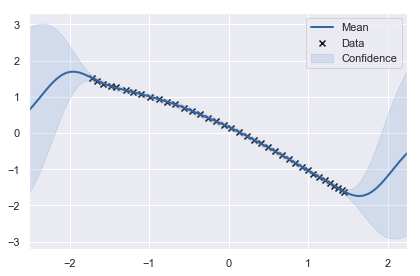

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


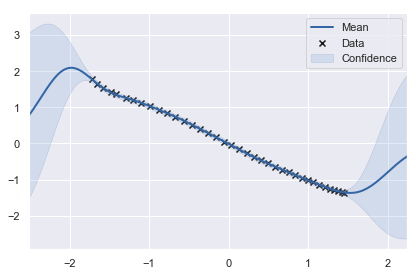

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


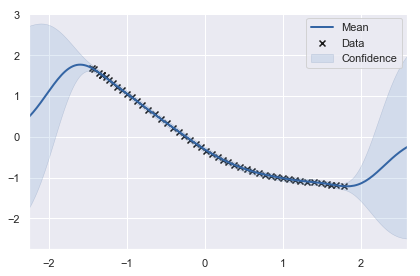

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


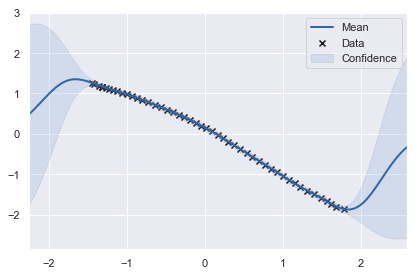

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


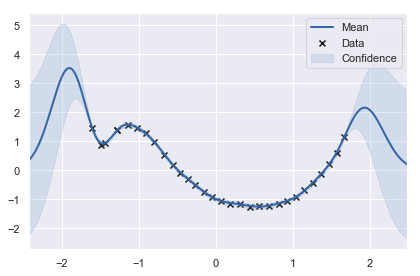

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


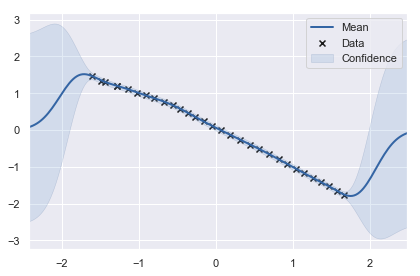

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


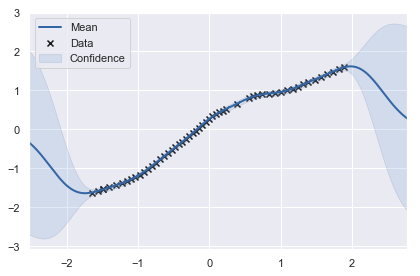

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


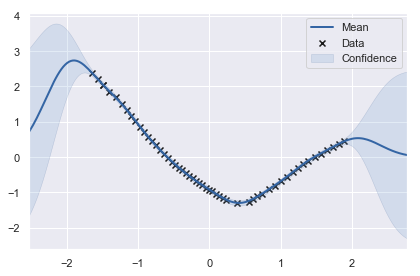

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


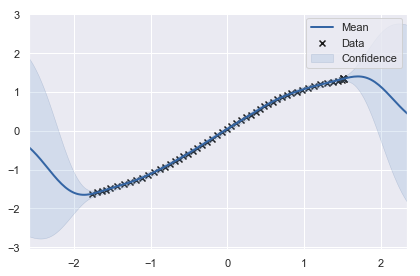

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


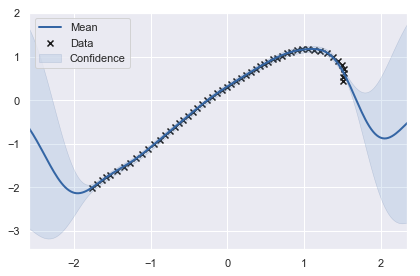

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


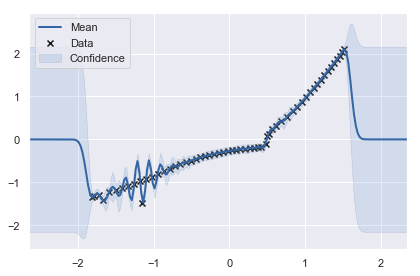

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


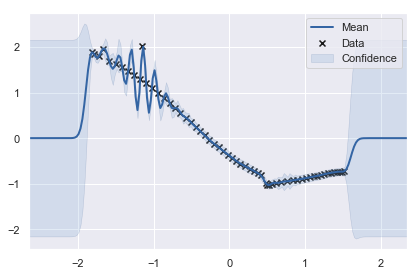

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


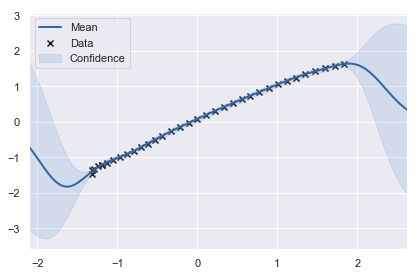

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


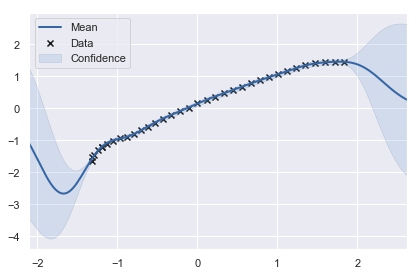

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


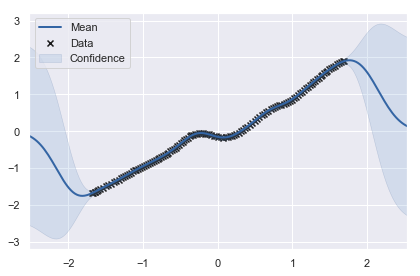

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


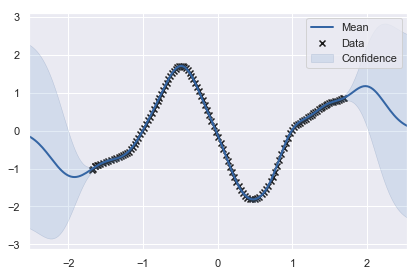

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


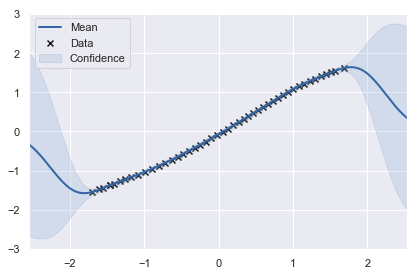

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


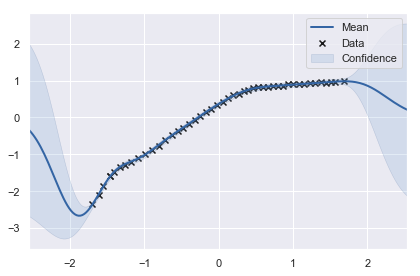

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


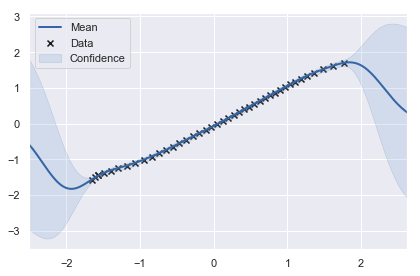

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


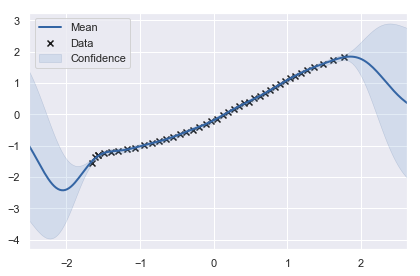

In [287]:
for seg_n in n_segs:
    lik_model = gp.load(LIKELIHOOD_MODEL, route_n, traj_to_plot, seg_n)
    lik_model.model.plot(which_data_ycols=[0])
    lik_model.model.plot(which_data_ycols=[1])
    print(lik_model.model)
    #gp.plot(lik_model)
    


Name : GP regression
Objective : 12.398257154529627
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    4.076376869838035  |      +ve      |        
  rbf.lengthscale          |   0.4666065178209472  |      +ve      |        
  Gaussian_noise.variance  |  0.02798370709770805  |      +ve      |        

Name : GP regression
Objective : -25.8396067720773
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    3.8240777608326235  |      +ve      |        
  rbf.lengthscale          |    1.0028295992072318  |      +ve      |        
  Gaussian_noise.variance  |  0.009076719055820347  |      +ve      |        

Name : GP regression
Objective : 10.18263473909565
Number of Parameters : 3
Number of Optimiza

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


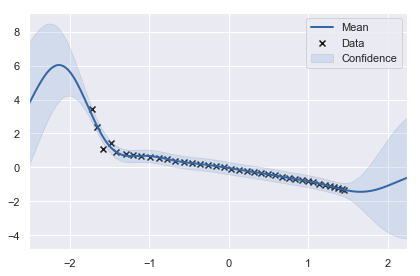

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


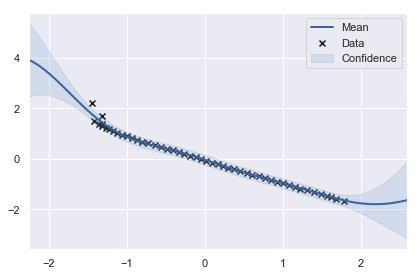

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


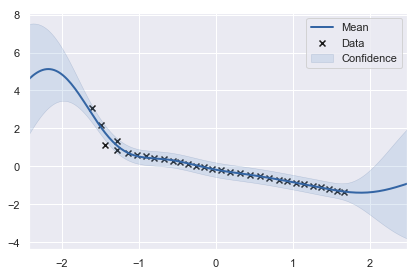

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


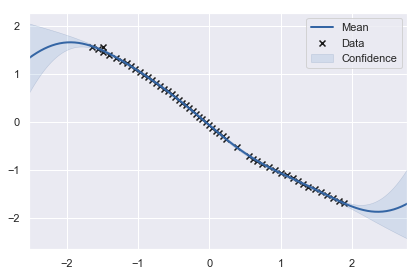

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


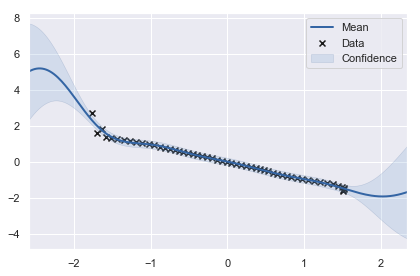

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


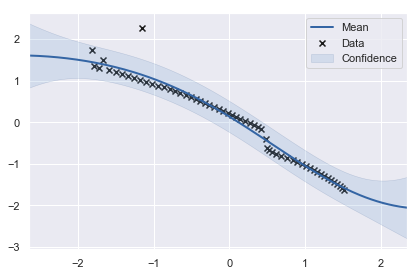

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


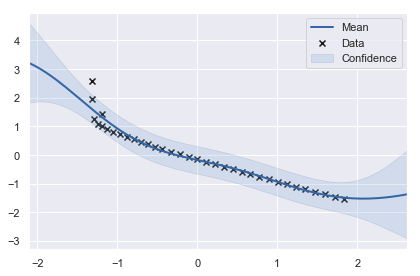

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


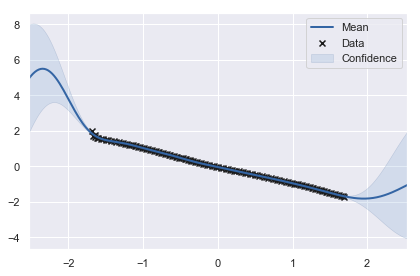

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


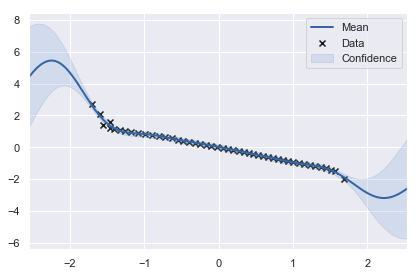

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


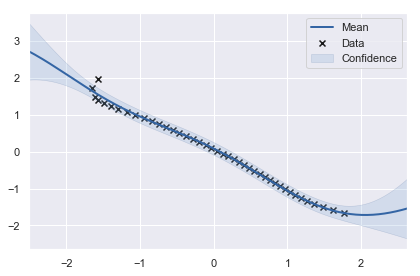

In [271]:
for seg_n in n_segs:
    pred_model = gp.load(PREDICTION_MODEL, route_n, traj_to_plot, seg_n)
    gp.plot(pred_model)
    print(pred_model.model)
    

Let's do the same for the predictive GP

In [67]:
import GPy
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    print(pred_model.route_n, pred_model.traj_n, pred_model.seg_n)
    pred_model.model.plot()

NameError: name 'traj_gps' is not defined

The results for both the GPs look really good. We'll save both to disk.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:21: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



true model 3 13.0 4
            lat        lon  traj  seg  speed  time_left  progress
3174  15.555862  58.409970  13.0    4   4.47       46.0  0.034483
3175  15.555882  58.409866  13.0    4  -1.00       30.0  0.068966
3176  15.555874  58.409912  13.0    4   3.85       27.0  0.103448
3177  15.555884  58.409821  13.0    4   4.37       25.0  0.137931
3178  15.555869  58.409752  13.0    4   6.58       24.0  0.172414
pred: 28.91 true: 24.0 MAE: 4.91 MAPE: 0.20


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


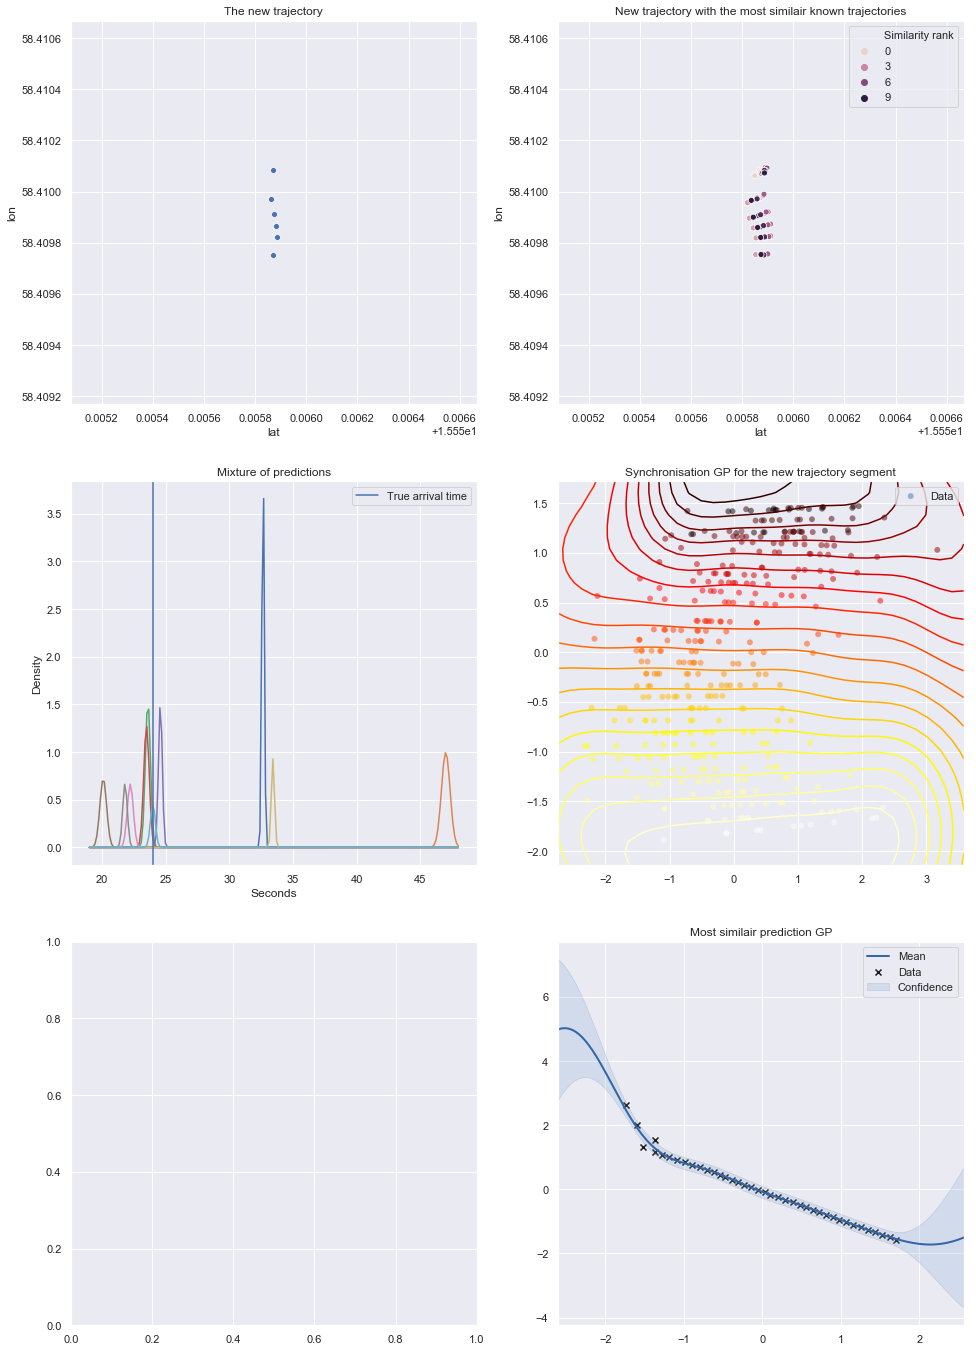

In [381]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

def plot_likelihood_models(models_by_loglik, synched_traj):
    
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
 
    #print([(m[0].route_n, m[0].traj_n, m[0].seg_n) for m in models_by_loglik[:n_models_to_plot]])
    X = synched_traj[['tau']].values
    n_models_to_plot = 10
    models_to_plot = models_by_loglik[:n_models_to_plot]
    n_models = len(models_to_plot)
    dfs = [to_df(mloglik[0], i) for mloglik, i in zip(models_to_plot, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

    
def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y):
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
        
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)
        
    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)
        max_loglik = models_by_loglik[0][1]
        
        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)
            
        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]
    
    synched_traj = synch_traj(synch_gp, traj)
    lik_models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    #print('Most similair model', lik_models_with_weights[0][0].route_n, lik_models_with_weights[0][0].traj_n, lik_models_with_weights[0][0].seg_n)
    
    if plot:
        pred_models_with_weights[0][0].model.plot(ax=axs[2, 1])
        axs[2, 1].set_title('Most similair prediction GP')
        
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, arrival_time=None, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, plot)
    # Don't use all routes. The later ones have crazy small weights
    # leading to numerical issues.
    mean_var_weights = mean_var_weights[:10] 
    if plot:
        sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
        xmin = max(0, np.floor(float(sort[0][0]-sort[0][1]*3)))
        xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
        x = np.linspace(xmin, xmax, 200)
        for mean, var, w in mean_var_weights:
            axs[1,0].plot(x, w*norm.pdf(x, float(mean), np.sqrt(float(var))))
            
        axs[1,0].set_title('Mixture of predictions')
        axs[1,0].set_xlabel('Seconds')
        axs[1,0].set_ylabel('Density')
        if arrival_time:
            axs[1,0].axvline(x=arrival_time, label='True arrival time')
            axs[1,0].legend()
    
    #models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    #models_by_mode = sorted(mean_var_weights, key=lambda p: p[0]*p[2], reverse=True)
    total_weight = sum([w for _, _, w in mean_var_weights])
    weighted_mean = sum([w*float(mean) for mean, var, w in mean_var_weights])/total_weight
    
    #weighted_means = [w*float(mean) for mean, var, w in mean_var_weights]
    #print(weighted_means)
    #mode_model = models_by_mode[0] #mean_var_weights[np.argmax(weighted_means)]
    
    #print(mode_model)
    #n = 200
    #distribution = np.sum([norm.pdf(n, float(mean), np.sqrt(float(var))) for mean, var, w in mean_var_weights])
   
    #print(weighted_means)
    #print(mode_model)
    return weighted_mean #float(mode_model[0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = pd.read_pickle('test.pkl')
n_test_trajs_to_use = 50
n_test_trajs = test.traj.unique()
test = test[test.traj < n_test_trajs[n_test_trajs_to_use]]
traj_n = n_test_trajs[0]
test_traj = test[test.traj == traj_n]
seg_ix = 2
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, seg_n, true_pred_gp=None):
    i = test_seg.index[0]+5 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n)
    true = seg.iloc[-1].time_left
    pred = predict(seg, synch_gp, route_n, seg_n, true, plot=True)
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print('true model', route_n, traj_n, seg_n)
    print(seg.tail())
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    if true_pred_gp:
        true_pred_gp.model.plot(ax=axs[2, 0])
        axs[2,0].set_title('The true prediction GP')
    
#print(test_seg[['lat', 'lon']])
#pred_gp = gp.load(PREDICTION_MODEL, route_n, traj_n, seg_n)
predict_seg_with_plots(test_seg, route_n, seg_n)

In [378]:
mae = []
mape = []
n_test_segs = test.seg.unique()
for seg_n in n_test_segs:
    seg = test[test.seg == seg_n]
    synch_gp = gp.load_synch(route_n, seg_n)
    for traj_n in seg.traj.unique():
        traj = seg[seg.traj == traj_n]
        i = np.random.randint(traj.index[0], traj.index[-1])
        traj = traj[traj.index <= i]
        true = traj.iloc[-1].time_left
        pred = predict(traj, synch_gp, route_n, int(seg_n), true, plot=False)
        mae.append(float(np.abs(true-pred)))
        mape.append(float(np.abs((true-pred)/true)))

print('MAPE: ', np.sum(mape)/len(mape))
print('MAE: ', np.sum(mae)/len(mae))

Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 50 2
Most similair model 3 66 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 66 2
Most similair model 3 159 2
Most similair model 3 171 2
Most similair model 3 87 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 171 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 66 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 

Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 16 8
Most similair model 3 11 8
Most similair model 3 16 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 159 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 16 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair

In [254]:
sgp = gp.load_synch(route_n, seg_n)
s_traj = synch_traj(sgp, test_seg)
m = gp.load(LIKELIHOOD_MODEL, 3, 139, seg_n)
df = pd.DataFrame(gp.predict(m, s_traj[['tau']].values)[0], columns=['lat' ,'lon'])
fig, ax = plt.subplots(1, 1)
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
ax.set_aspect('equal', 'datalim')
fig.set_figwidth(16)
fig.set_figheight(16)

FileNotFoundError: [Errno 2] No such file or directory: './gps/likelihood-2/3.139.11.pkl'

54
47
72.0 104.0
57.0 94.0
53.0 91.0
50.0 86.0
49.0 82.0
48.0 81.0
47.0 80.0
46.0 79.0
45.0 78.0
44.0 77.0
43.0 76.0
42.0 75.0
41.0 74.0
40.0 73.0
39.0 72.0
38.0 71.0
37.0 70.0
36.0 69.0
35.0 68.0
34.0 67.0
33.0 66.0
32.0 65.0
31.0 64.0
30.0 63.0
29.0 62.0
28.0 61.0
27.0 60.0
26.0 59.0
25.0 58.0
24.0 57.0
23.0 56.0
22.0 55.0
21.0 54.0
20.0 53.0
19.0 52.0
18.0 51.0
17.0 50.0
16.0 49.0
15.0 48.0
14.0 47.0
13.0 46.0
12.0 45.0
11.0 44.0
10.0 43.0
9.0 42.0
8.0 39.0
7.0 0.0


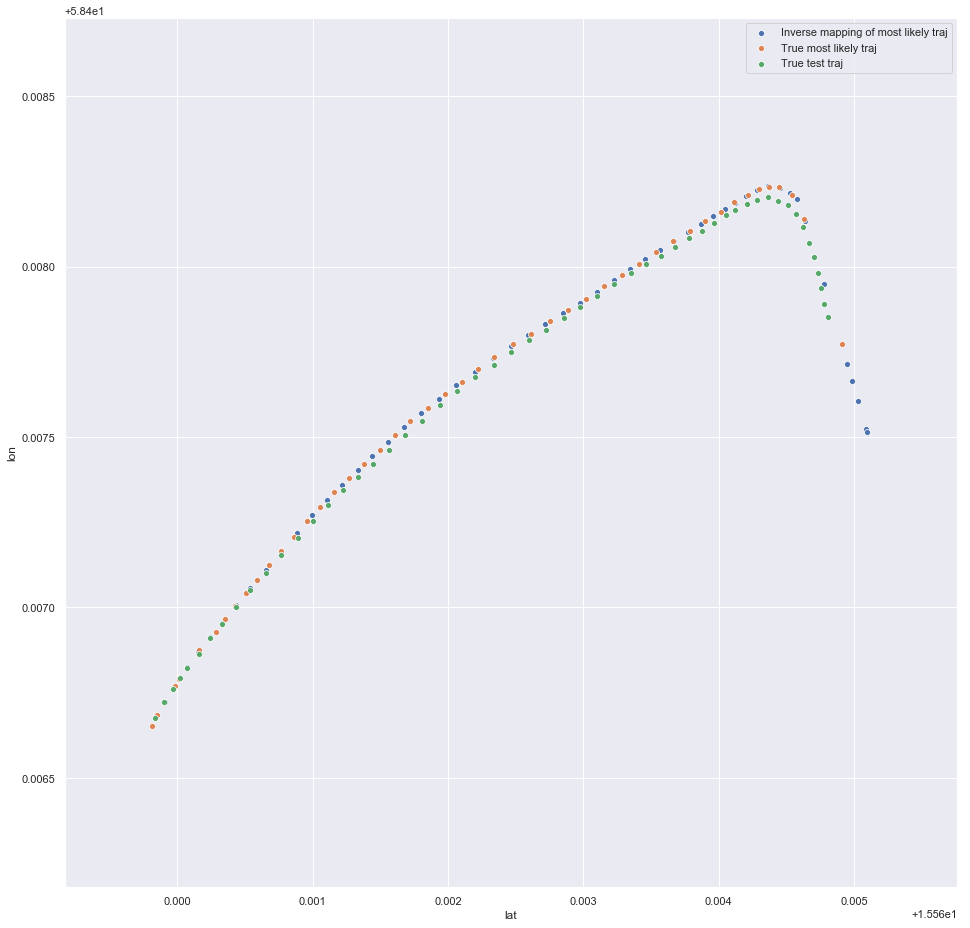

In [133]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(16)
most_likely_seg = train[(train.traj == 139) & (train.seg == seg_n)]
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=most_likely_seg, x='lat', y='lon', ax=ax, label='True most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
print(test_seg.shape[0])
print(most_likely_seg.shape[0])
for a, b in (zip(test_seg.time_left, most_likely_seg.time_left)):
    print(a, b)

Segments 1.0, 1.2, 1.4 are strange, does not seem to converge on one trajectory. Segment 4.2 has an 11 second jump at the final data point

In [255]:
MAPE = []
MAE = []
for seg_n in test.seg.unique()[0:1]:
    seg = test[test.seg == seg_n]
    for traj_n in seg.traj.unique()[0:2]:
        traj = seg[seg.traj == traj_n]
        predict_seg(traj, route_n, seg_n, plot)
       

NameError: name 'predict_seg' is not defined

In [ ]:

abs_errs = []

n_test_segs = test.seg.unique()
for traj_n in n_test_segs:
    traj = test[test.traj == traj_n]
    n_traj_segs = traj.seg.unique()
    for seg_n in n_traj_segs[0:1]:
        seg = traj[traj.seg == seg_n]
        i = np.random.randint(seg.index[0], seg.index[-1]-1)
        seg = seg[seg.index < i]
        synch_gp = gp.load_synch(route_n, seg_n)
        pred = predict(seg, synch_gp, route_n, seg_n)
        true = test_seg.iloc[-1].time_left
        abs_errs.append(np.abs((true-pred)/true))

mape = np.mean(abs_errs)
mape

In [ ]:
print(abs_errs)